In [1]:
import pandas as pd
import os
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import numpy as np
import scipy.stats as stats
import scipy
from scipy.special import inv_boxcox
from sklearn.model_selection import KFold
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import pandas as pd
from catboost import CatBoostClassifier
import math


import warnings
warnings.filterwarnings('ignore')


sicdb_root_path ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\SICDB\\salzburg-intensive-care-database-sicdb-a-freely-accessible-intensive-care-database-1.0.5\\salzburg-intensive-care-database-sicdb-a-freely-accessible-intensive-care-database-1.0.5"
lab_metadata = pd.read_csv(os.path.join(sicdb_root_path, "d_references.csv.gz"))
sicdb_adms = pd.read_csv(os.path.join(sicdb_root_path, "cases.csv.gz"))
sicdb_adms['OffsetOfDeath'] = sicdb_adms['OffsetOfDeath']/60

df = pd.read_csv(os.path.join(sicdb_root_path, "laboratory.csv.gz"))

sicdb_adms = pd.read_csv(os.path.join(sicdb_root_path, "d_references.csv.gz"))

#convert offset from seconds to hours
df['Offset'] = df['Offset']/60


Explantory Analysis - Looking for ids of lab measurements

In [12]:
#lab_metadata[lab_metadata.ReferenceName == 'Laboratory'].head(50)
ids_hem = lab_metadata[lab_metadata.ReferenceValue.str.contains('Hämoglobin')]['ReferenceGlobalID']
#lab_metadata[lab_metadata.ReferenceGlobalID.isin(df.LaboratoryID.unique())]
lab_metadata[lab_metadata.ReferenceValue.str.contains('Hämoglobin')]
#df[df.LaboratoryID.isin(ids_hem)]

ReferenceGlobalID                 ReferenceValue ReferenceName  \
27                 179       Frakt.CO-Hämoglobin (ZL)    Laboratory   
28                 180    Frakt.Deoxy-Hämoglobin (ZL)    Laboratory   
29                 181      Frakt.Met-Hämoglobin (ZL)    Laboratory   
44                 196             CO-Hämoglobin (ZL)    Laboratory   
61                 213              Hämoglobin A (ZL)    Laboratory   
63                 215             Hämoglobin A2 (ZL)    Laboratory   
64                 216              Hämoglobin F (ZL)    Laboratory   
136                288           Hämoglobin (BG) (ZL)    Laboratory   
137                289                Hämoglobin (ZL)    Laboratory   
194                346  freies Plasma Hämoglobin (ZL)    Laboratory   
506                658               Hämoglobin (BGA)    Laboratory   
507                659            O2-Hämoglobin (BGA)    Laboratory   
508                660            CO-Hämoglobin (BGA)    Laboratory   
509                661           Met-Hämoglobin (BGA)    Laboratory   
510                662         Deoxy-Hämoglobin (BGA)    Laboratory   

    ReferenceDescription ReferenceUnit  ReferenceOrder  ReferenceType  Data  
27                   NaN             %               0            0.0   NaN  
28                   NaN             %               0            0.0   NaN  
29                   NaN             %               0            0.0   NaN  
44                   NaN             %               0            0.0   NaN  
61                   NaN             %               0            0.0   NaN  
63                   NaN             %               0            0.0   NaN  
64                   NaN             %               0            0.0   NaN  
136                  NaN          g/dl               0            0.0   NaN  
137                  NaN          g/dl               0            0.0   NaN  
194                  NaN         mg/dl               0            0.0   NaN  
506                  NaN          g/dl               0            0.0   NaN  
507                  NaN             %               0            0.0   NaN  
508                  NaN             %               0            0.0   NaN  
509                  NaN             %               0            0.0   NaN  
510                  NaN             %               0            0.0   NaN

In [39]:
LAB_MAPPING = {
    'Hemoglobin': [289, 658],
    'Hematocrit': [217, 682],
    #'PH':[663,688], #697 - 15,703 rows
    #'PO2':[689,664], #694 - 15,665 rows
    'Glucose':[656,348],
    'Lactate':[657, 465],
    'Chlorid':[683, 450],
    'Potassium':[685,463],
    'Sodium':[469,686]}

COLNAMES_DICT = {'VALUE_COL':'LaboratoryValue',
                 'ITEM_ID_COL':'LaboratoryID',
                 'METADATA_ITEM_ID_COL':'ReferenceGlobalID',
                 'METADATA_NAME_COL':'ReferenceValue',
                 'SUBJECT_ID':'CaseID',
                 'TIME_SINCE_AD': 'Offset',
                 'ROW_ID': 'id'}

# Extract relevant item ids
item_ids_list = list(itertools.chain.from_iterable((LAB_MAPPING.values()))) 

df_pred = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(item_ids_list)]
#df_pred.LaboratoryID.value_counts()

In [38]:
lab_metadata[lab_metadata.ReferenceGlobalID.isin([663,688])]

ReferenceGlobalID ReferenceValue ReferenceName ReferenceDescription  \
511                663   PH (T) (BGA)    Laboratory                  NaN   
536                688       PH (BGA)    Laboratory                  NaN   

    ReferenceUnit  ReferenceOrder  ReferenceType  Data  
511          None               0            0.0   NaN  
536          None               0            0.0   NaN

In [3]:
# Training ML models module
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import pandas as pd
from catboost import CatBoostClassifier
import math

def Kfold_splits(df,COLNAMES_DICT, Kfold):
    """  Get split indices """
    ids_list = df[COLNAMES_DICT['SUBJECT_ID']].unique()
    splits_zipped = []
    splits_zipped_ids = []
    kf = KFold(n_splits=Kfold)

    for train_index, test_index in kf.split(ids_list):
        test_ids = ids_list[test_index].tolist()
        train_ids = ids_list[train_index].tolist()

        test_indexes = df.index[df[COLNAMES_DICT['SUBJECT_ID']].isin(test_ids)].tolist()
        train_indexes = df.index[df[COLNAMES_DICT['SUBJECT_ID']].isin(train_ids)].tolist()
        
        splits_zipped.append([test_indexes, train_indexes])
        splits_zipped_ids.append([test_ids, train_ids])

    return splits_zipped, splits_zipped_ids

def NB_model(X_train, y_train, X_test, args_dict):
    nb_clf = GaussianNB(**args_dict)
    nb_clf.fit(X_train, y_train)
    prediction_proba = nb_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def RF_model(X_train, y_train, X_test, args_dict):
    rf_clf = RandomForestClassifier(**args_dict)
    rf_clf.fit(X_train, y_train)
    prediction_proba = rf_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def GBT_model(X_train, y_train, X_test, args_dict):
    gbt_clf = GradientBoostingClassifier(**args_dict)
    gbt_clf.fit(X_train, y_train)
    prediction_proba = gbt_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def LR_model(X_train, y_train, X_test, args_dict, save_coef=False):
    lr_clf = LogisticRegression(**args_dict)
    lr_clf.fit(X_train, y_train)
    prediction_proba = lr_clf.predict_proba(X_test)[:, 1]

    if save_coef:
        save_features_coef(lr_clf, X_train.columns, f"lr_{lr_clf.get_params()['penalty']}")

    return prediction_proba


def Lasso_model(X_train, y_train, X_test, standardized_features, args_dict, save_coef=False):
    # check if data was already standardized
    if not is_data_standardized(X_train, standardized_features):
        print("Perform standardization for Lasso")
        X_train, features_params = z_score_norm_seen(X_train, standardized_features)
        X_test = z_score_norm_unseen(X_test, standardized_features, features_params)

    # train and predict
    lasso_clf = Lasso(**args_dict)
    lasso_clf.fit(X_train, y_train)
    prediction = lasso_clf.predict(X_test)

    if save_coef:
        save_features_coef(lasso_clf, X_train.columns, "lasso")

    return prediction


def Ridge_model(X_train, y_train, X_test, standardized_features, args_dict, save_coef=False):
    # check if data was already standardized
    if not is_data_standardized(X_train, standardized_features):
        print("Perform standardization for Ridge")
        X_train, features_params = z_score_norm_seen(X_train, standardized_features)
        X_test = z_score_norm_unseen(X_test, standardized_features, features_params)

    # train and predict
    rr_clf = Ridge(**args_dict)
    rr_clf.fit(X_train, y_train)
    prediction = rr_clf.predict(X_test)

    # save features' coefficients if needed
    if save_coef:
        save_features_coef(rr_clf, X_train.columns, "ridge")

    return prediction


def XGB_model(X_train, y_train, X_test, args_dict):
    xgb_clf = xgb.XGBClassifier(**args_dict)
    xgb_clf.fit(X_train, y_train)
    prediction_proba = xgb_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def CatBoost_model(X_train, y_train, X_test, args_dict):
    ctb_clf = CatBoostClassifier(**args_dict)
    ctb_clf.fit(X_train, y_train, verbose=False)
    print("Catboost params: ", ctb_clf.get_params())
    prediction_proba = ctb_clf.predict_proba(X_test, verbose=False)[:, 1]
    return prediction_proba


def SVM_model(X_train, y_train, X_test, standardized_features, args_dict):
    # check if data was already standardized
    if not is_data_standardized(X_train, standardized_features):
        print(f"Perform standardization for {args_dict['kernel']} SVM")
        X_train, features_params = z_score_norm_seen(X_train, standardized_features)
        X_test = z_score_norm_unseen(X_test, standardized_features, features_params)

    if args_dict["kernel"] == 'linear':
        args = args_dict.copy()
        args.pop("kernel")
        lin_svm = svm.LinearSVC(**args)
        svm_clf = CalibratedClassifierCV(lin_svm)
    else:
        svm_clf = svm.SVC(**args_dict)  # svm Classifier

    svm_clf.fit(X_train, y_train)
    prediction_proba = svm_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def MLP_model(X_train, y_train, X_test, standardized_features, args_dict):
    if "hidden_layer_sizes" not in args_dict or args_dict["hidden_layer_sizes"] is None:
        d = len(X_train.columns)
        args_dict["hidden_layer_sizes"] = tuple([d//(2**i) for i in range(1, int(math.log(d, 2)))])

    if not is_data_standardized(X_train, standardized_features):
        print("Perform standardization for MLP")
        X_train, features_params = z_score_norm_seen(X_train, standardized_features)
        X_test = z_score_norm_unseen(X_test, standardized_features, features_params)

    mlp_clf = MLPClassifier(**args_dict)
    mlp_clf.fit(X_train, y_train)
    prediction_proba = mlp_clf.predict_proba(X_test)[:, 1]
    return prediction_proba


def save_features_coef(clf, feat_list, model_name, output_dir='../reports/'):
    """ Store features coefficients of regression models"""
    important_features = pd.DataFrame(clf.coef_).transpose()
    if model_name.find("lr"):
        important_features = important_features.transpose()
    important_features.columns = ["coef"]
    important_features["features"] = feat_list
    output_file_path = output_dir + "features_coef_by" + model_name + ".xlsx"
    important_features.sort_values(by=['coef']).to_excel(output_file_path)



def run_models(X_train, y_train, X_test, models_parameters, save_coef):
    """
    A function that runs all the ml models implemented, by a dictionary containing hyperparameters for each model.
    models_parameters should be a dictionary containing the model name as the key, and a dictionary of hyperparameters
     as value
    models:
    0: NB (nb)
    1: RF (rf)
    2: GBT (gbt)
    3: LR with l2 penalty (lr_l2)
    4: LR with l1 penalty (lr_l1)
    5: LASSO (lasso)
    6: Ridge (rr)
    7: XGB (xgb)
    8: single XGB (single_xgb)
    9: linear SVM (linear_svm)
    10: rbf SVM (rbf_svm)
    11: poly SVM (poly_svm)
    12: sigmoid SVM (sigmoid_svm)
    13: CatBoost (ctb)
    14: MLP (mlp)
    """


    results = {}

    # Naive Bayes Classifier
    if "nb" in models_parameters:
        results["nb"] = NB_model(X_train, y_train, X_test, models_parameters["nb"])

    # Random Forest Classifier
    if "rf" in models_parameters:
        results["rf"] = RF_model(X_train, y_train, X_test, models_parameters["rf"])

    # Gradient Boosting trees Classifier
    if "gbt" in models_parameters:
        results["gbt"] = GBT_model(X_train, y_train, X_test, models_parameters["gbt"])

    # Logistic Regression with l2 penalty Classifier
    if "lr_l2" in models_parameters:
        results["lr_l2"] = LR_model(X_train, y_train, X_test, models_parameters["lr_l2"], save_coef)

    # Logistic Regression with l1 penalty Classifier
    if "lr_l1" in models_parameters:
        results["lr_l1"] = LR_model(X_train, y_train, X_test, models_parameters["lr_l1"], save_coef)

    # LASSO regression
    if "lasso" in models_parameters:
        results["lasso"] = Lasso_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["lasso"], save_coef)

    # Ridge regression
    if "rr" in models_parameters:
        results["rr"] = Ridge_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["rr"], save_coef)

    # xgboost
    if "xgb" in models_parameters:
        results["xgb"] = XGB_model(X_train, y_train, X_test, models_parameters["xgb"])

    # Single tree - xgboost
    if "single_xgb" in models_parameters:
        results["single_xgb"] = XGB_model(X_train, y_train, X_test, models_parameters["single_xgb"])

    # SVM Classifiers
    if "linear_svm" in models_parameters:
        results["linear_svm"] = SVM_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["linear_svm"])
    if "rbf_svm" in models_parameters:
        results["rbf_svm"] = SVM_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["rbf_svm"])
    if "poly_svm" in models_parameters:
        results["poly_svm"] = SVM_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["poly_svm"])
    if "sigmoid_svm" in models_parameters:
        results["sigmoid_svm"] = SVM_model(X_train.copy(), y_train, X_test.copy(), num_selected_features, models_parameters["sigmoid_svm"])

    # catboost
    if "ctb" in models_parameters:
        results["ctb"] = CatBoost_model(X_train, y_train, X_test, models_parameters["ctb"])

    # MLP
    if "mlp" in models_parameters:
        results["mlp"] = MLP_model(X_train, y_train, X_test, num_selected_features, models_parameters["mlp"])


    return results


In [413]:
n_folds = 5
models_vector = {"nb": {},
                     #"rf": {"random_state": 1, "n_estimators": 200,"max_depth":6},
                     "gbt": {"random_state": 1, "n_estimators": 200},
                     "lr_l2": {"random_state": 1, "penalty": "l2", "solver":"saga"},
                     "lr_l1": {"random_state": 1, "penalty": "l1", "solver":"saga"},
                     #"lasso": {"random_state": 1, "alpha":0.01},
                     #"rr": {"random_state": 1, "alpha":0.01},
                     #"xgb": {"random_state": 1, "n_estimators": 100},
                     #"single_xgb": {"random_state": 1, "n_estimators": 1},
                     #"linear_svm": {"random_state": 1, "kernel": "linear"},
                     #"rbf_svm": {"random_state": 1, "kernel": "rbf", "probability": True},
                     #"poly_svm": {"random_state": 1, "kernel": "poly", "probability": True},
                     #"sigmoid_svm": {"random_state": 1, "kernel": "sigmoid", "probability": True},
                     "ctb": {"random_state": 1, "verbose": False, "depth": None, "learning_rate": None, "l2_leaf_reg": None},
                     #"mlp": {"random_state": 1, "max_iter": 300, "hidden_layer_sizes": None}
                    }
#max_int = 5
#method_merge = 'boxcox'

risk_scores_df


X = df_pred.copy()
splits_zipped,splits_zipped_ids = Kfold_splits(X,COLNAMES_DICT, n_folds)

risk_scores_df = pd.DataFrame()

split = 1

for test_ids, train_ids in tqdm(splits_zipped_ids):
    X_train, X_test = X[X[COLNAMES_DICT['SUBJECT_ID']].isin(train_ids)], X[X[COLNAMES_DICT['SUBJECT_ID']].isin(test_ids)]
    
    for method_merge in ['boxcox','reg_merge']:
        if(method_merge == 'boxcox'):
            for max_int in [5,10]:
                print(f'Split={split}, method_merge={method_merge}, max_int={max_int}')
                model_results, Y_test = merge_impute_transpose_outcome(LAB_MAPPING,COLNAMES_DICT, df,X_train.copy(),X_test.copy(),sicdb_adms,
                                                            models_vector,max_int,method_merge)
                model_results["Split"] = split
                model_results["Target"] = Y_test
                temp_res = pd.DataFrame.from_dict(model_results)
                risk_scores_df = risk_scores_df.append(temp_res, sort=False)
        else:
            print(f'Split={split}, method_merge={method_merge}, max_int={max_int}')
            model_results, Y_test = merge_impute_transpose_outcome(LAB_MAPPING,COLNAMES_DICT, df,X_train.copy(),X_test.copy(),sicdb_adms,
                                                            models_vector,max_int,method_merge)
            model_results["Split"] = split
            model_results["Target"] = Y_test
            temp_res = pd.DataFrame.from_dict(model_results)
            risk_scores_df = risk_scores_df.append(temp_res, sort=False)
    split += 1

  0%|          | 0/5 [00:00<?, ?it/s]

Split=1, method_merge=boxcox, max_int=5
(1452171, 6)
(5671568, 6)
(1452171, 6)
(5671568, 6)
(198558, 10)
(779312, 10)
(198558, 10)
(779312, 10)
Catboost params:  {'verbose': False, 'random_state': 1}
Split=1, method_merge=boxcox, max_int=10
(1452171, 6)
(5671568, 6)
(1452171, 6)
(5671568, 6)
(198558, 10)
(779312, 10)
(198558, 10)
(779312, 10)
Catboost params:  {'verbose': False, 'random_state': 1}
Split=1, method_merge=reg_merge, max_int=10
(1452171, 6)
(5671568, 6)
(1452171, 6)
(5671568, 6)
(198558, 10)
(779312, 10)
(198558, 10)
(779312, 10)
Catboost params:  {'verbose': False, 'random_state': 1}
Split=2, method_merge=boxcox, max_int=5
(1413672, 6)
(5710067, 6)
(1413672, 6)
(5710067, 6)
(192916, 10)
(784954, 10)
(192916, 10)
(784954, 10)
Catboost params:  {'verbose': False, 'random_state': 1}
Split=2, method_merge=boxcox, max_int=10
(1413672, 6)
(5710067, 6)
(1413672, 6)
(5710067, 6)
(192916, 10)
(784954, 10)
(192916, 10)
(784954, 10)
Catboost params:  {'verbose': False, 'random_state

In [397]:
#risk_scores_df.shape
#11734440 / 15

#787205*1.25

##984006.25
risk_scores_df[(risk_scores_df.method_merge == 'boxcox_5')]

rf       xgb method_merge max_int  Split  Target
0       0.020689  0.006639     boxcox_5       5      1   False
1       0.027552  0.002720     boxcox_5       5      1   False
2       0.058038  0.002007     boxcox_5       5      1   False
3       0.085969  0.022087     boxcox_5       5      1   False
4       0.132100  0.087055     boxcox_5       5      1   False
...          ...       ...          ...     ...    ...     ...
787199  0.006184  0.000914     boxcox_5       5      5   False
787200  0.006170  0.001351     boxcox_5       5      5   False
787201  0.006486  0.001961     boxcox_5       5      5   False
787202  0.006216  0.003850     boxcox_5       5      5   False
787203  0.006216  0.001370     boxcox_5       5      5   False

[3911480 rows x 6 columns]

In [54]:
#risk_scores_df.to_csv('risk_scores_df_methods_new.csv')
#change method name to boxcox_maxint
#risk_scores_df.loc[(risk_scores_df.method_merge == 'boxcox'), 'method_merge'] = risk_scores_df[(risk_scores_df.method_merge == 'boxcox')]["method_merge"]+"_"+risk_scores_df[(risk_scores_df.method_merge == 'boxcox')]['max_int'].astype(str)
models_vector = {#"nb": {},
                     "rf": {"random_state": 1, "n_estimators": 200,"max_depth":6},
                     #"gbt": {"random_state": 1, "n_estimators": 200},
                     #"lr_l2": {"random_state": 1, "penalty": "l2", "solver":"saga"},
                     #"lr_l1": {"random_state": 1, "penalty": "l1", "solver":"saga"},
                     #"lasso": {"random_state": 1, "alpha":0.01},
                     #"rr": {"random_state": 1, "alpha":0.01},
                     "xgb": {"random_state": 1, "n_estimators": 100},
                     #"single_xgb": {"random_state": 1, "n_estimators": 1},
                     #"linear_svm": {"random_state": 1, "kernel": "linear"},
                     #"rbf_svm": {"random_state": 1, "kernel": "rbf", "probability": True},
                     #"poly_svm": {"random_state": 1, "kernel": "poly", "probability": True},
                     #"sigmoid_svm": {"random_state": 1, "kernel": "sigmoid", "probability": True},
                     #"ctb": {"random_state": 1, "verbose": False, "depth": None, "learning_rate": None, "l2_leaf_reg": None},
                     #"mlp": {"random_state": 1, "max_iter": 300, "hidden_layer_sizes": None}
                    }
risk_scores_df = pd.read_csv('risk_scores_df_rf_new.csv',index_col=[0])


df_performance = pd.DataFrame(columns=['Split','method_merge','model','auc','aupr'])

for ind_split in risk_scores_df['Split'].unique():
    for imp_method in risk_scores_df['method_merge'].unique():
        for model in list(models_vector.keys()):
            y_prob = risk_scores_df[(risk_scores_df['Split']==ind_split) & (risk_scores_df['method_merge']==imp_method)][model]
            y_target = risk_scores_df[(risk_scores_df['Split']==ind_split) & (risk_scores_df['method_merge']==imp_method)]['Target']

            fpr, tpr, thresholds = roc_curve(y_target, y_prob, drop_intermediate=False)
            aucRes = roc_auc_score(y_target, y_prob)

            precision, recall, thresholds_pr = precision_recall_curve(y_target, y_prob)
            aupr = auc(recall, precision)

            tempRow = [ind_split,imp_method,model,aucRes, aupr]
            df_performance = df_performance.append(pd.Series(tempRow, index=df_performance.columns), ignore_index=True)
            
comparison_table(df_performance,'auc','final_2')
comparison_table(df_performance,'aupr','final_2')


 comparison table of auc was generated

 comparison table of aupr was generated


In [52]:
comparison_table(df_performance,'auc','final')
comparison_table(df_performance,'aupr','final')

#comparison_table(df_performance,'auc','final')
#comparison_table(df_performance,'aupr','final')


 comparison table of auc was generated

 comparison table of aupr was generated


In [51]:
def comparison_table(df_performance,metric,ver):
    res = df_performance.groupby(['method_merge','model'])[metric].median().reset_index().sort_values(by='model').rename(columns={metric: 'median_'+metric})
    res['median_'+metric] = round(res['median_'+metric],4)*100
    mean = round(df_performance.groupby(['method_merge','model'])[metric].mean().reset_index().sort_values(by='model').rename(columns={metric: 'mean_'+metric})['mean_'+metric],4)*100
    sd = round(df_performance.groupby(['method_merge','model'])[metric].std().reset_index().sort_values(by='model').rename(columns={metric: 'std'})['std'],4)*100

    res_summary = pd.concat([res,mean,sd], axis=1)

    #res_summary['new'] = str(res_summary['median_auc'])+u"\u00B1"+str(res_summary['std'])
    res_summary['median_std'] = res_summary['median_'+metric].apply("{:.02f}".format).astype(str)+u"\u00B1"+res_summary['std'].apply("{:.02f}".format).astype(str)
    res_summary['mean_std'] = res_summary['mean_'+metric].apply("{:.02f}".format).astype(str)+u"\u00B1"+res_summary['std'].apply("{:.02f}".format).astype(str)

    df_mean_std = res_summary[['method_merge','model','mean_std']]
    df_mean_std = df_mean_std.pivot(index='method_merge', columns='model', values='mean_std').reset_index()
    df_mean_std.to_csv('df_mean_std_'+metric+'_'+ver+'.csv', encoding="utf-8-sig")

    df_median_std = res_summary[['method_merge','model','median_std']]
    df_median_std = df_median_std.pivot(index='method_merge', columns='model', values='median_std').reset_index()
    df_median_std.to_csv('df_median_std_'+metric+'_'+ver+'.csv', encoding="utf-8-sig")

    print(f"\n comparison table of {metric} was generated")
    
comparison_table(df_performance,'auc','rrrr')


 comparison table of auc was generated


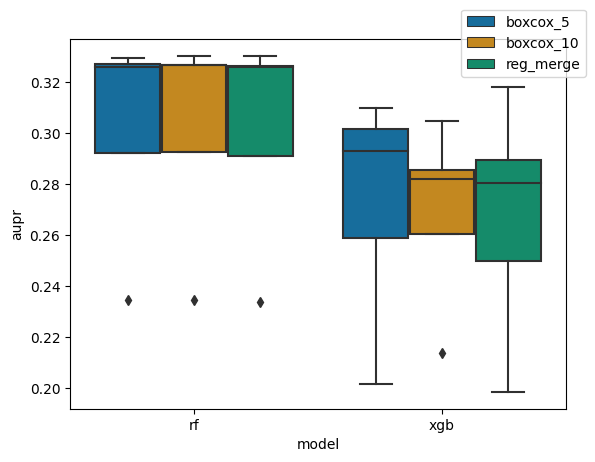

In [412]:
sns.boxplot(y='aupr', x='model',
                 data=df_performance,
                 palette="colorblind",
                 hue='method_merge')
plt.legend(bbox_to_anchor=(1.04, 1.08), loc=1, borderaxespad=0.)

#plt.savefig("aupr_"+metric+'_'+ver+'.png')
plt.show()

In [406]:
def merge_impute_transpose_outcome(LAB_MAPPING,COLNAMES_DICT, df,X_train,X_test,sicdb_adms,models_vector,
                                   max_int,method_merge):
    
    print(X_test.shape)
    print(X_train.shape)
    
    if (method_merge == 'boxcox'):
        for t_lab_name in LAB_MAPPING.keys():
            counts_per_id = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[t_lab_name])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()

            top_id = counts_per_id.index[0]
            next_id = counts_per_id.index[1]

            X_train, X_test = box_cox_transform_train_test(X_train.copy(), X_test.copy(), COLNAMES_DICT,max_int,top_id,next_id,t_lab_name)

    if (method_merge == 'reg_merge'):
        X_train, X_test


    #convert item ids to lab names
    invert_LAB_MAPPING = invert_dict(LAB_MAPPING)
    X_train[COLNAMES_DICT['ITEM_ID_COL']] = X_train[COLNAMES_DICT['ITEM_ID_COL']].apply(lambda x: invert_LAB_MAPPING.get(x))
    X_test[COLNAMES_DICT['ITEM_ID_COL']] = X_test[COLNAMES_DICT['ITEM_ID_COL']].apply(lambda x: invert_LAB_MAPPING.get(x))
    print(X_test.shape)
    print(X_train.shape)

    #convert table to table
    X_train = X_train.pivot_table(values=COLNAMES_DICT['VALUE_COL'], index=[COLNAMES_DICT['SUBJECT_ID'], COLNAMES_DICT['TIME_SINCE_AD']],columns=[COLNAMES_DICT['ITEM_ID_COL']]).reset_index().sort_values(by=[COLNAMES_DICT['SUBJECT_ID'], COLNAMES_DICT['TIME_SINCE_AD']])
    X_test = X_test.pivot_table(values=COLNAMES_DICT['VALUE_COL'], index=[COLNAMES_DICT['SUBJECT_ID'], COLNAMES_DICT['TIME_SINCE_AD']],columns=[COLNAMES_DICT['ITEM_ID_COL']]).reset_index().sort_values(by=[COLNAMES_DICT['SUBJECT_ID'], COLNAMES_DICT['TIME_SINCE_AD']])

    print(X_test.shape)
    print(X_train.shape)
    
    #Extract outcomes
    Y_train = pd.merge(X_train, sicdb_adms, on=[COLNAMES_DICT['SUBJECT_ID']])
    Y_train = ((Y_train['OffsetOfDeath'] - Y_train[COLNAMES_DICT['TIME_SINCE_AD']]) < 24*60)
    Y_test = pd.merge(X_test, sicdb_adms, on=[COLNAMES_DICT['SUBJECT_ID']])
    Y_test = ((Y_test['OffsetOfDeath'] - Y_test[COLNAMES_DICT['TIME_SINCE_AD']]) < 24*60)

    # imputation
    # Calc mean per feature
    imputer = X_train[list(LAB_MAPPING.keys())].mean()

    # Impute fill-forward
    X_train[list(LAB_MAPPING.keys())] = X_train.groupby(COLNAMES_DICT['SUBJECT_ID'])[list(LAB_MAPPING.keys())].transform(lambda x: x.fillna(method='ffill'))
    X_test[list(LAB_MAPPING.keys())] = X_test.groupby(COLNAMES_DICT['SUBJECT_ID'])[list(LAB_MAPPING.keys())].transform(lambda x: x.fillna(method='ffill'))

    print(X_test.shape)
    print(X_train.shape)
    
    # Impute mean
    X_train[list(LAB_MAPPING.keys())] = X_train[list(LAB_MAPPING.keys())].fillna(imputer)
    X_test[list(LAB_MAPPING.keys())] = X_test[list(LAB_MAPPING.keys())].fillna(imputer)
    
    X_train.to_csv('X_train.csv')
    X_test.to_csv('X_test.csv')

    model_results = run_models(X_train, Y_train, X_test, models_vector, False)
    model_results["method_merge"] = method_merge 
    if (method_merge == 'boxcox'):
        model_results["max_int"] = max_int
    if (method_merge == 'reg_merge'):
        model_results["max_int"] = None

    return(model_results, Y_test)

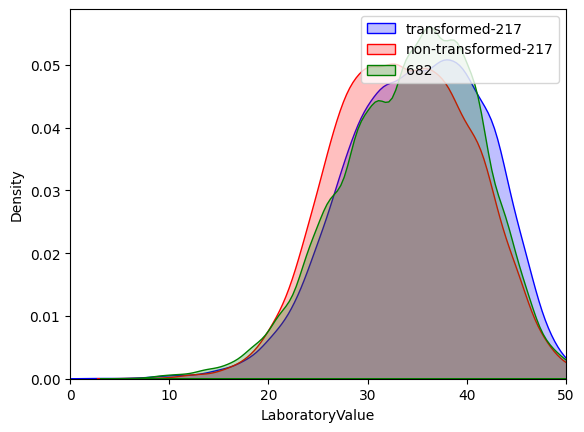

In [227]:
max_int = 2 #minutes


t_lab_name = 'Hematocrit'
counts_per_id = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[t_lab_name])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()

top_id = counts_per_id.index[0]
next_id = counts_per_id.index[1]

X_train = X_train[X_train[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])].groupby([COLNAMES_DICT['SUBJECT_ID'],COLNAMES_DICT['ITEM_ID_COL']]).first().reset_index()
X_train_old  = X_train_old[X_train_old[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])].groupby([COLNAMES_DICT['SUBJECT_ID'],COLNAMES_DICT['ITEM_ID_COL']]).first().reset_index()

    
xxx = X_train[(X_train['LaboratoryID'] == top_id) & (X_train['LaboratoryValue'] < 100) & (X_train['LaboratoryValue'] > 2)]
fig = sns.kdeplot(X_train[X_train['LaboratoryID'] == next_id]['LaboratoryValue'], shade=True, color="b", label='transformed-217')
fig = sns.kdeplot(X_train_old[X_train_old['LaboratoryID'] == next_id]['LaboratoryValue'], shade=True, color="r", label='non-transformed-217')
fig = sns.kdeplot(xxx[xxx['LaboratoryID'] == top_id]['LaboratoryValue'], shade=True, color="g", label='682')
plt.xlim(0,50)
plt.legend()

In [45]:
def extract_consecutive_measurement(df_labs_mimic, t_subject_id,t_ids):

    df_pat = df[(df[COLNAMES_DICT['SUBJECT_ID']] == t_subject_id) & df[COLNAMES_DICT['ITEM_ID_COL']].isin(t_ids)]

    #df_pat['Offset'] = df_pat['Offset']/60

    # sort patient data in ascending order and filter shifted rows
    asc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)
    asc_sorted = asc_sorted.loc[asc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != asc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    dsc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=False)
    dsc_sorted = dsc_sorted.loc[dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    # take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
    df_pat_sum = df_pat[df_pat[COLNAMES_DICT['ROW_ID']].isin(dsc_sorted[COLNAMES_DICT['ROW_ID']].to_list()+asc_sorted[COLNAMES_DICT['ROW_ID']].to_list())].drop_duplicates()
    df_pat_sum = df_pat_sum.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)

    temp_diff = df_pat_sum[COLNAMES_DICT['TIME_SINCE_AD']].diff()
    df_pat_sum['delta_time'] =  temp_diff.iloc[np.arange(-len(temp_diff)+1,1)].to_list()

    # create col for the next value and item id
    df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['VALUE_COL']].shift(-1, fill_value='END')
    df_pat_sum['next_ITEMID'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['ITEM_ID_COL']].shift(-1, fill_value='END')

    df_pat_sum['diff_ids'] = df_pat_sum[COLNAMES_DICT['ITEM_ID_COL']] != df_pat_sum['next_ITEMID']

    df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]

    return(df_pat_sum)

def correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,cor_plot_type):
    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]

    df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
    df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

    df_top.sort_index(inplace=True)
    df_next.sort_index(inplace=True)

    top_sorted_values = df_top[COLNAMES_DICT['VALUE_COL']]
    next_sorted_values = df_next[COLNAMES_DICT['VALUE_COL']]

    #remove NaN
    top_sorted_values = top_sorted_values[(~top_sorted_values.isna()) & (~next_sorted_values.isna())]
    next_sorted_values = next_sorted_values[(~top_sorted_values.isna()) & (~next_sorted_values.isna())]
    
    corr, p_corr = scipy.stats.pearsonr(top_sorted_values, next_sorted_values)
    plt.figure(figsize=(4, 4), dpi=300)
    plt.scatter(top_sorted_values, next_sorted_values)
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(top_sorted_values, next_sorted_values, 1)

    #use red as color for regression line
    plt.plot(top_sorted_values, m*top_sorted_values+b, color='red')
    
    #p_corr = "{:.2e}".format(p_corr)
    #p_corr = "<0.0001" if p_corr < 18 else (r'$=%.4f$' % (p_corr, ))

    textstr = '\n'.join((
        r'$r=%.4f$' % (corr, ),
        r'$p=%.2e$' % (p_corr, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    # place a text box in upper left in axes coords
    plt.text(max(max(top_sorted_values),max(next_sorted_values))*0.6, max(max(top_sorted_values),max(next_sorted_values))*0.2, textstr, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.xlim(min(min(top_sorted_values),min(next_sorted_values)),max(max(top_sorted_values),max(next_sorted_values)))
    plt.xlabel(top_name)
    plt.ylim(min(min(top_sorted_values),min(next_sorted_values)),max(max(top_sorted_values),max(next_sorted_values)))
    plt.ylabel(next_name)
    if(cor_plot_type == 'transformed'):
        plt.savefig(f'correlation_consecutive_transformed_{t_lab_name}.jpg')
    if(cor_plot_type == 'non_transformed'):
        plt.savefig(f'correlation_consecutive_non_transformed_{t_lab_name}.jpg')
    plt.show()
    
    return(p_corr,corr)

def all_measurements_plot(df,COLNAMES_DICT, FEATURE_NAME,plot_type,top_id,next_id, max_int=None):
    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    
    df[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df[COLNAMES_DICT['VALUE_COL']])
        
    if(plot_type == 'first'):
        df  = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])].groupby([COLNAMES_DICT['SUBJECT_ID'],COLNAMES_DICT['ITEM_ID_COL']]).first().reset_index()

    if((plot_type == 'first') | (plot_type == 'all')):
        p_val = stats.ttest_ind(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
    if((plot_type == 'consecutive') | (plot_type == 'consecutive_transformed')):
        p_val = stats.ttest_rel(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
        
    max_xlim = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id,next_id])][COLNAMES_DICT['VALUE_COL']].mean()*3
    min_xlim = 0
    if (round(max_xlim,0) == 0): #data was standerdized
        max_xlim = 5
        min_xlim = -5
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)
    if(plot_type == 'first'):
        plt.title(f'First measurement per subject, P-Value = {text_p_val}')
    if(plot_type == 'all'):
        plt.title(f'All measurements, P-Value = {text_p_val}')
    if(plot_type == 'consecutive'):
        plt.title(f'Consecutive measurements [{max_int}min], P-Value = {text_p_val}, [N = {int(len(df)/2):,}]')
    if(plot_type == 'consecutive_transformed'):
        plt.title(f'Consecutive transformed measurements [{max_int}min], P-Value = {text_p_val}, [N = {int(len(df)/2):,}]')

    plt.xlim(min_xlim,max_xlim)
    plt.xlabel(FEATURE_NAME)

    plt.legend()        
    if(plot_type == 'first'):
        plt.savefig(f'{FEATURE_NAME}_first_measurements.jpg')
    if(plot_type == 'all'):
        plt.savefig(f'{FEATURE_NAME}_all_measurements.jpg')
    if(plot_type == 'consecutive'):
        plt.savefig(f'{FEATURE_NAME}_consecutive_{max_int}min.jpg')
    if(plot_type == 'consecutive_transformed'):
        plt.savefig(f'{FEATURE_NAME}_consecutive_transformed_{max_int}min.jpg')

    plt.show()

    return(p_val)


def box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT):
    df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
    df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

    df_top_box, top_box_lambda = stats.boxcox(df_top[COLNAMES_DICT['VALUE_COL']])
    df_next_box, next_box_lambda = stats.boxcox(df_next[COLNAMES_DICT['VALUE_COL']])

    mu_top = df_top_box.mean()
    sig_top = df_top_box.std()

    total_data_box = total_data.copy()
    #total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == top_id, COLNAMES_DICT['VALUE_COL']] = df_top_box
    total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == next_id, COLNAMES_DICT['VALUE_COL']] = inv_boxcox(((stats.zscore(df_next_box))*(sig_top))+mu_top,top_box_lambda)
    
    return(top_box_lambda,mu_top,sig_top, total_data_box)


def invert_dict(input_dict):
    """ Gets a dict that has list values.
        Converts them to a format where each item on the list is a key, and the original key is the value.
        {"key":["a","b"]} -> {"a": "key", "b": "key"}
    """
    output_dict = {}
    for key, val_list in input_dict.items():
        for feat_to_rename in val_list:
            output_dict[feat_to_rename] = key

    return output_dict

def box_cox_transform_train_test(X_train, X_test, COLNAMES_DICT,max_int,top_id,next_id,t_lab_name):
    train_ids = X_train[COLNAMES_DICT['SUBJECT_ID']].unique()

    # load conssecutive measurements
    df_lab = pd.read_csv(f'sicdb_{t_lab_name}_consecutive.csv', index_col=[0])

    # take only ids in train
    df_lab_train = df_lab[df_lab[COLNAMES_DICT['SUBJECT_ID']].isin(train_ids)]

    # remove last rows per patient
    df_lab_train = df_lab_train[(df_lab_train['next_VALUENUM'] != 'END') & (df_lab_train[COLNAMES_DICT['VALUE_COL']] != 'END')]

    # covnvert values to numeric values
    df_lab_train['next_VALUENUM'] = pd.to_numeric(df_lab_train['next_VALUENUM'])
    df_lab_train[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df_lab_train[COLNAMES_DICT['VALUE_COL']])

    #exclude inhuman values
    df_lab_train = df_lab_train[(df_lab_train[COLNAMES_DICT['VALUE_COL']] >0) & (df_lab_train['next_VALUENUM'] >0)]
    df_lab_train = df_lab_train[(df_lab_train[COLNAMES_DICT['VALUE_COL']] <1000) & (df_lab_train['next_VALUENUM'] <1000)]

    # Exlude nan values
    df_lab_train = df_lab_train[(~df_lab_train[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_train.next_VALUENUM.isna())]

    # Take only subset with consecutive measurements lower than max-int
    df_lab_train = df_lab_train[df_lab_train.delta_time < max_int]

    next_values = df_lab_train[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
    current_values =  df_lab_train[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

    total_data = pd.concat([current_values,next_values],axis =0)
    total_data.LaboratoryID = pd.to_numeric(total_data.LaboratoryID)

    # Learn boxcox transformation based on conssecutive measurements
    top_box_lambda,mu_top,sig_top, total_data_boxcox = box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT)

    # Convert next_id to normal distribution using train data
    X_train_next_box, train_next_box_lambda = stats.boxcox(X_train[X_train[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']])

    # Using  the learned train_next_box_lambda, convert the test set
    X_test_next_box = stats.boxcox(X_test[X_test[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']],train_next_box_lambda)

    # Transform data to normal distribution
    X_train_next_box_trasnformed = inv_boxcox(((stats.zscore(X_train_next_box))*(sig_top))+mu_top,top_box_lambda)
    X_test_next_box_trasnformed = inv_boxcox(((stats.zscore(X_test_next_box))*(sig_top))+mu_top,top_box_lambda)
    
    # assign tranformed values
    X_train.loc[(X_train[COLNAMES_DICT['ITEM_ID_COL']] == next_id), COLNAMES_DICT['VALUE_COL']] = X_train_next_box_trasnformed
    X_test.loc[(X_test[COLNAMES_DICT['ITEM_ID_COL']] == next_id), COLNAMES_DICT['VALUE_COL']] = X_test_next_box_trasnformed

    return(X_train, X_test)

Generate tables of consecutive measurements

In [ ]:
from tqdm.autonotebook import tqdm
from random import sample

#t_lab_name = 'Hemoglobin' #'Potassium', 'Sodium', 'Bicarbonate'

for t_lab_name in LAB_MAPPING.keys():
    print(t_lab_name)
    t_ids = LAB_MAPPING[t_lab_name]
    subject_ids = df[COLNAMES_DICT['SUBJECT_ID']].unique()
    #subject_ids = sample(subject_ids.tolist(),1000)

    df_lab = extract_consecutive_measurement(df, subject_ids[0],t_ids)

    for t_subject_id in tqdm(subject_ids[1:], mininterval=60):
        t_df_pat_sum = extract_consecutive_measurement(df, t_subject_id,t_ids)
        df_lab = pd.concat([df_lab,t_df_pat_sum])

    df_lab.to_csv(f'sicdb_{t_lab_name}_consecutive.csv')

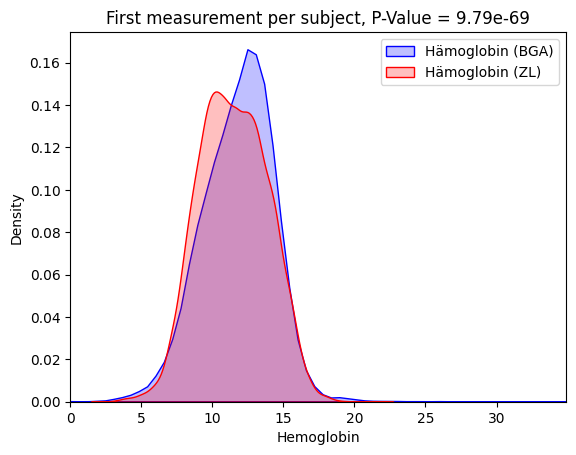

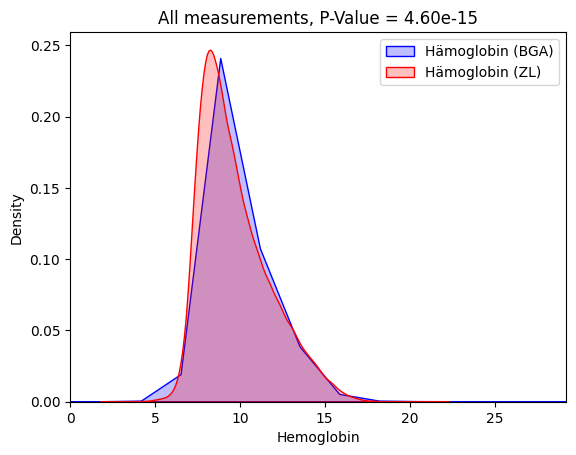

Feature:Hemoglobin, T=5


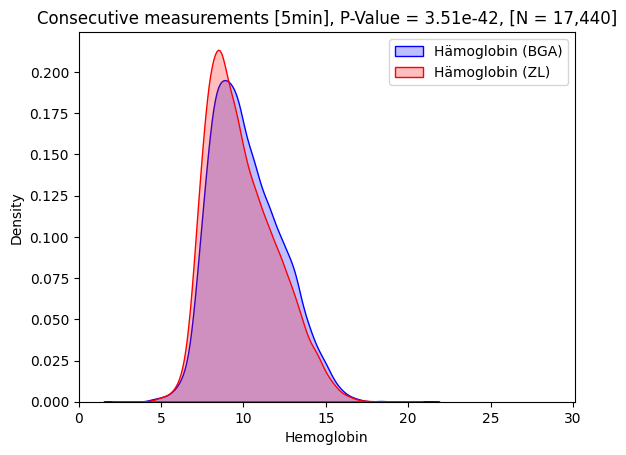

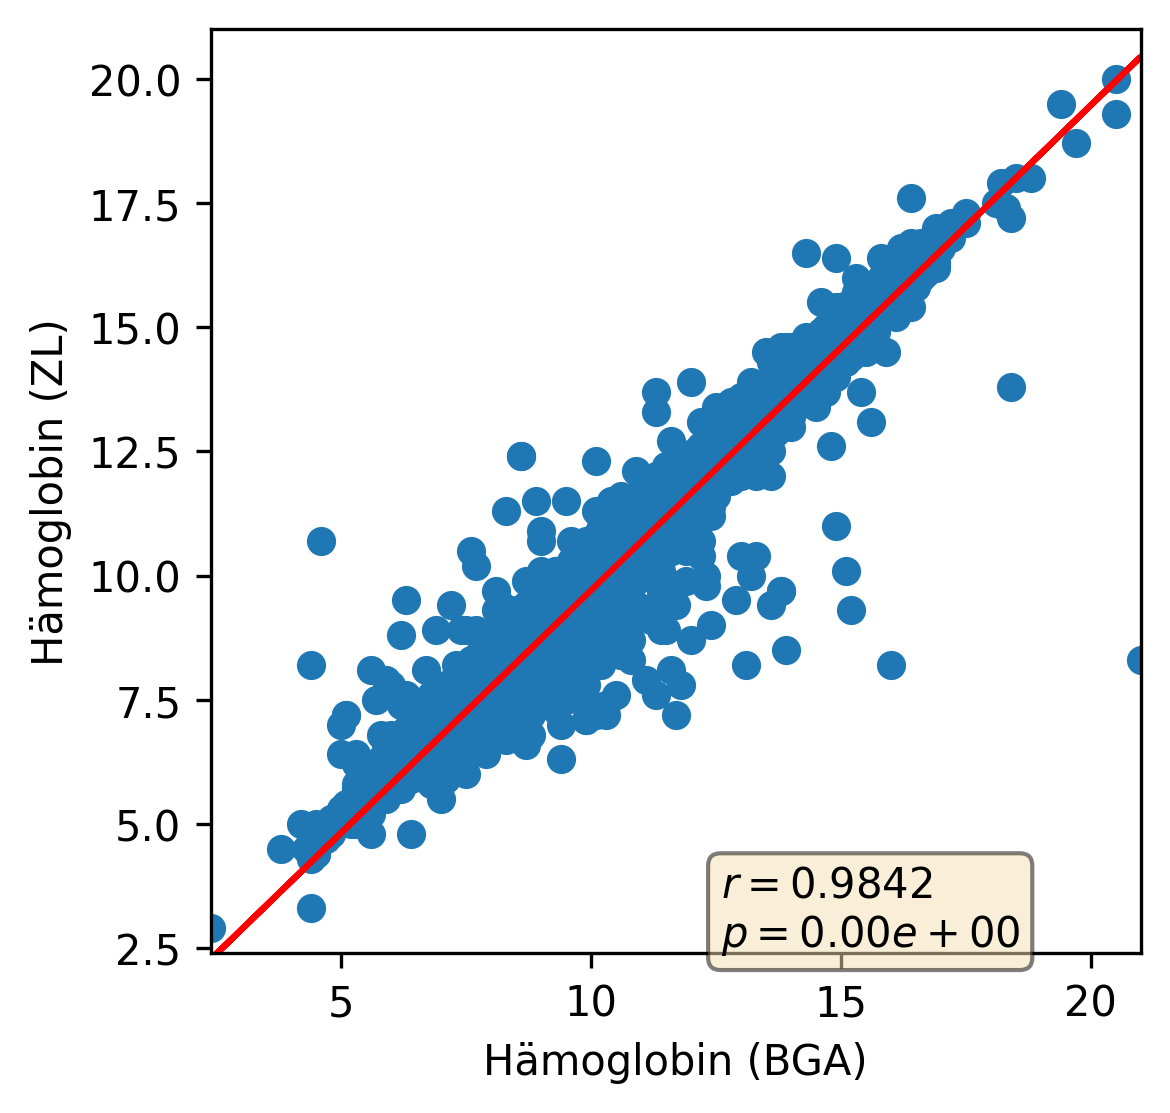

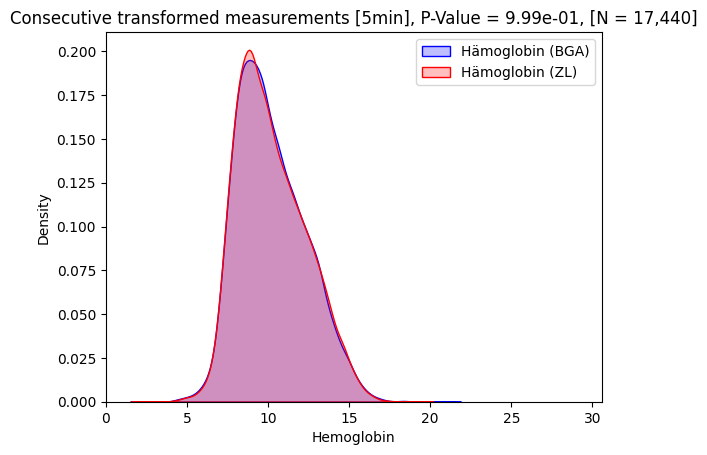

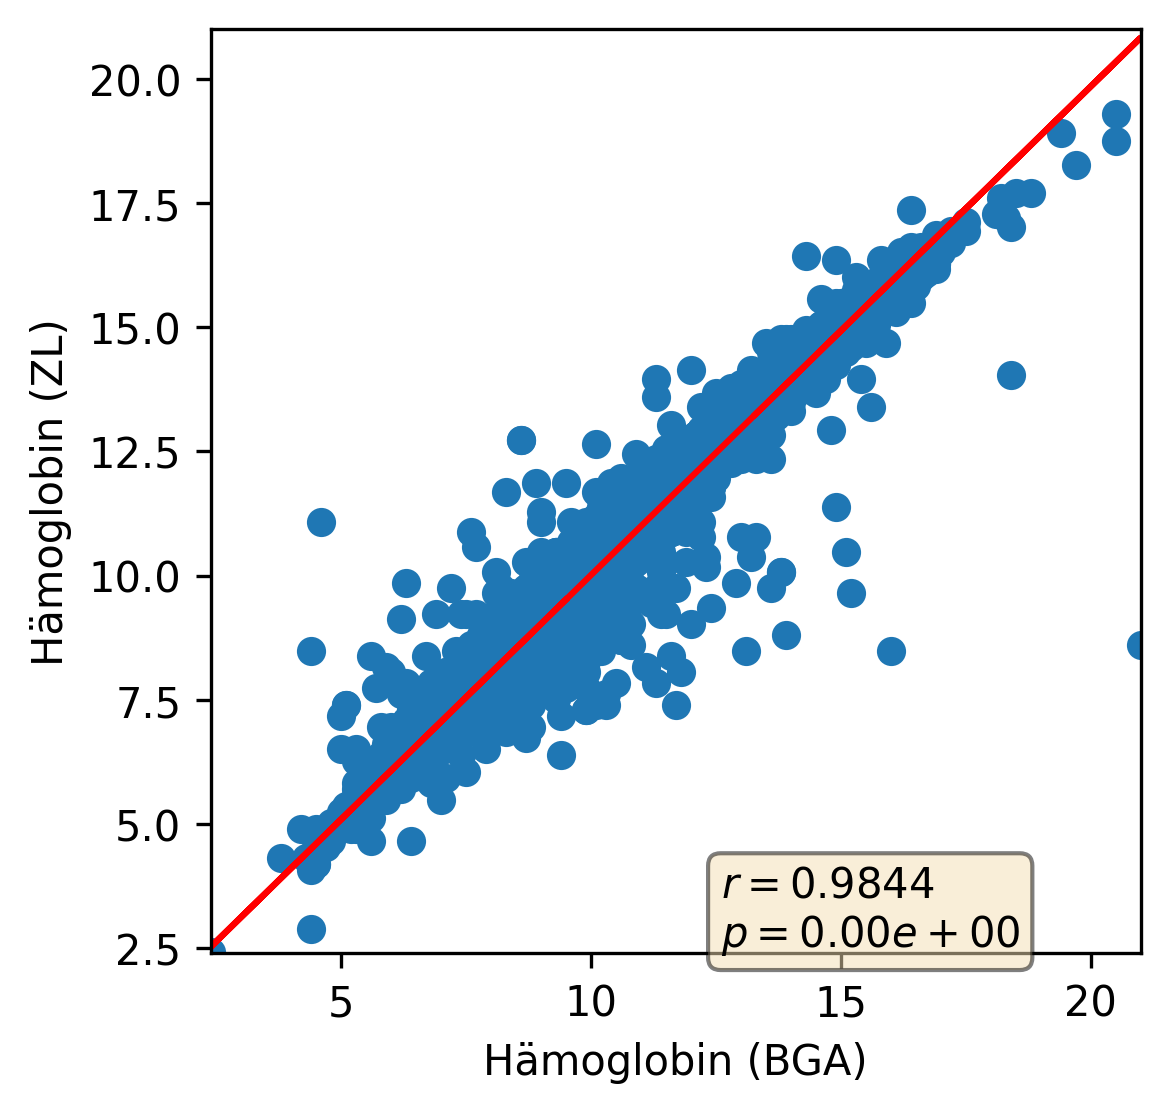

Feature:Hemoglobin, T=10


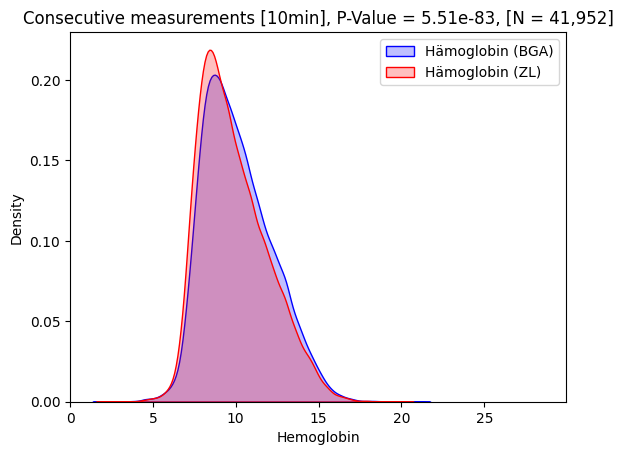

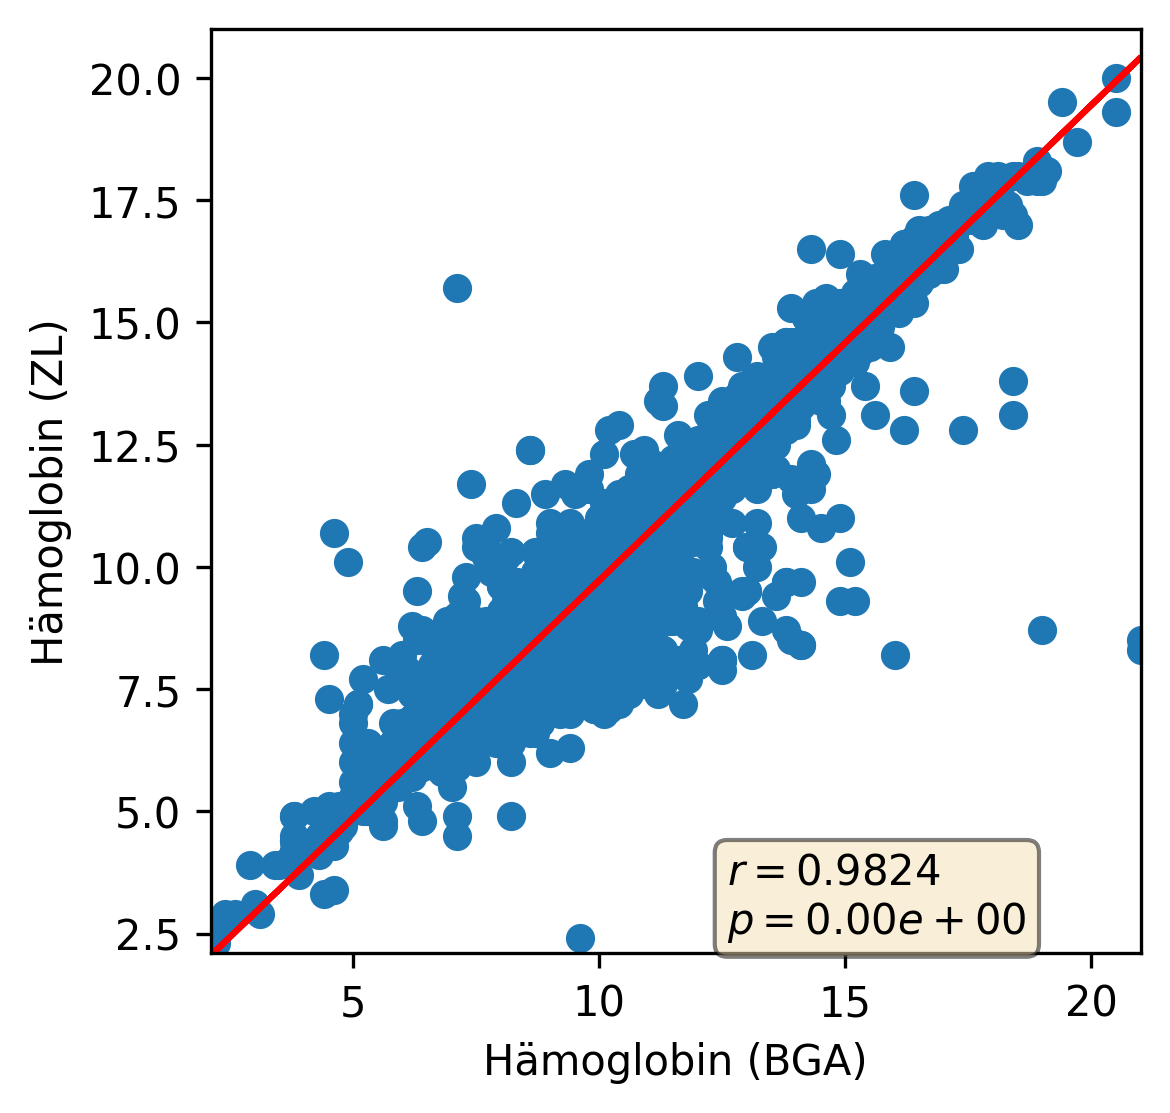

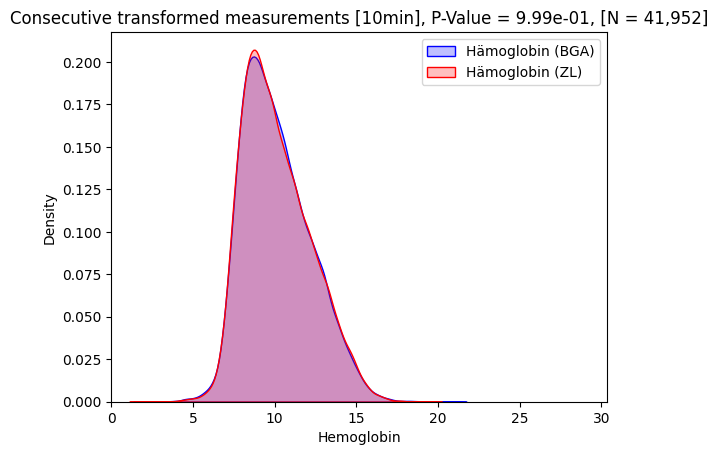

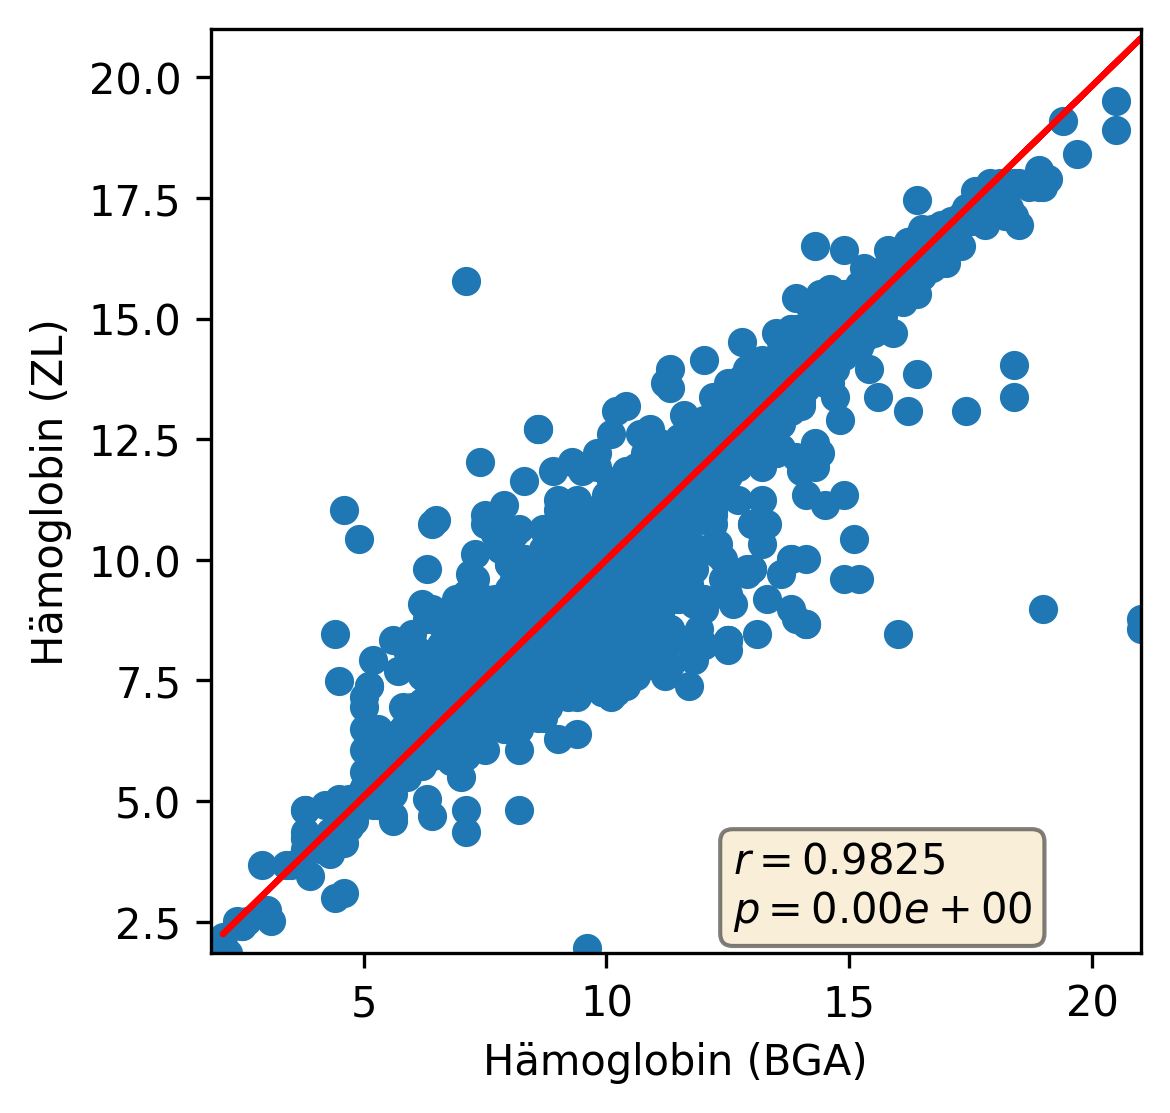

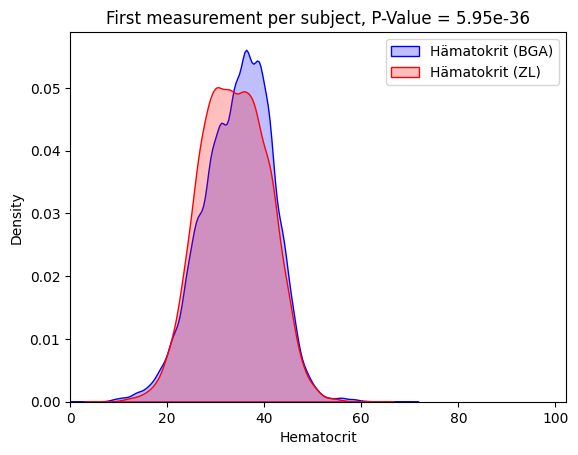

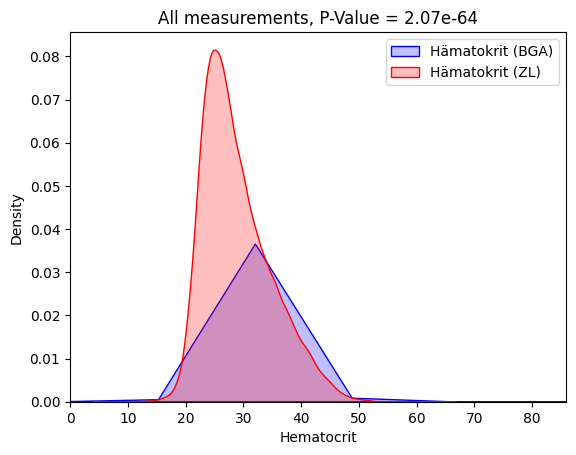

Feature:Hematocrit, T=5


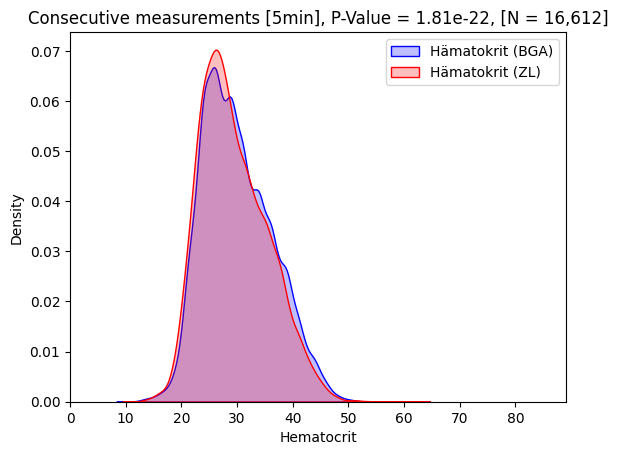

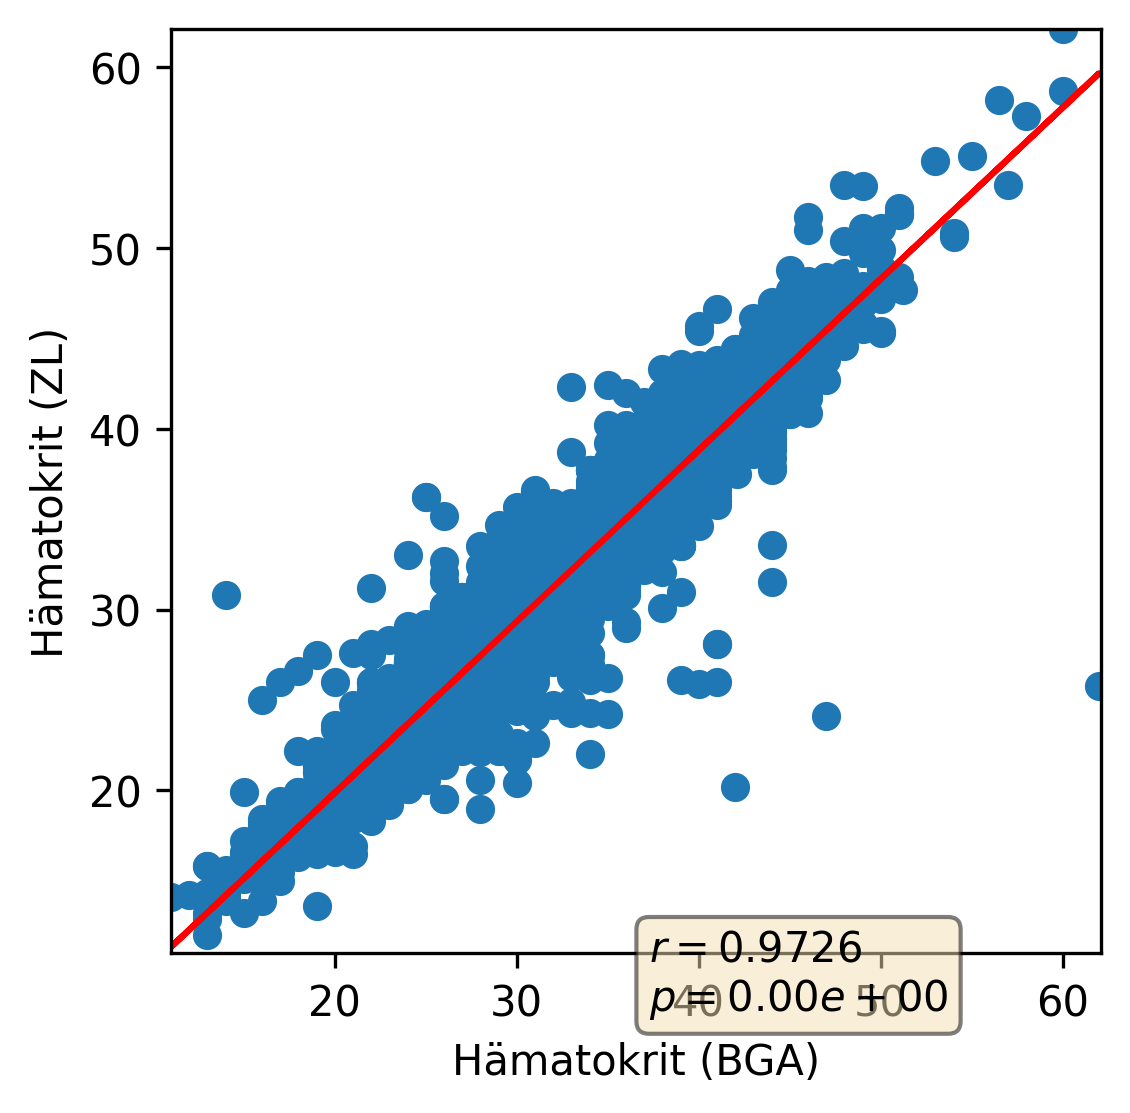

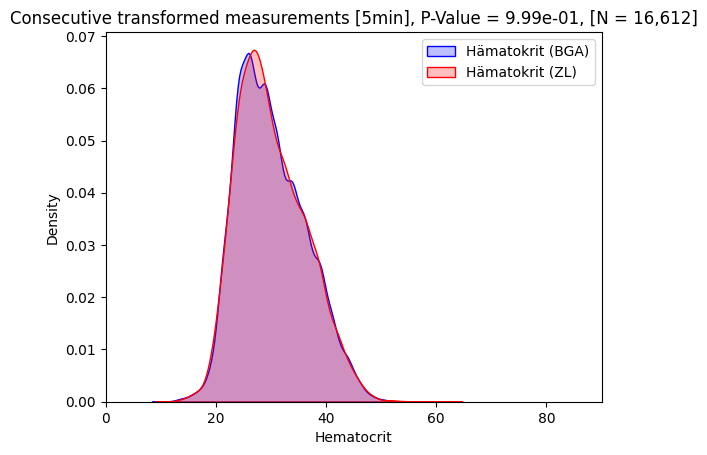

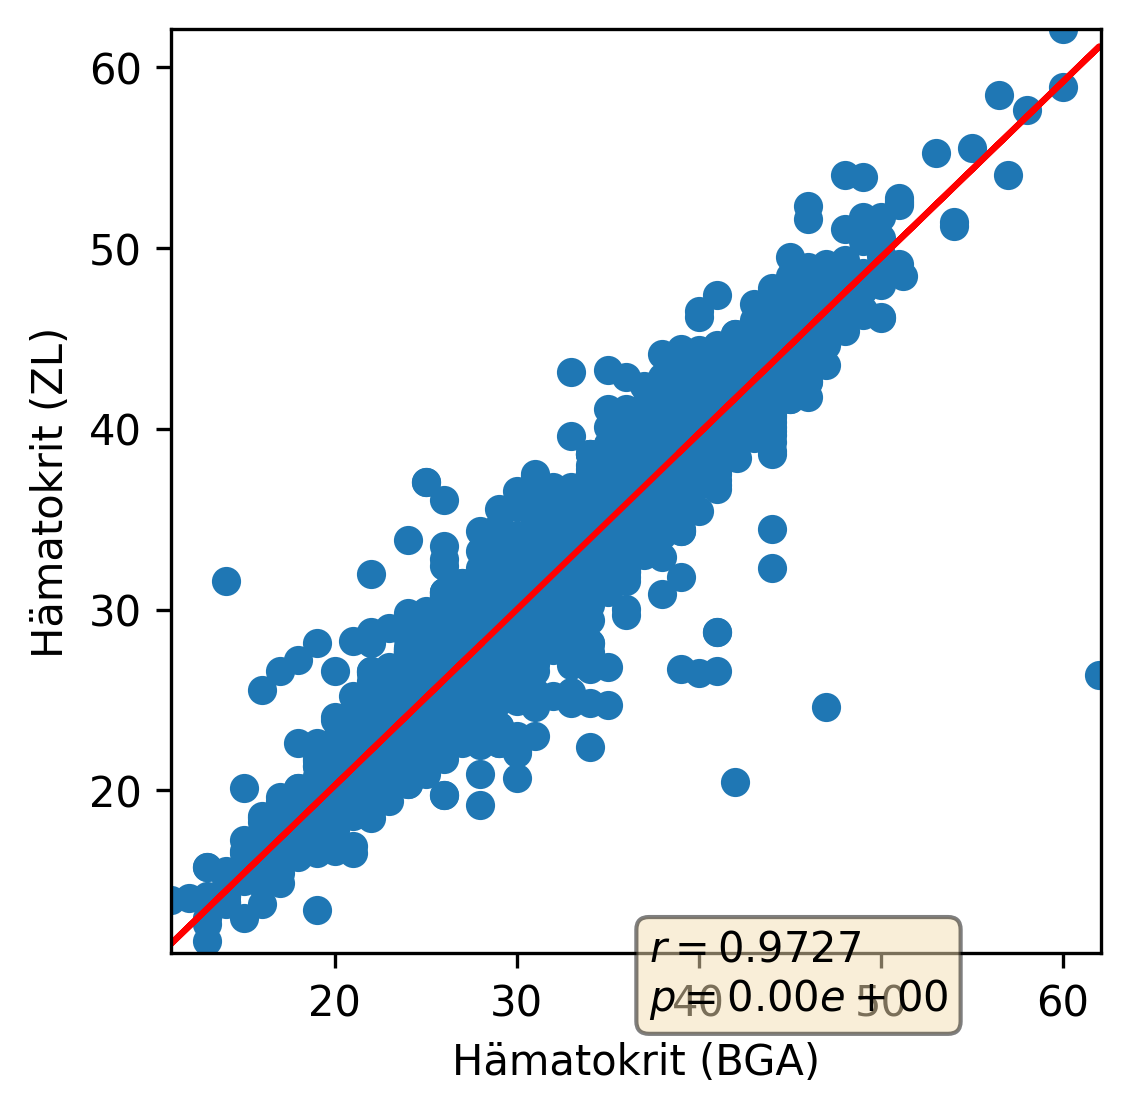

Feature:Hematocrit, T=10


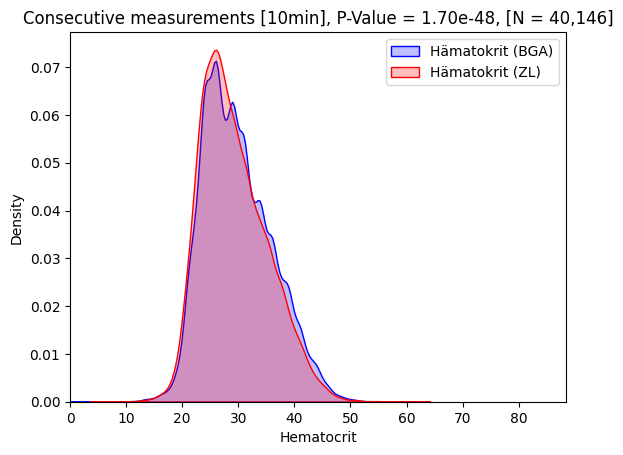

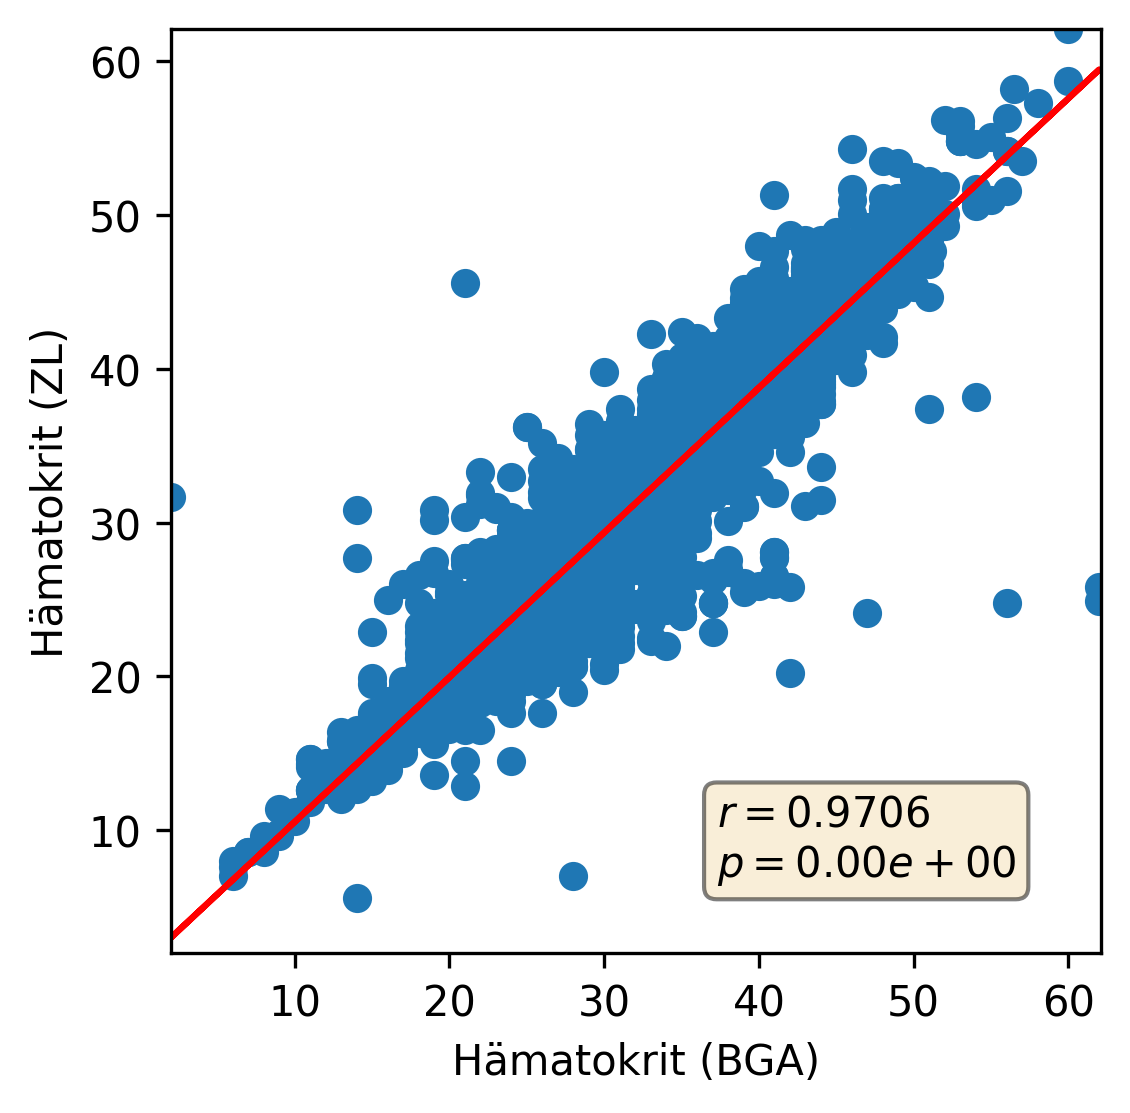

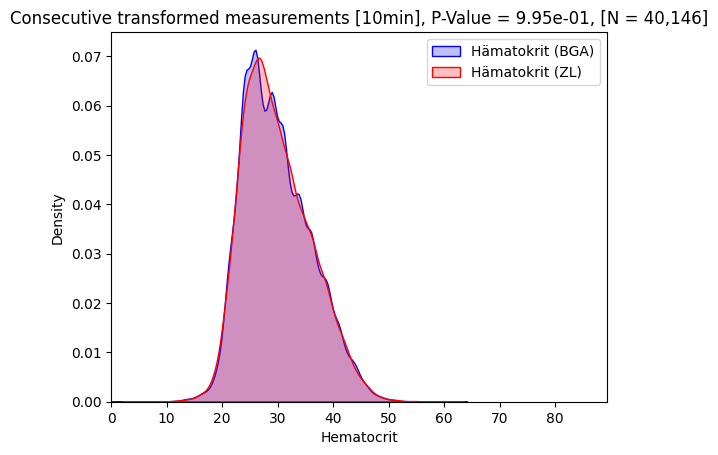

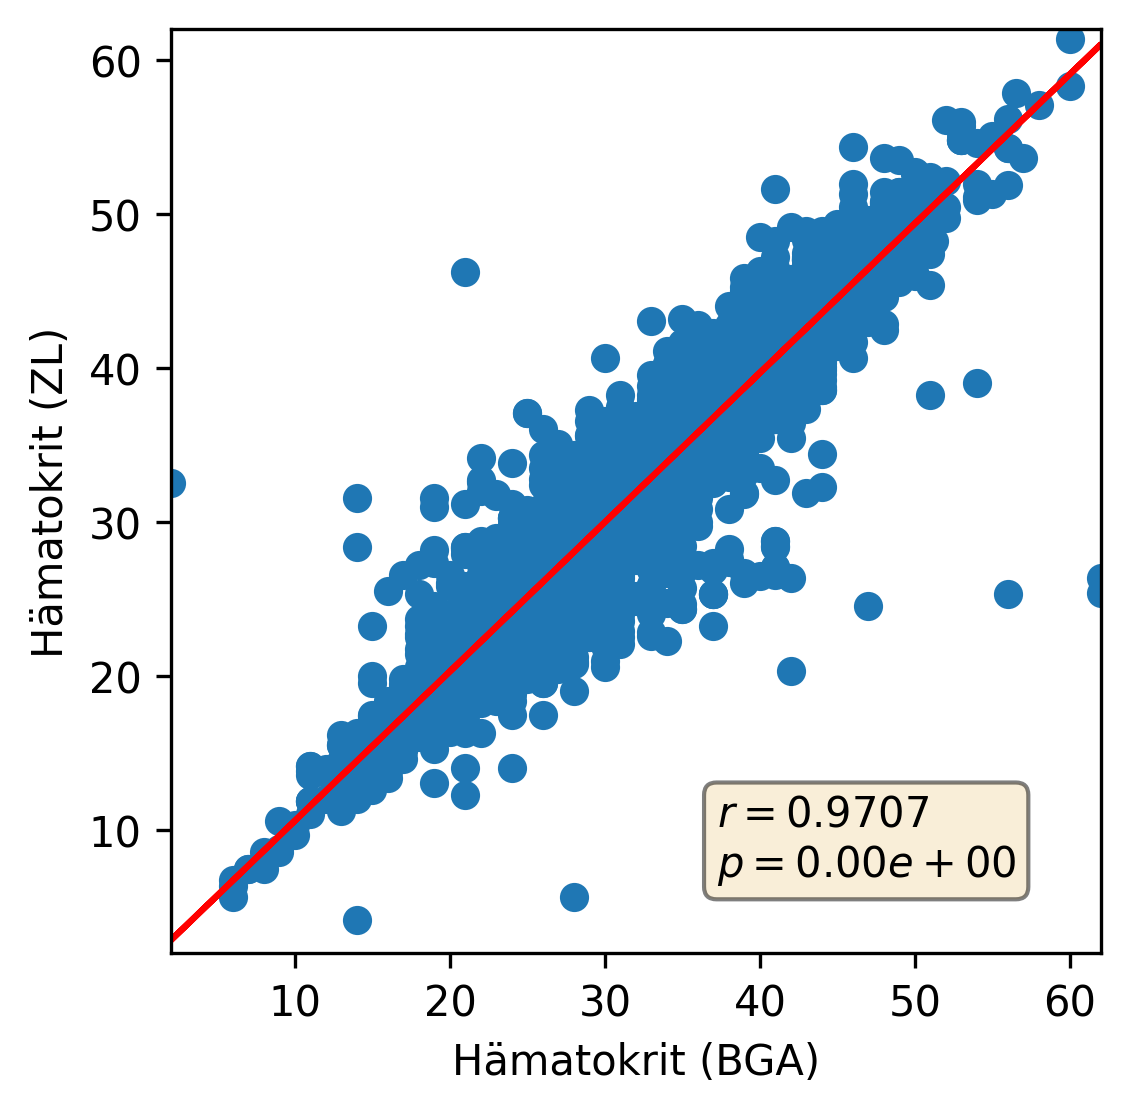

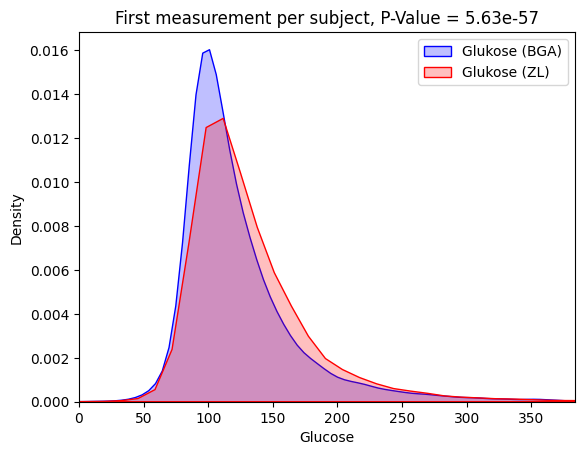

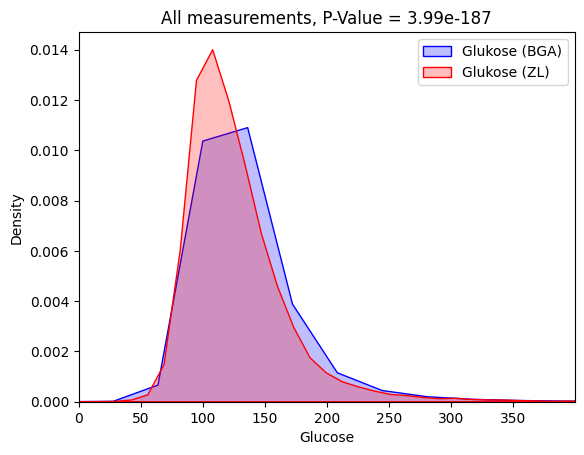

Feature:Glucose, T=5


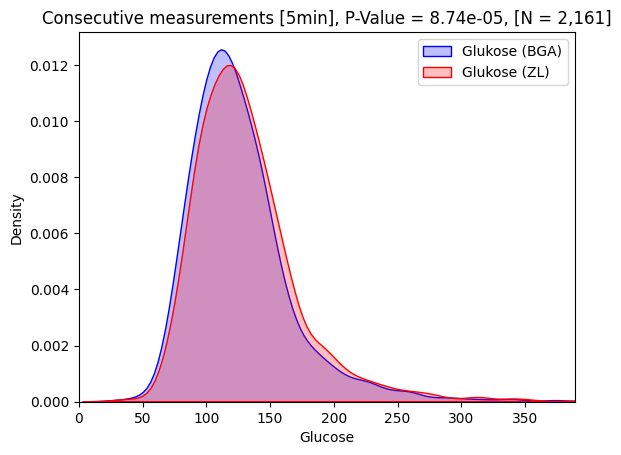

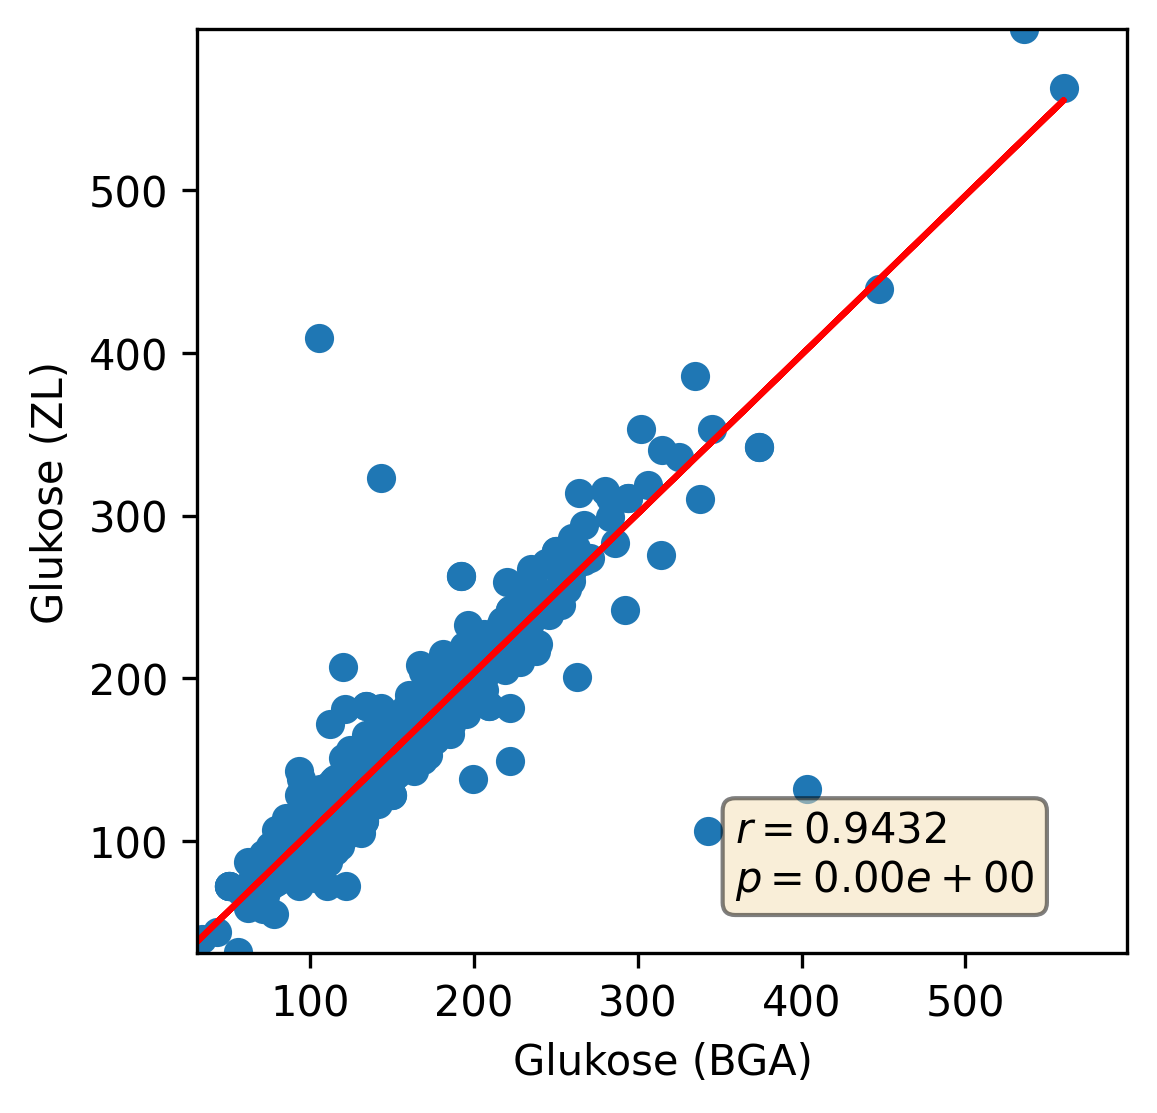

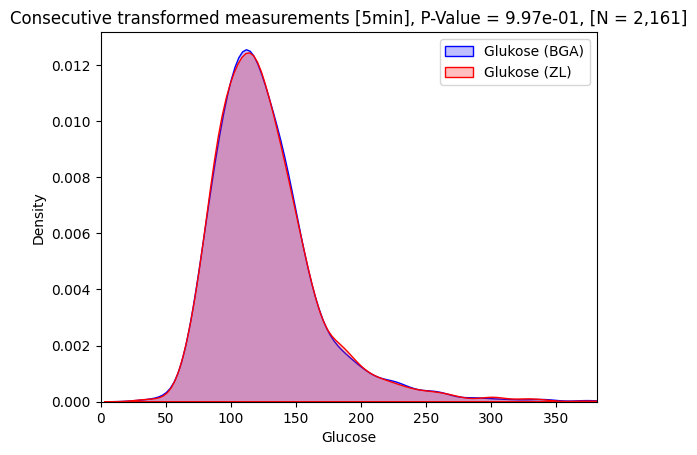

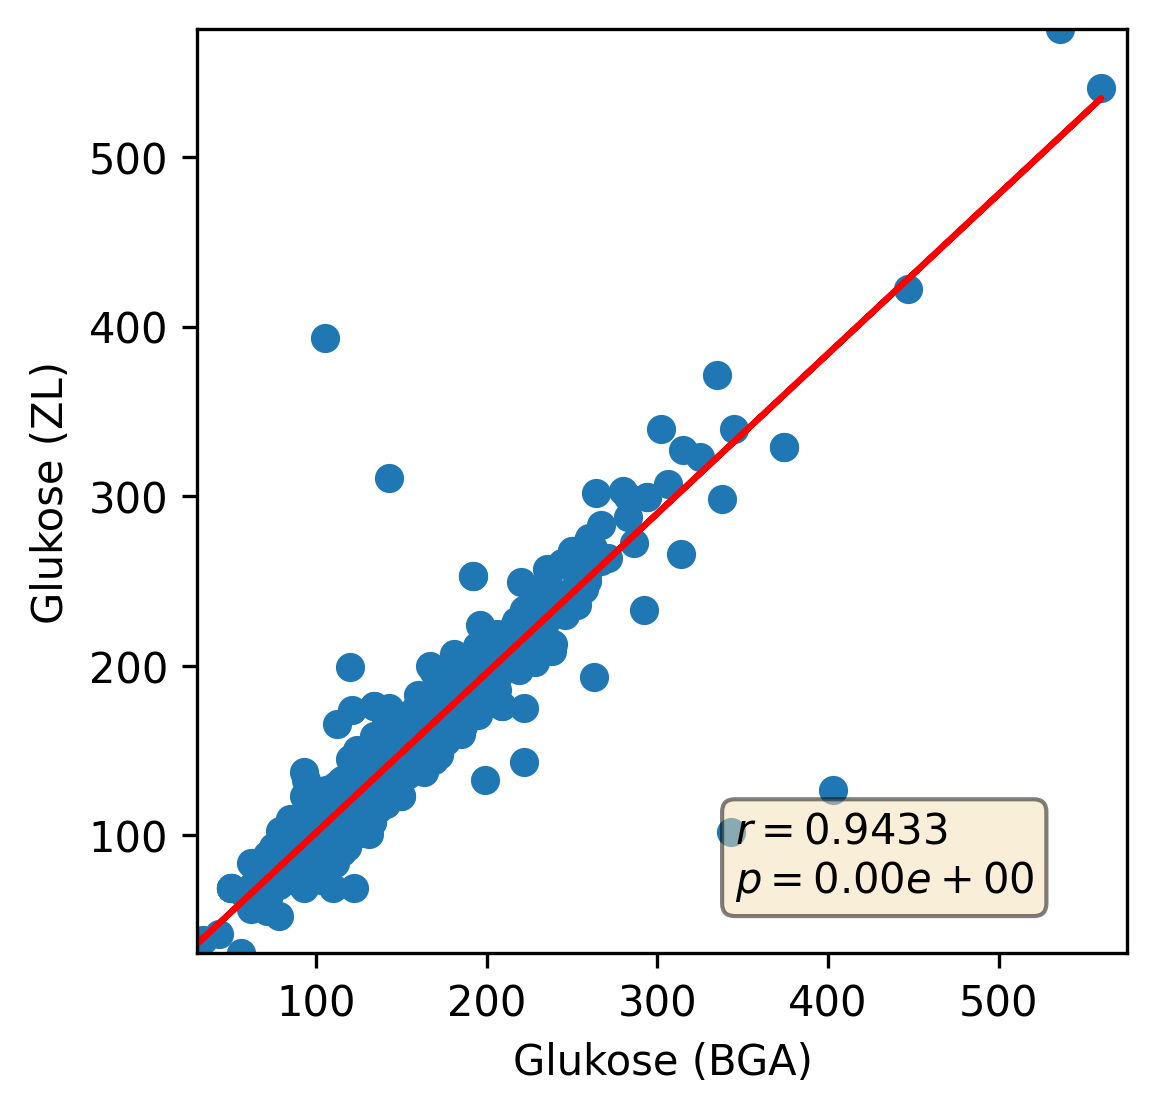

Feature:Glucose, T=10


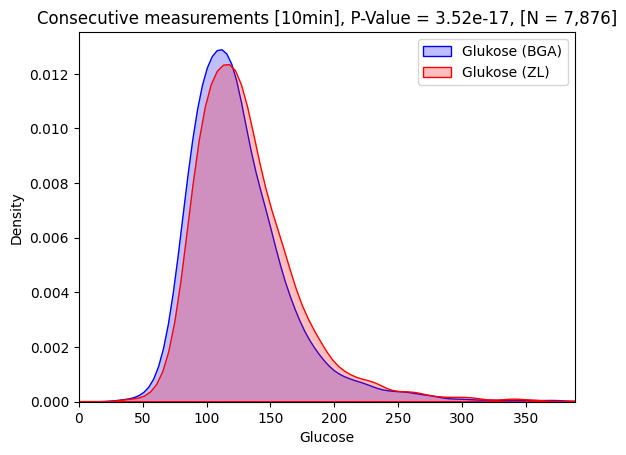

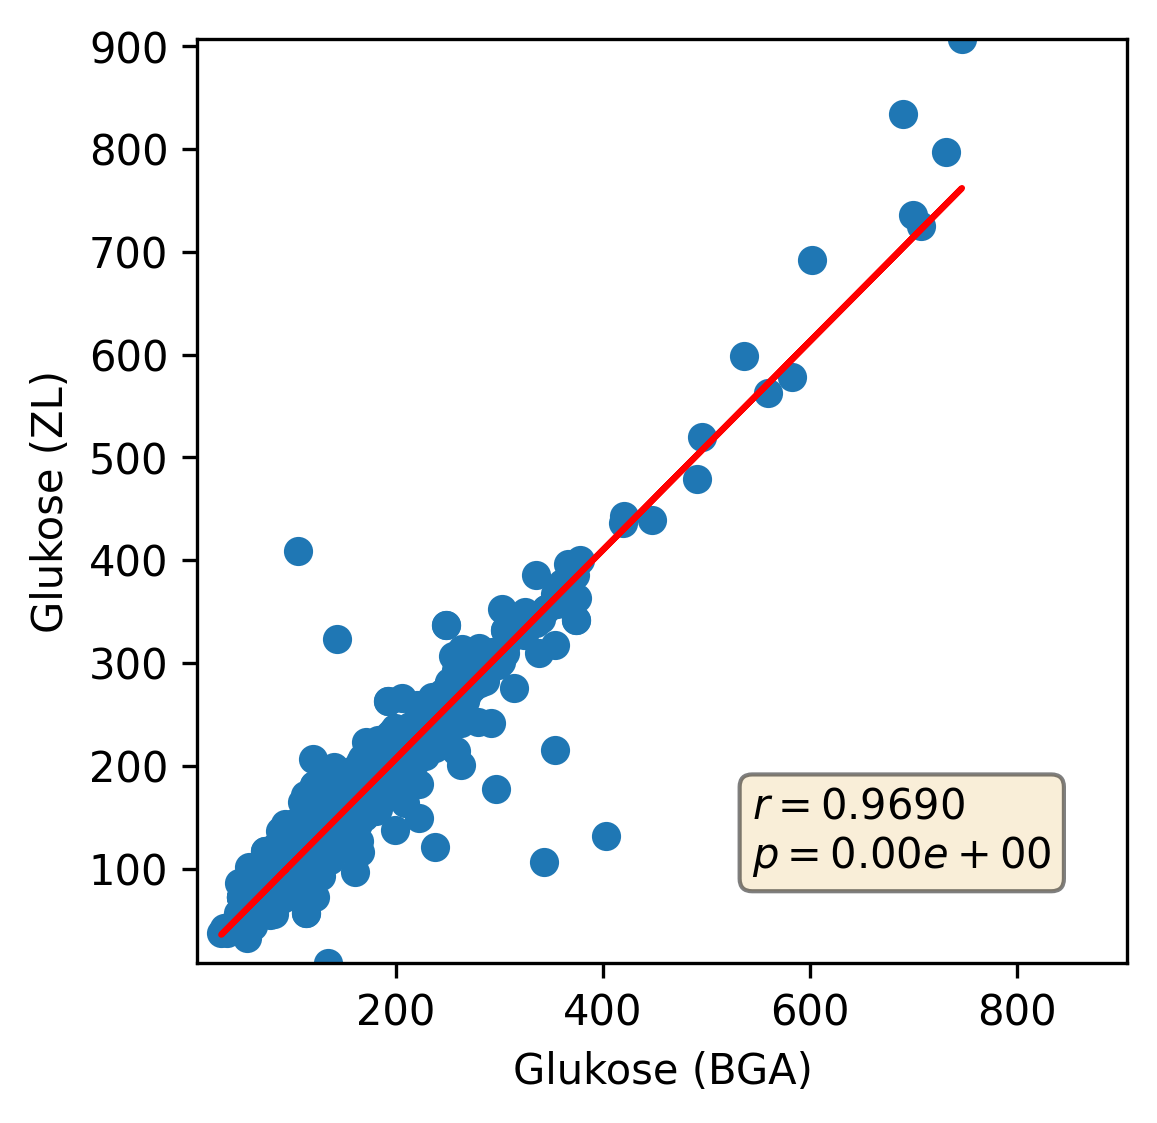

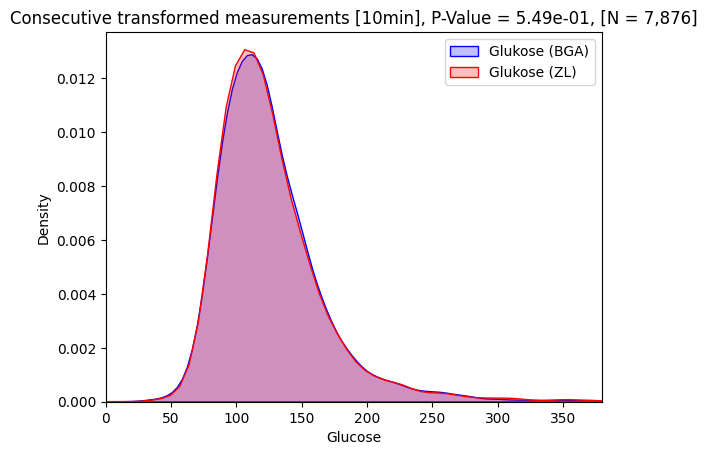

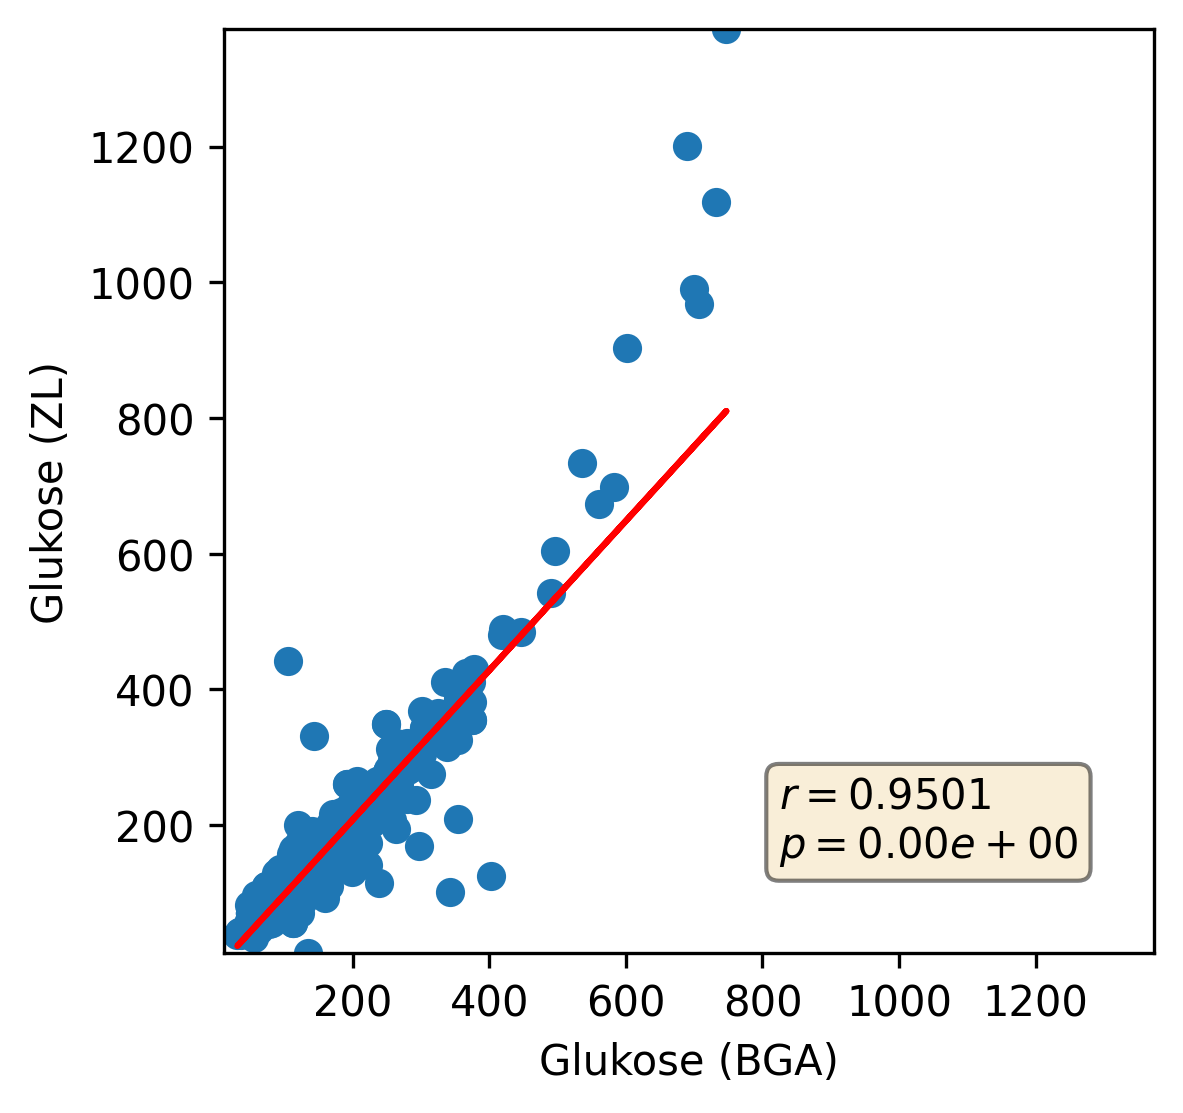

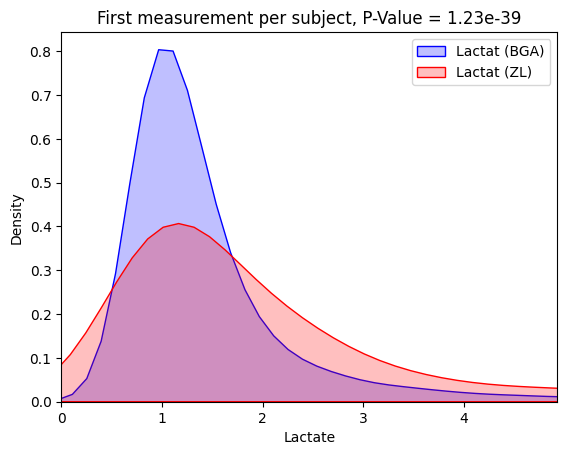

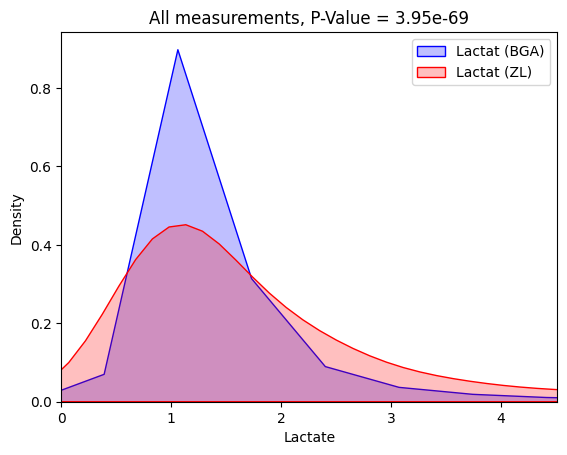

Feature:Lactate, T=5


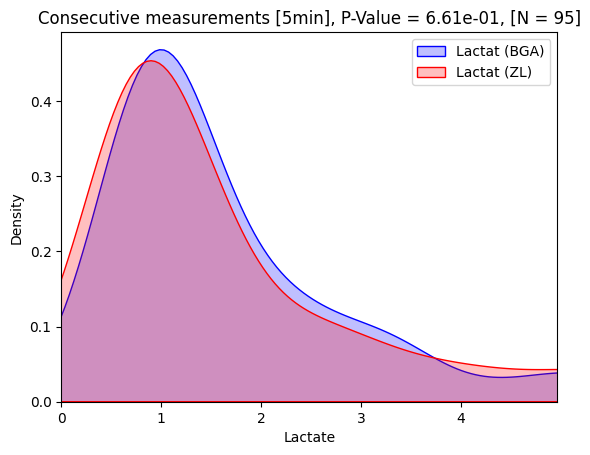

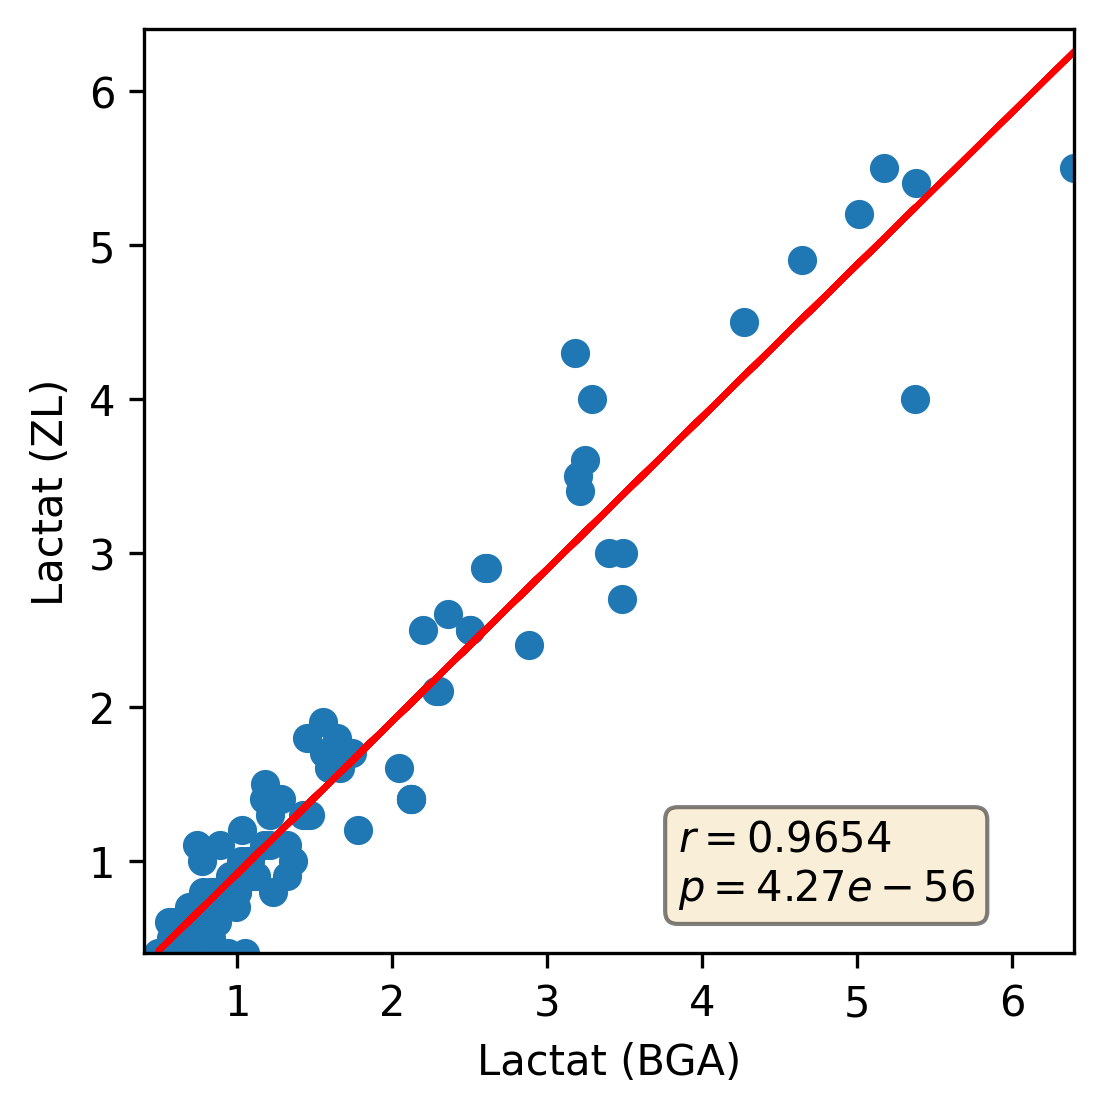

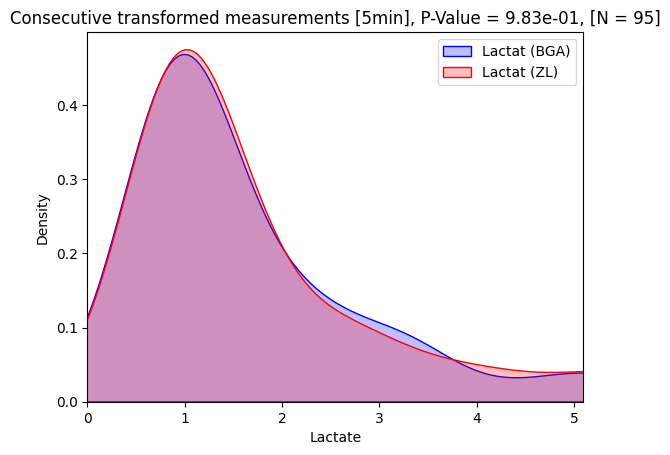

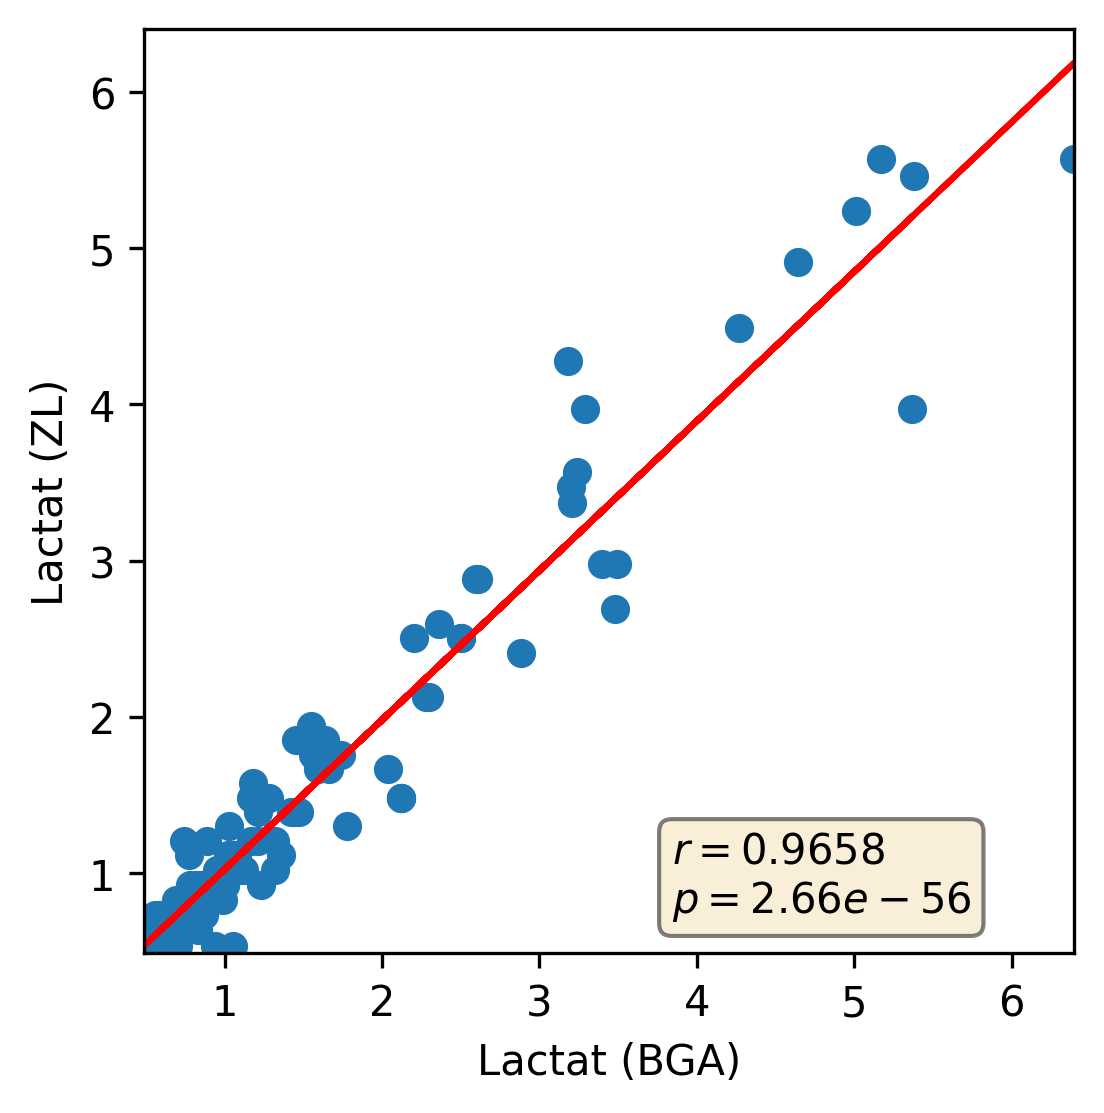

Feature:Lactate, T=10


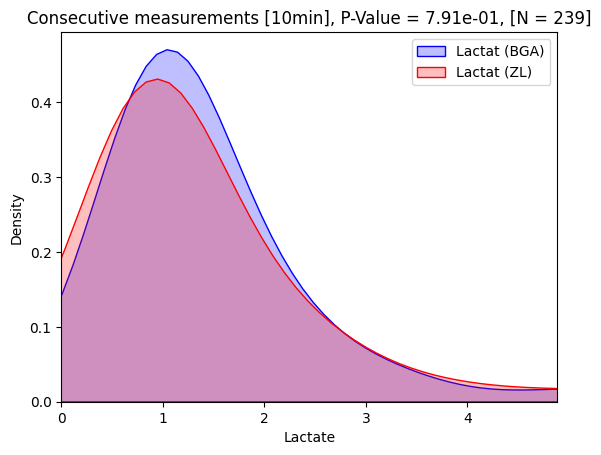

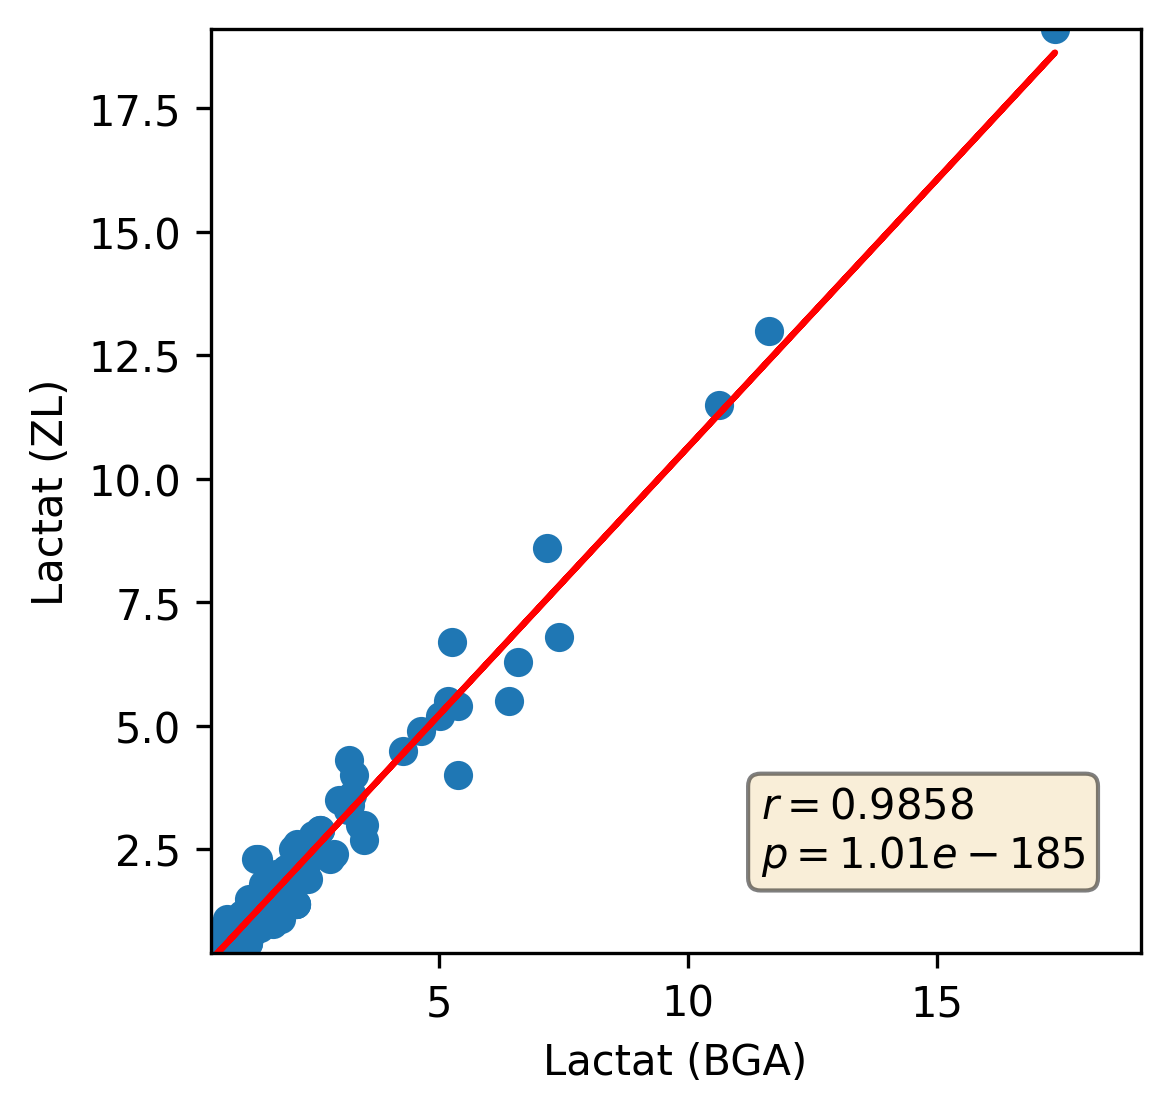

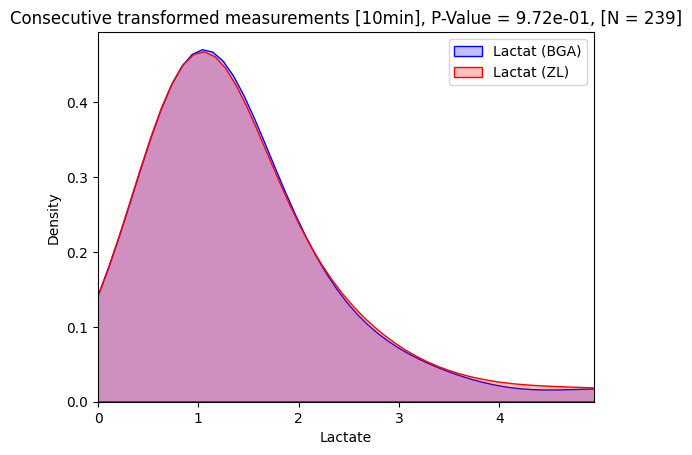

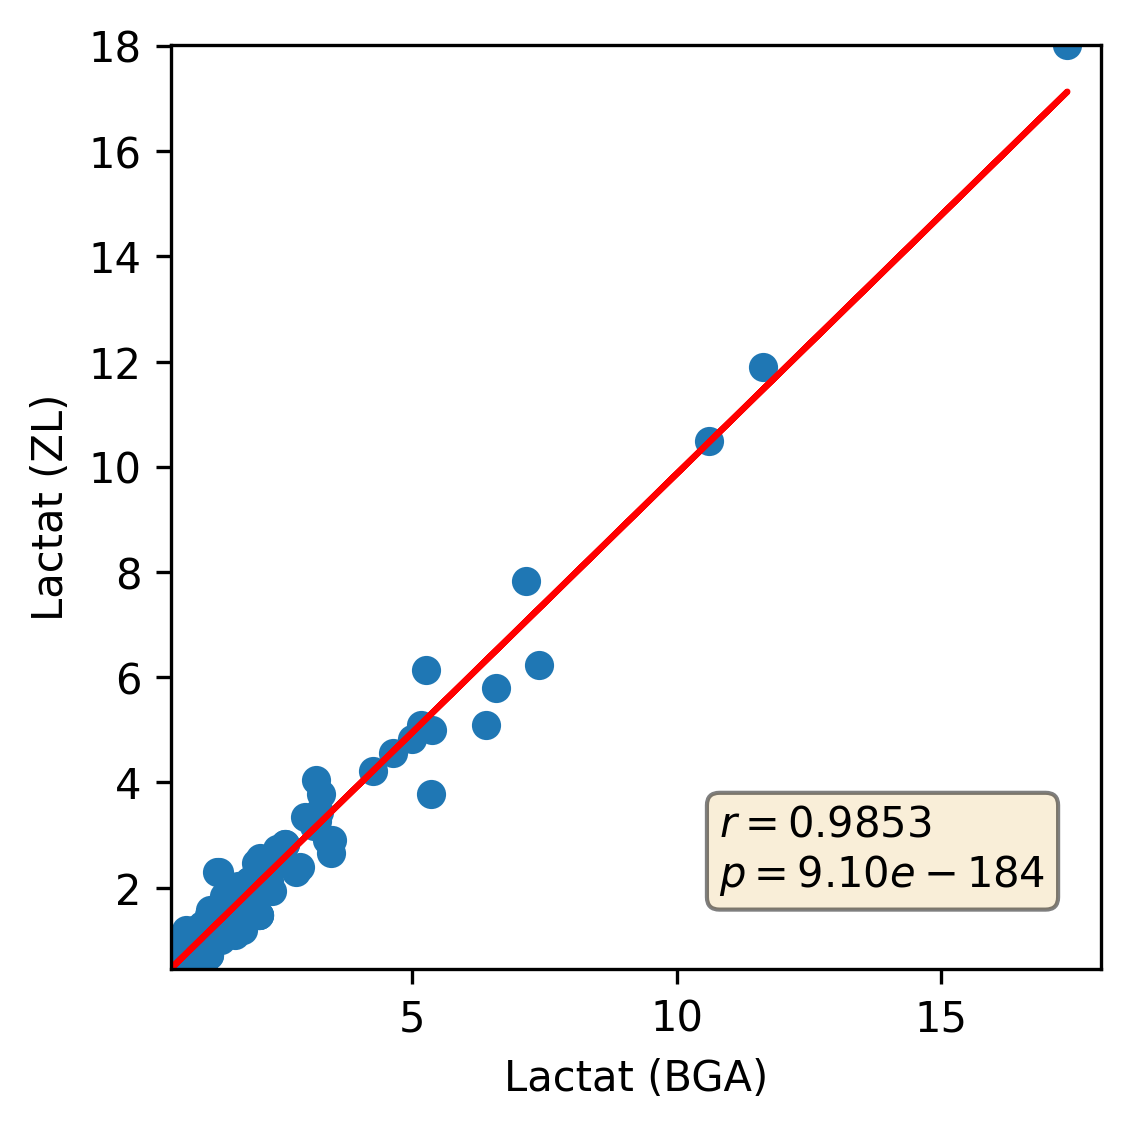

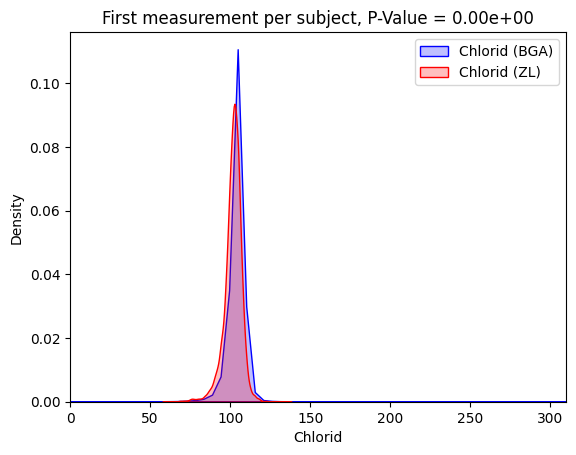

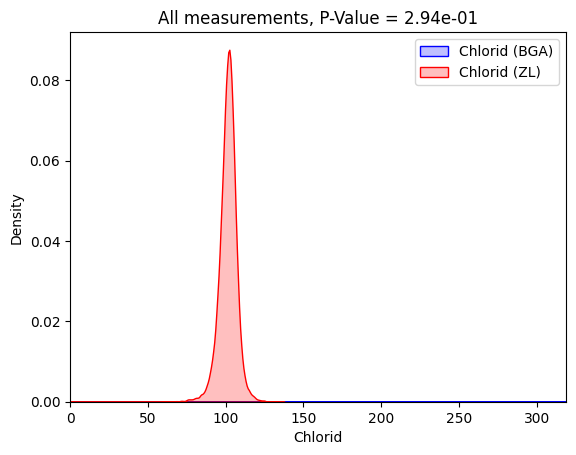

Feature:Chlorid, T=5


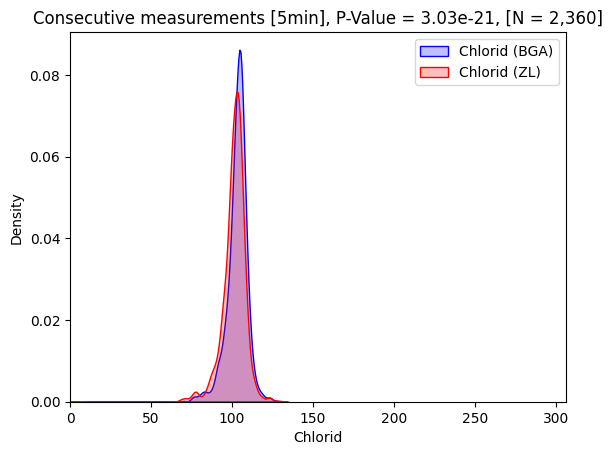

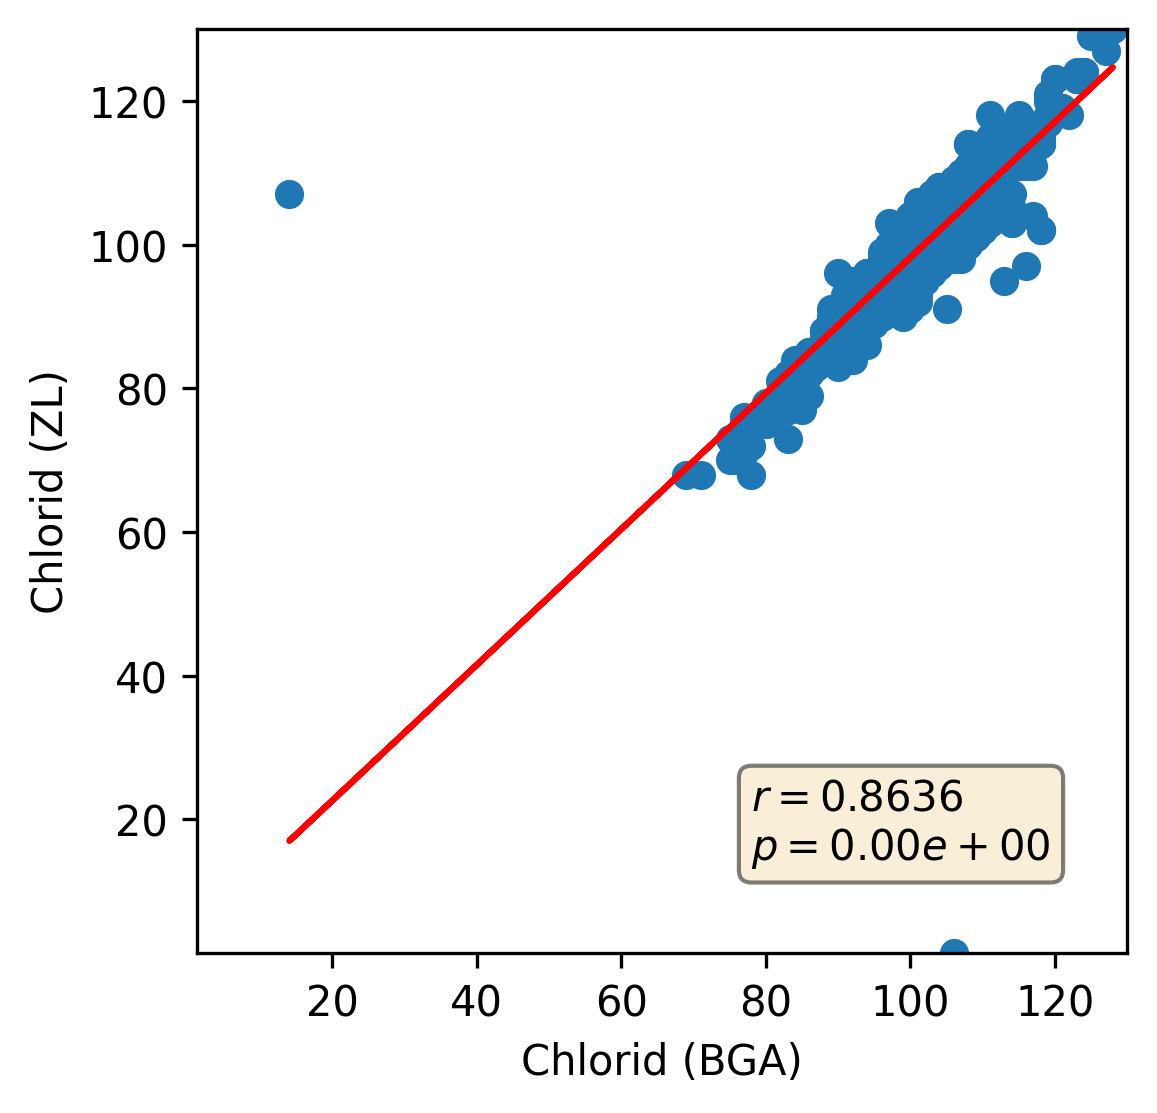

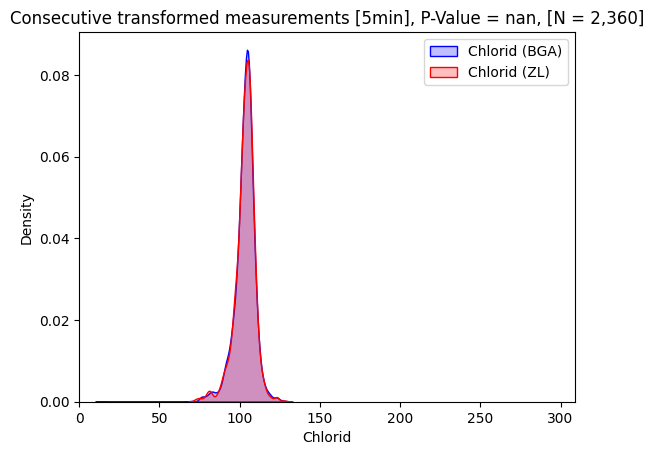

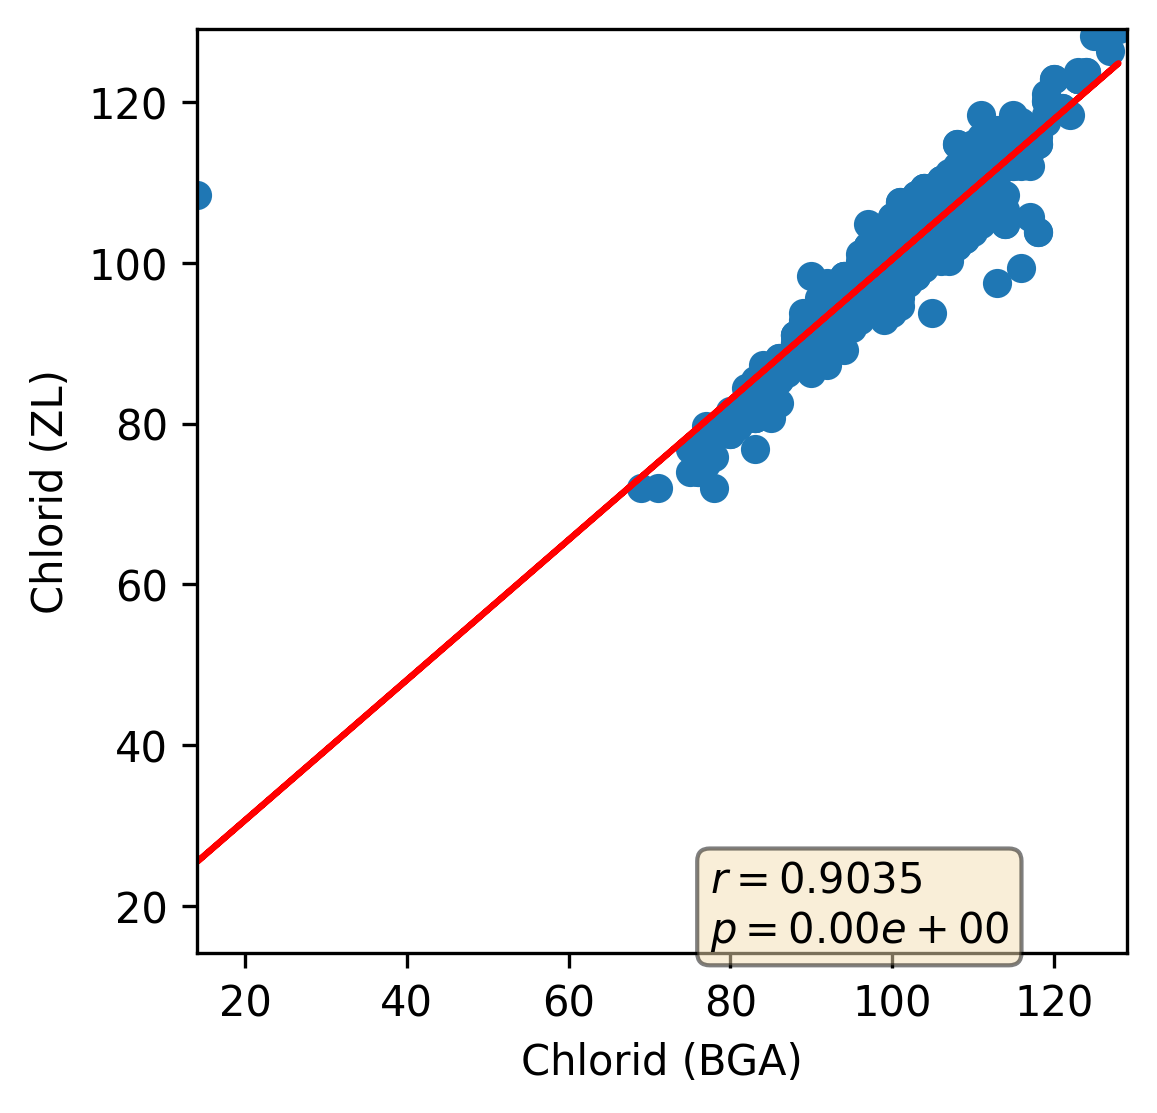

Feature:Chlorid, T=10


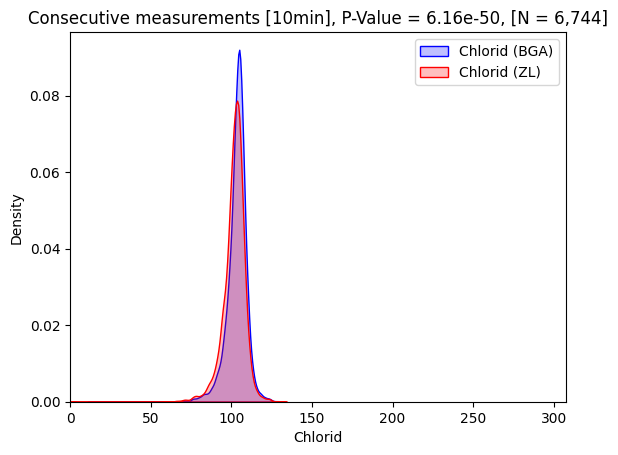

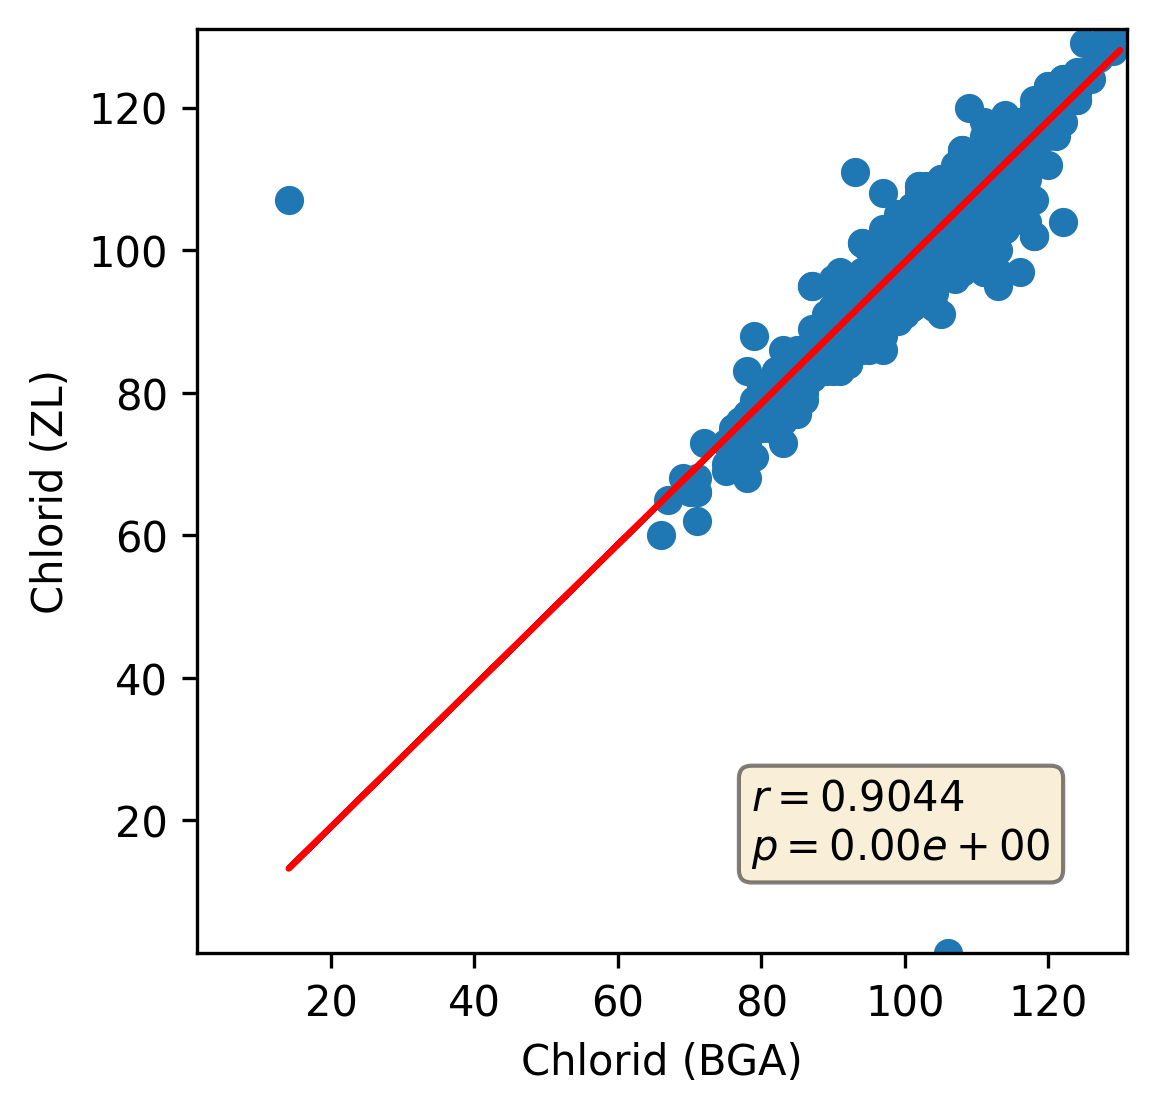

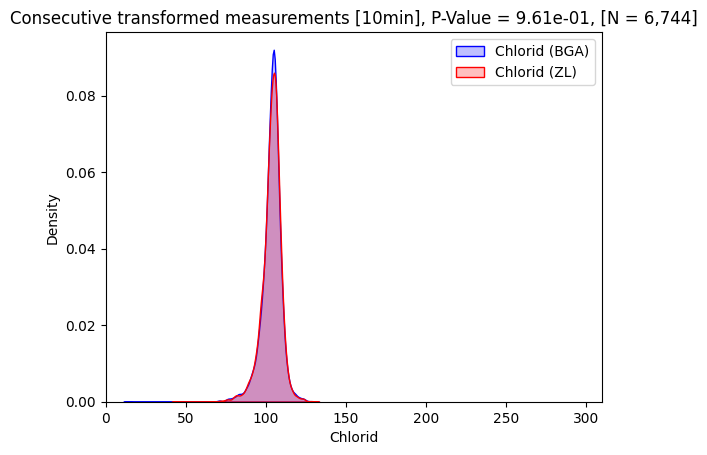

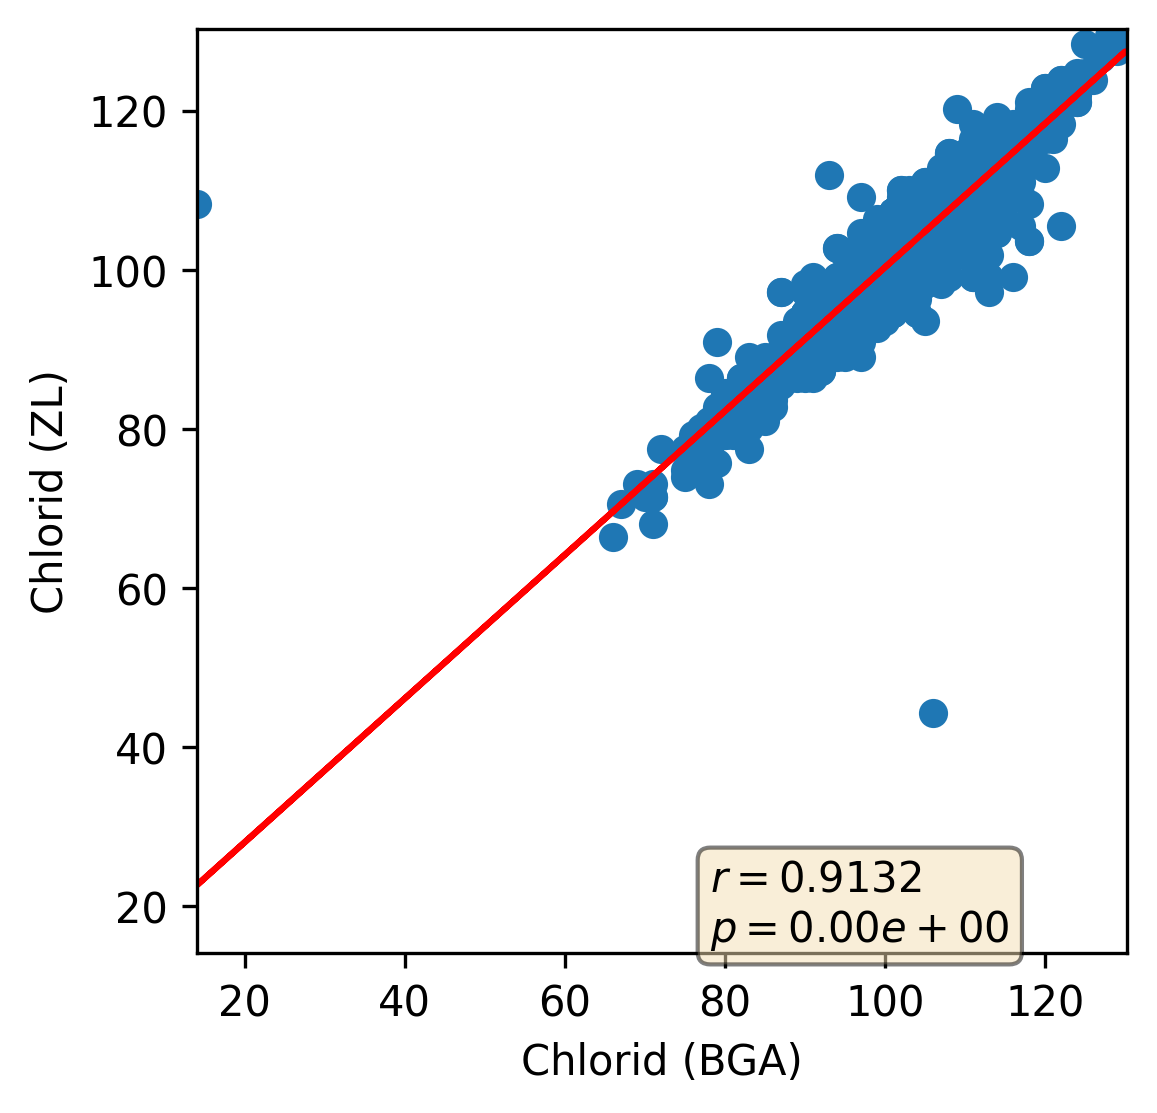

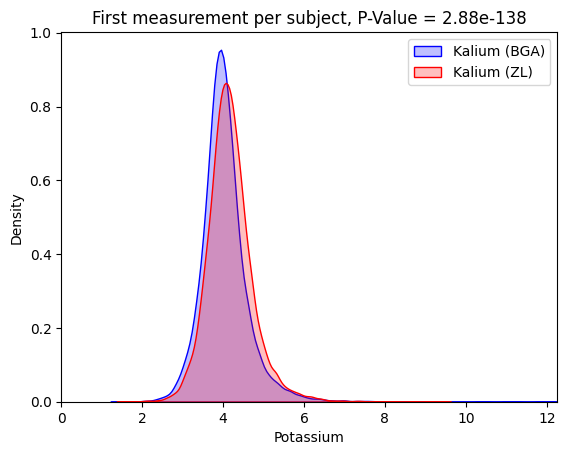

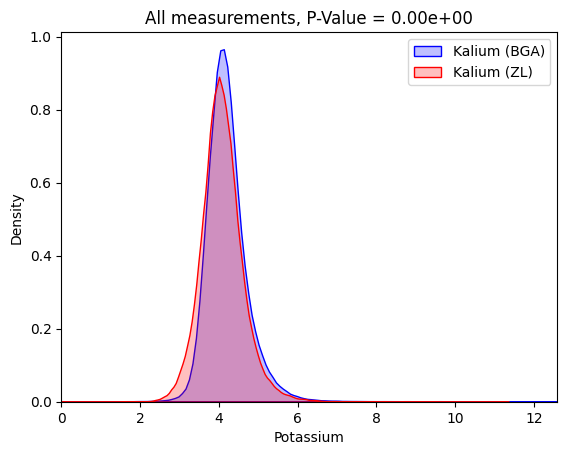

Feature:Potassium, T=5


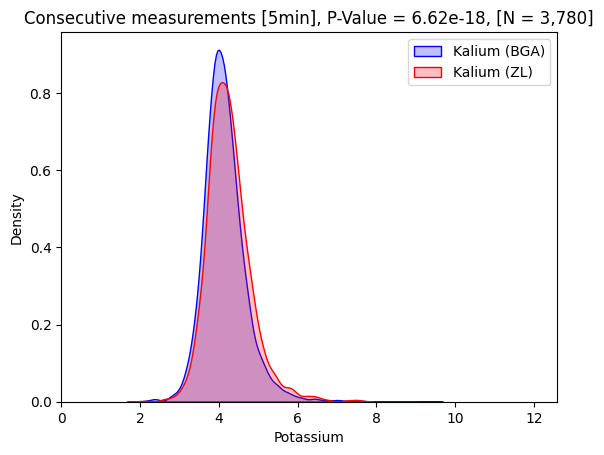

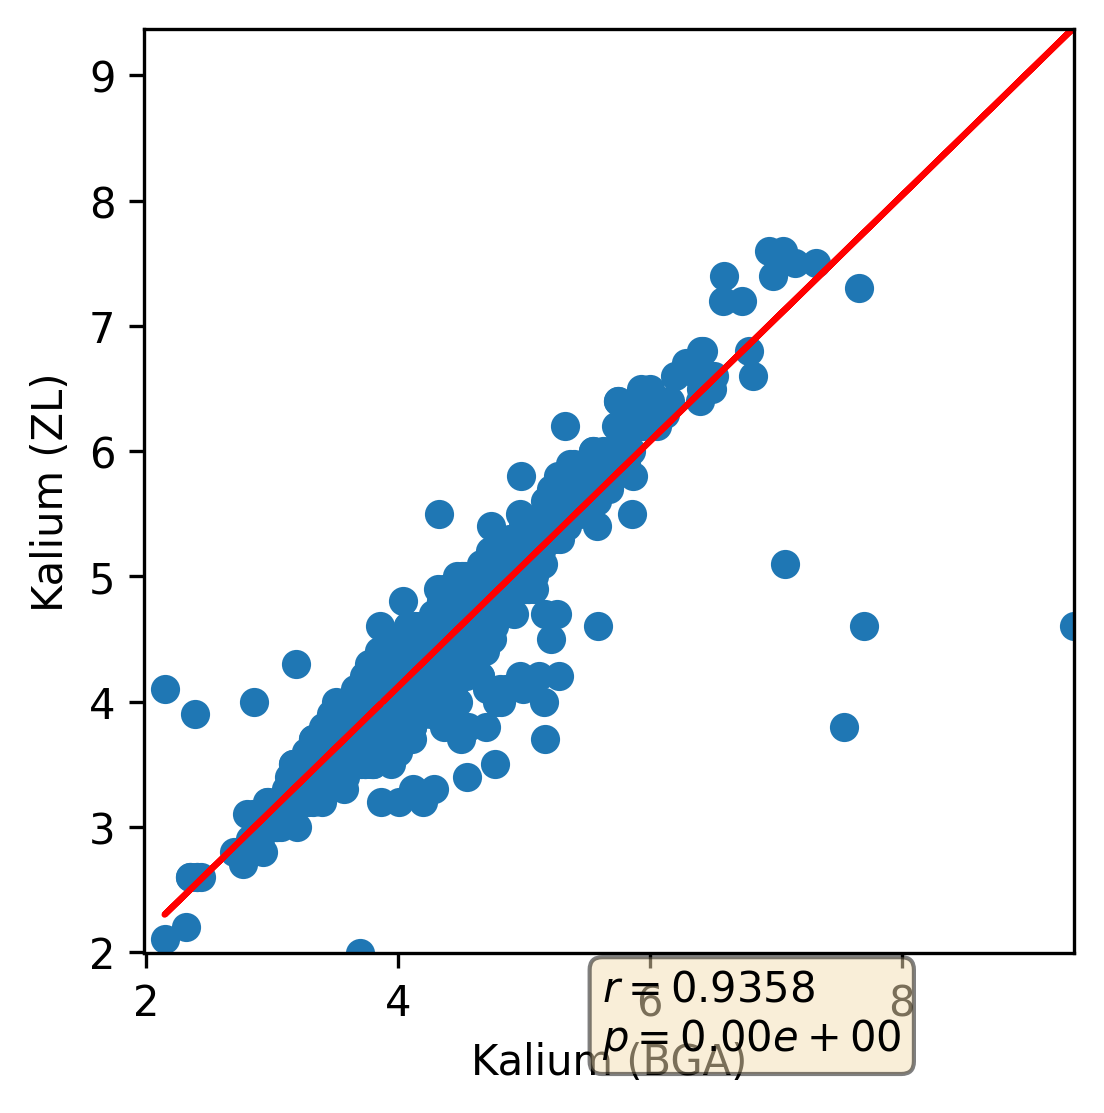

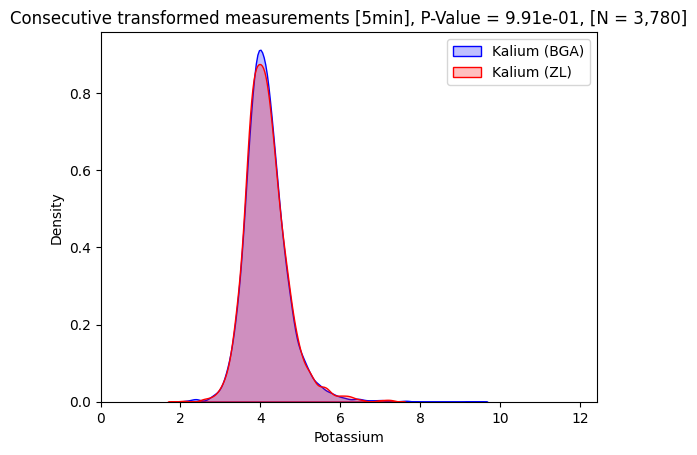

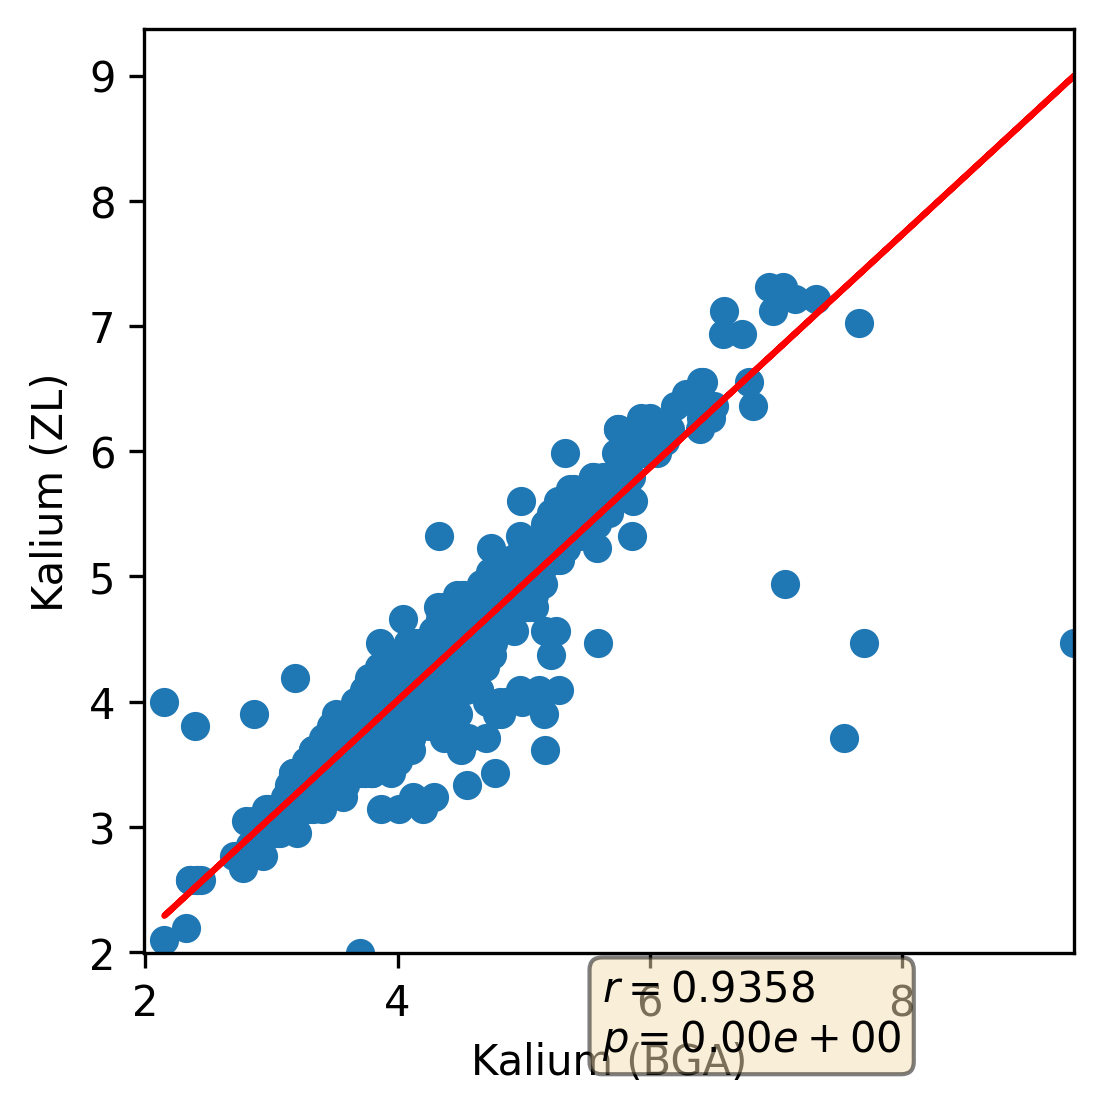

Feature:Potassium, T=10


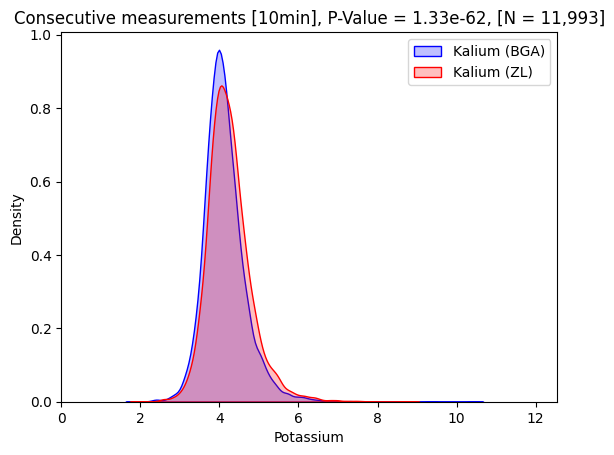

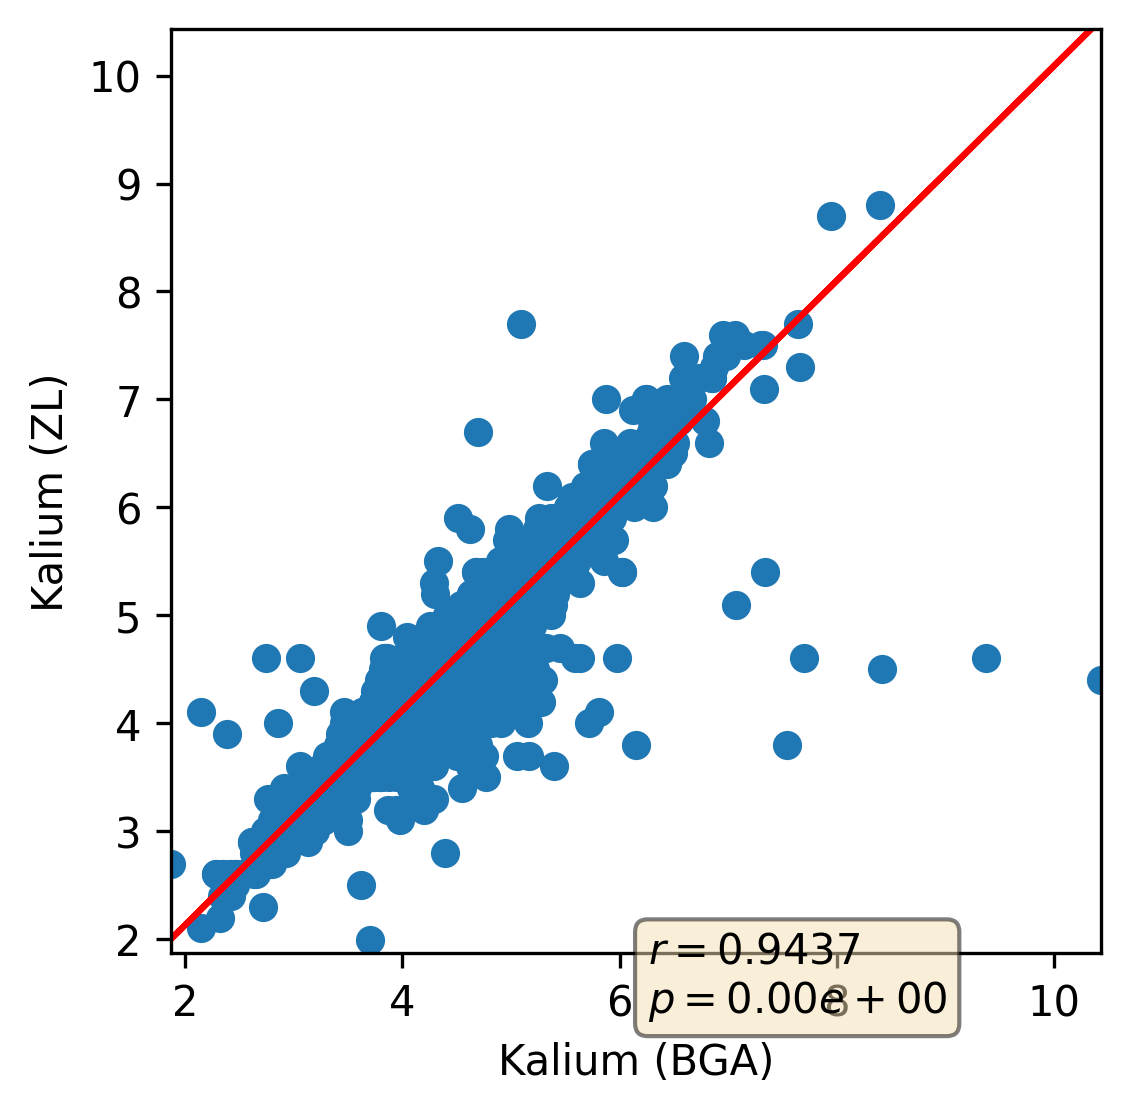

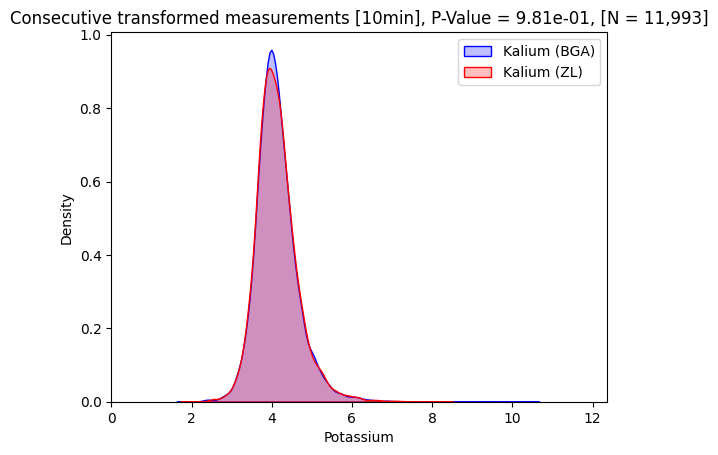

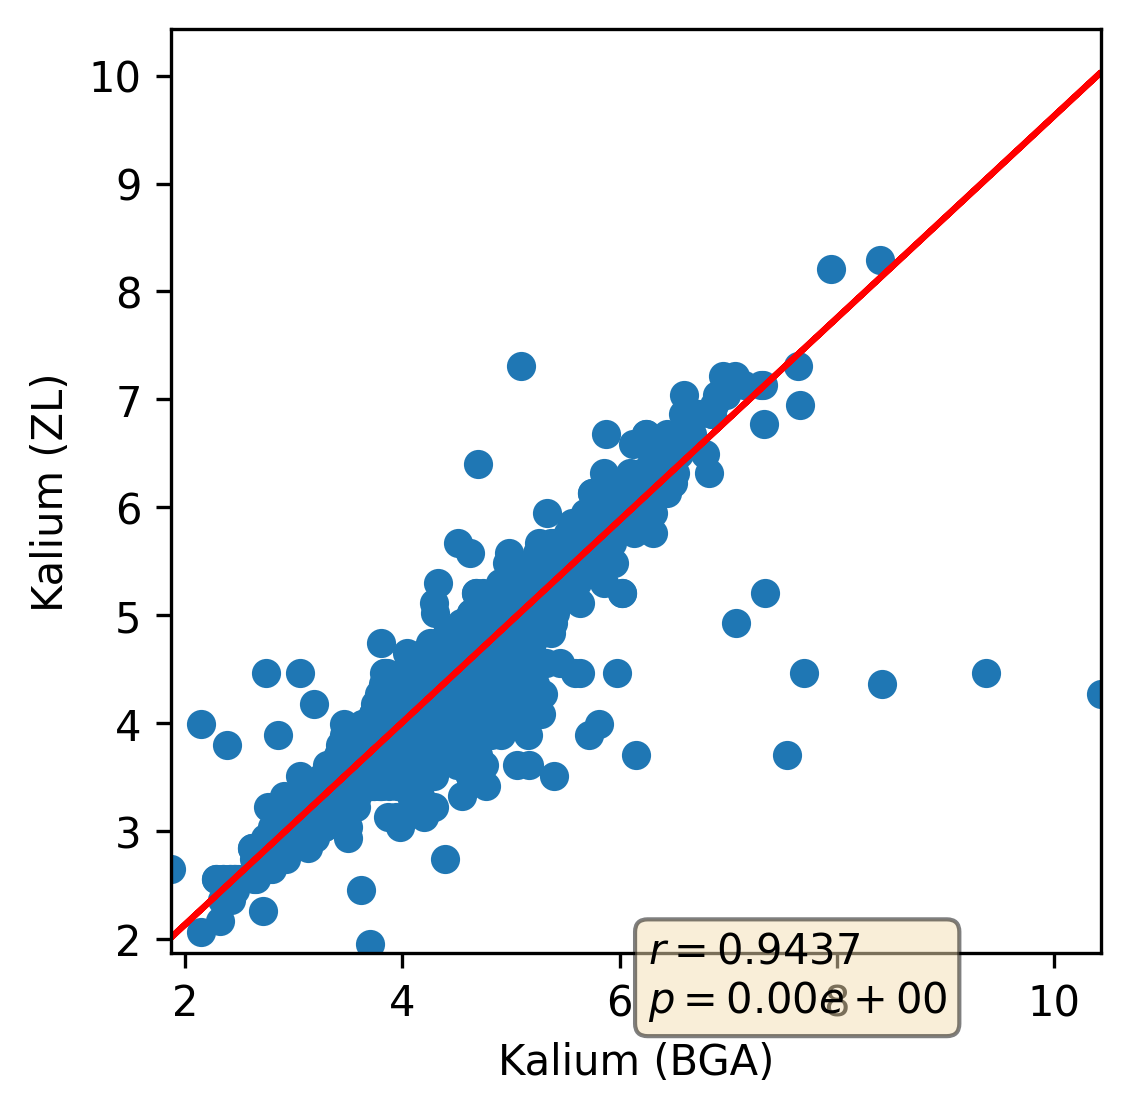

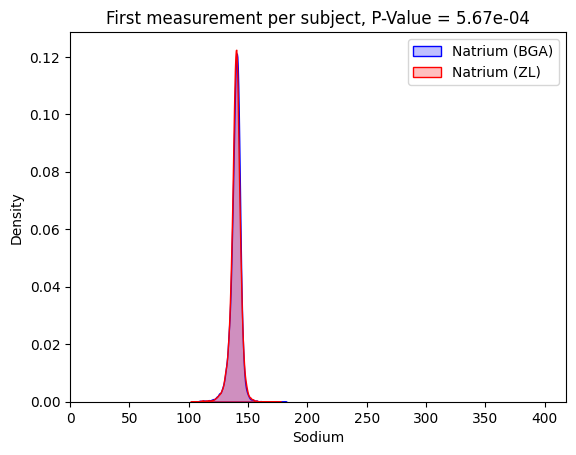

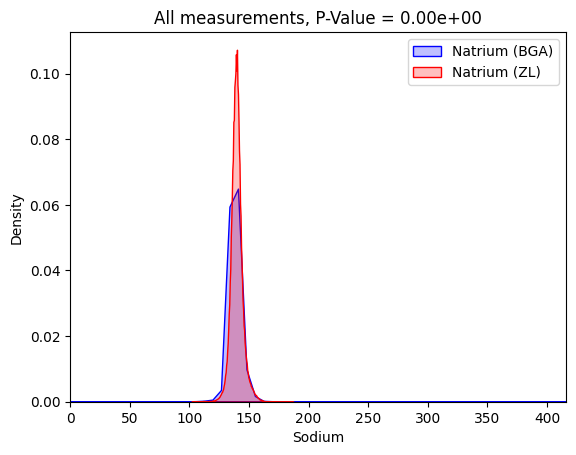

Feature:Sodium, T=5


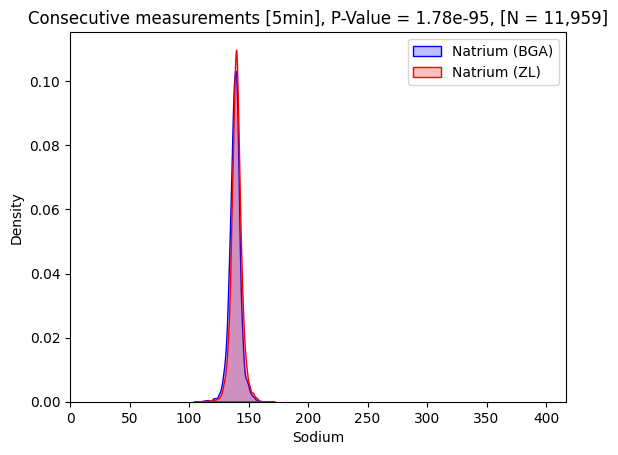

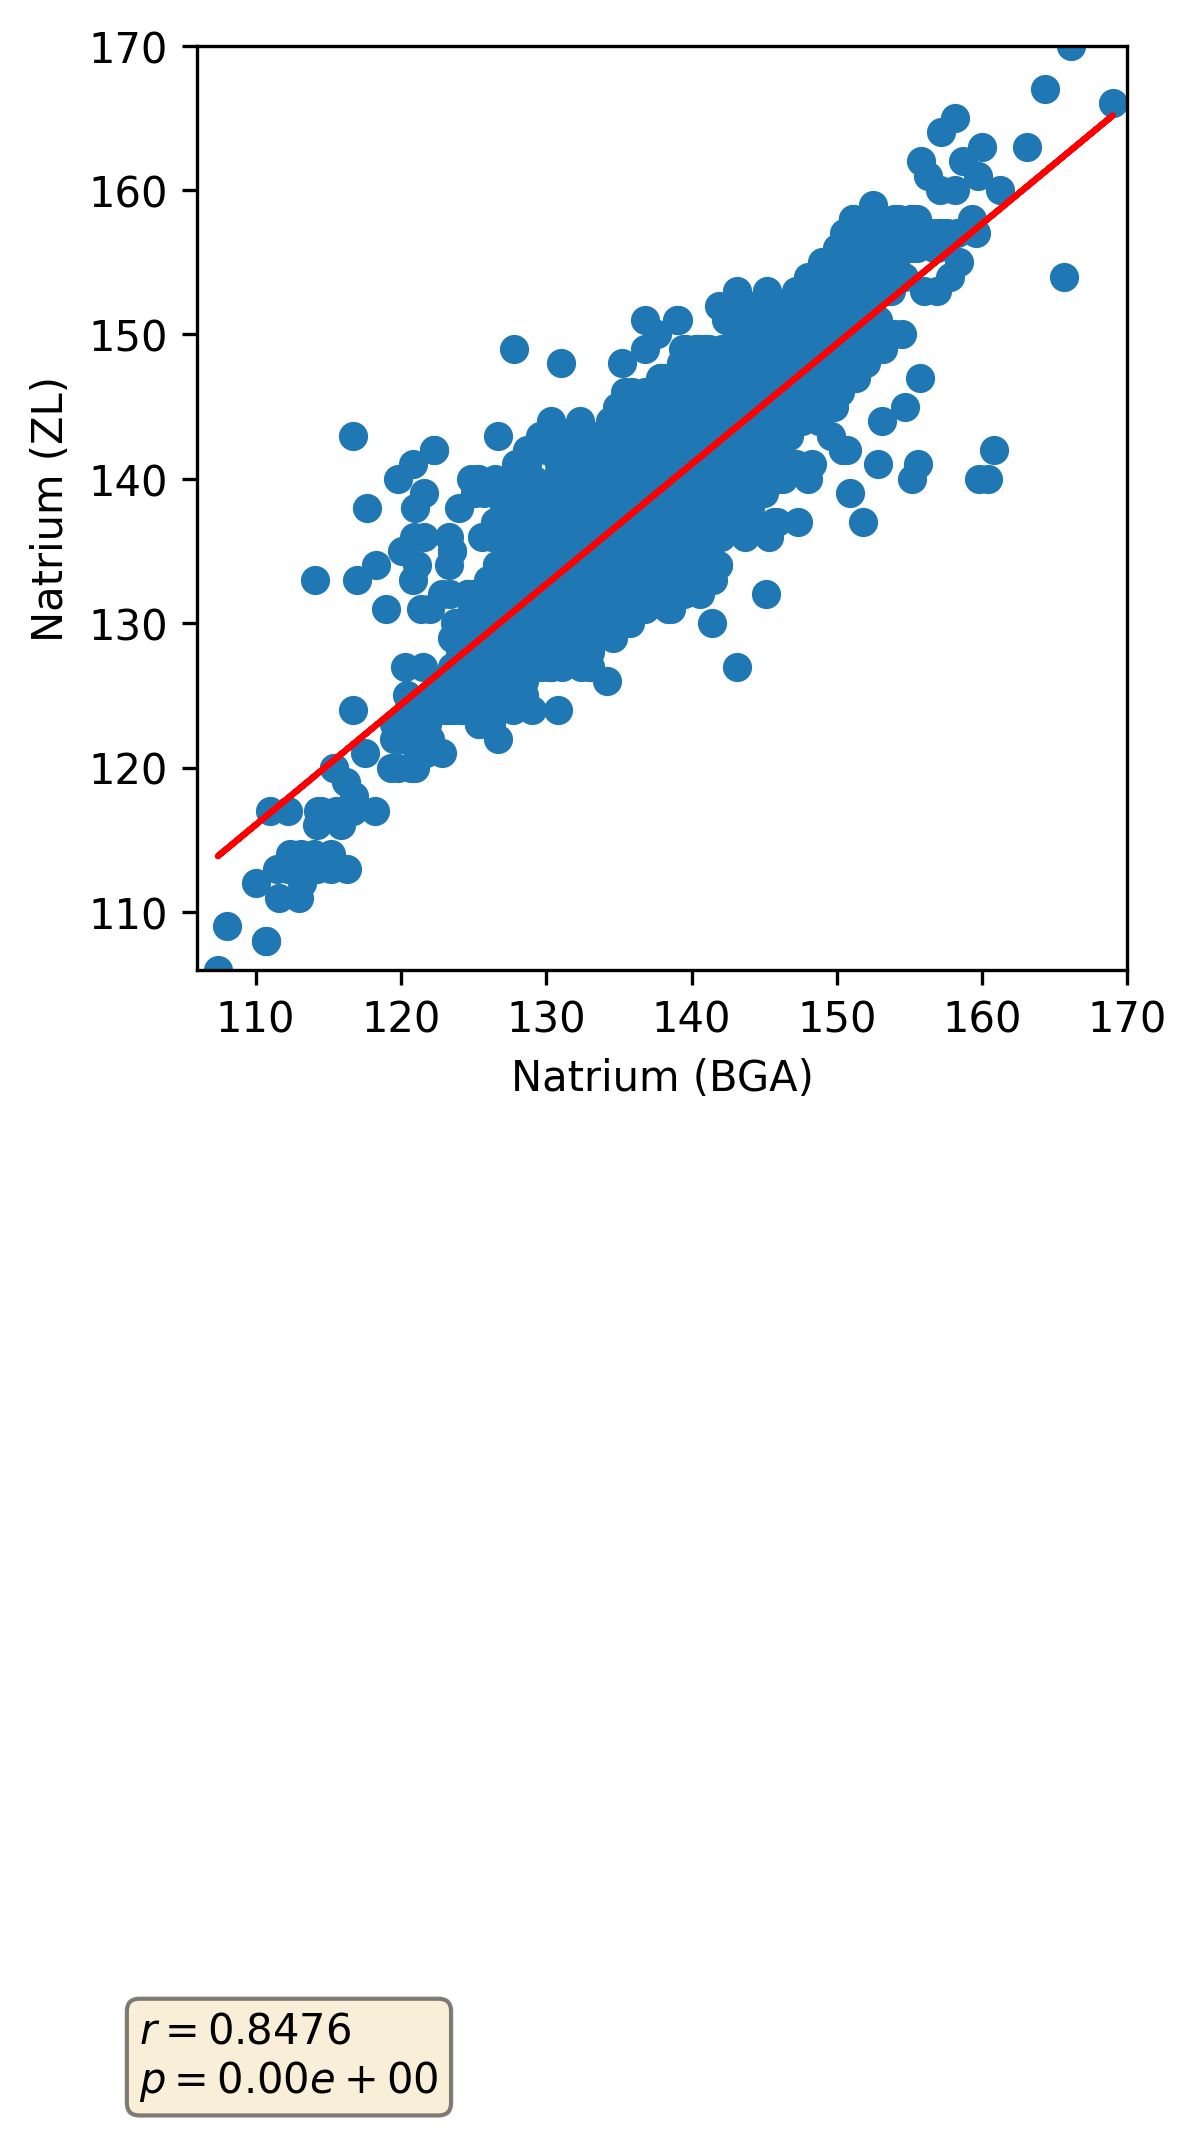

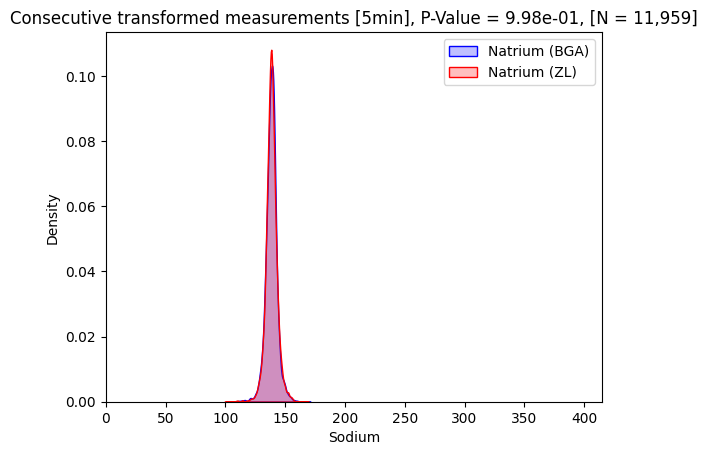

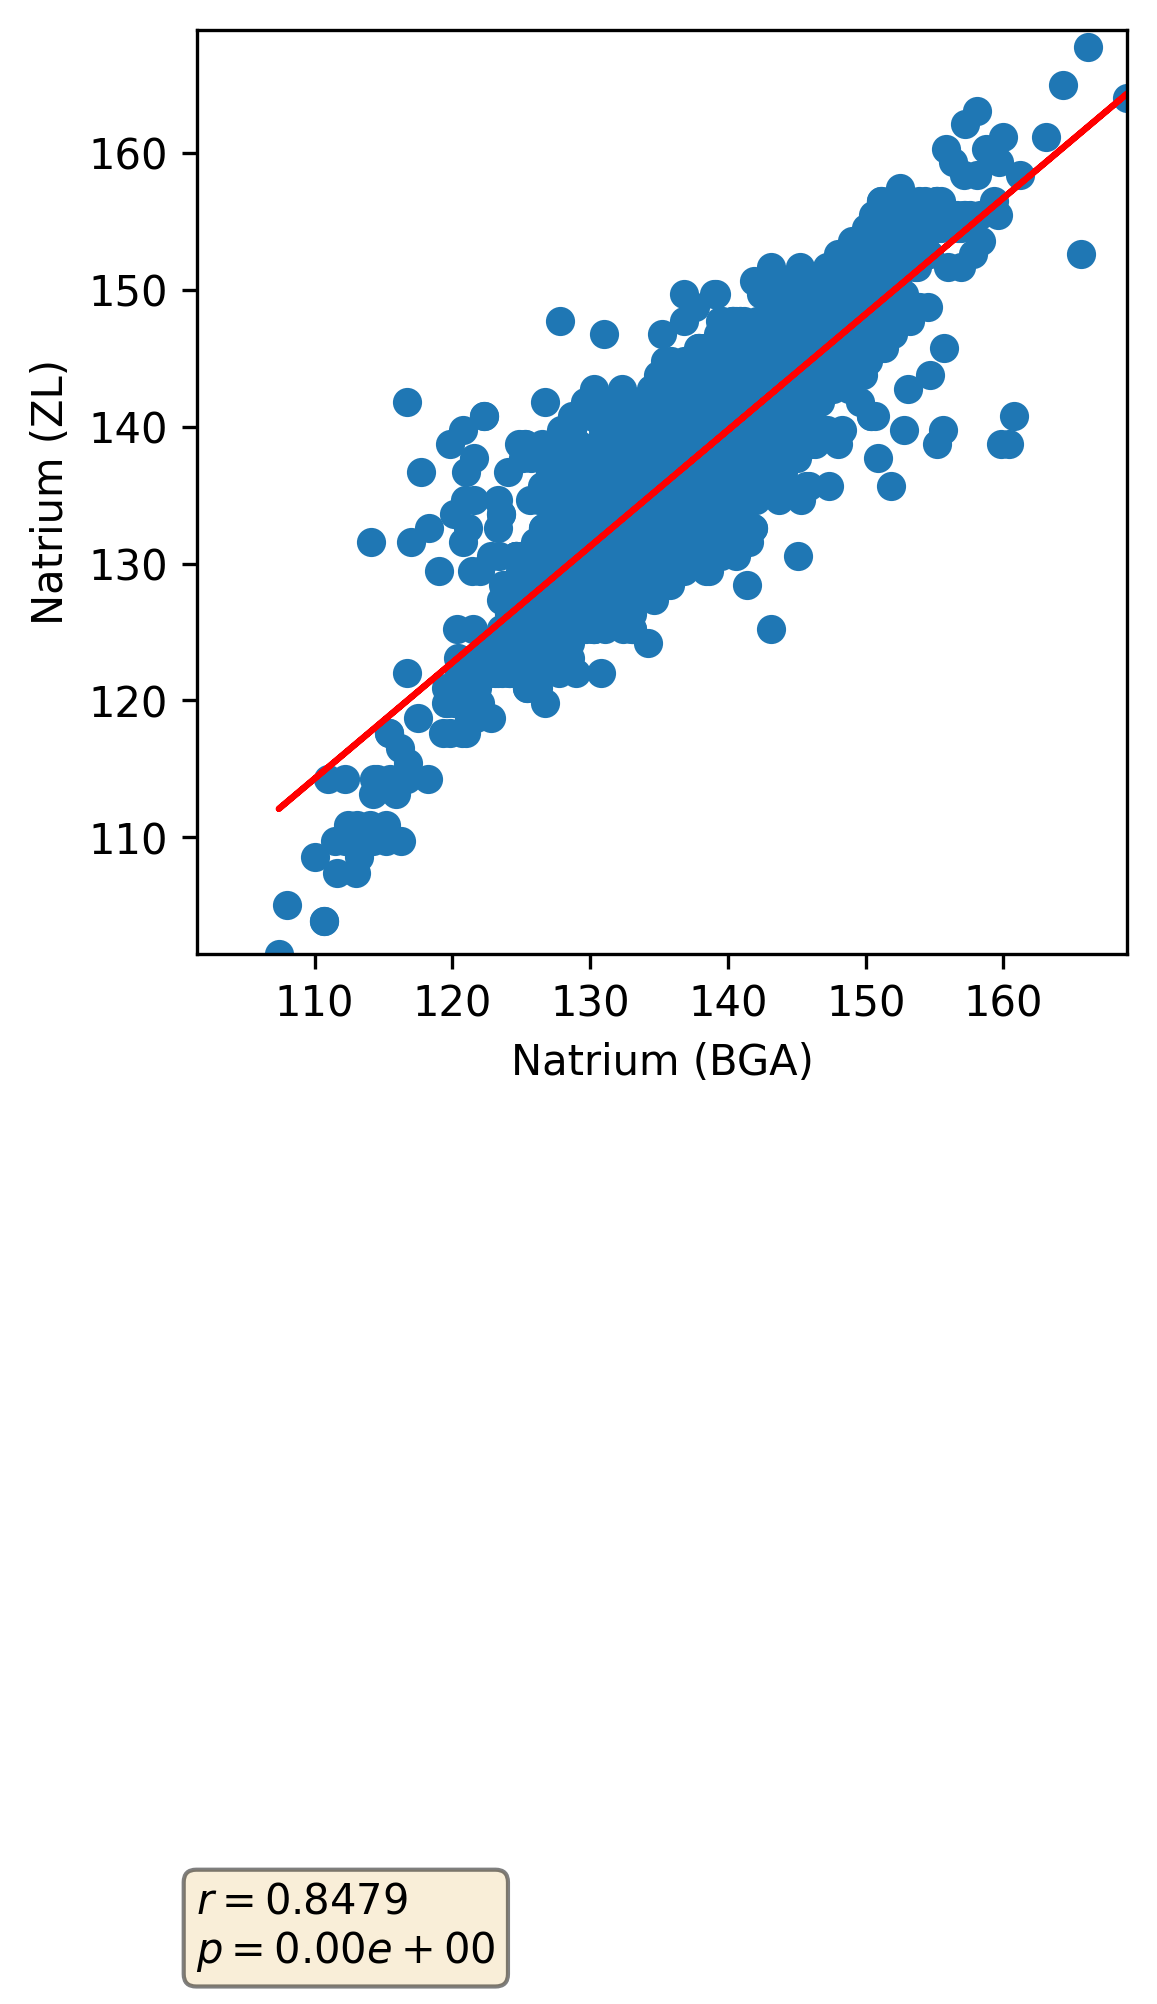

Feature:Sodium, T=10


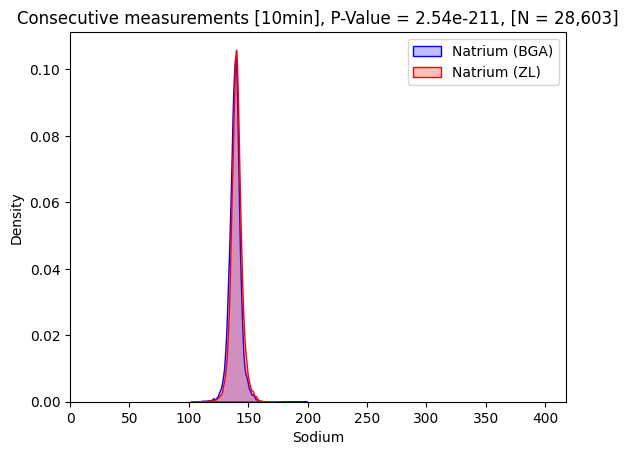

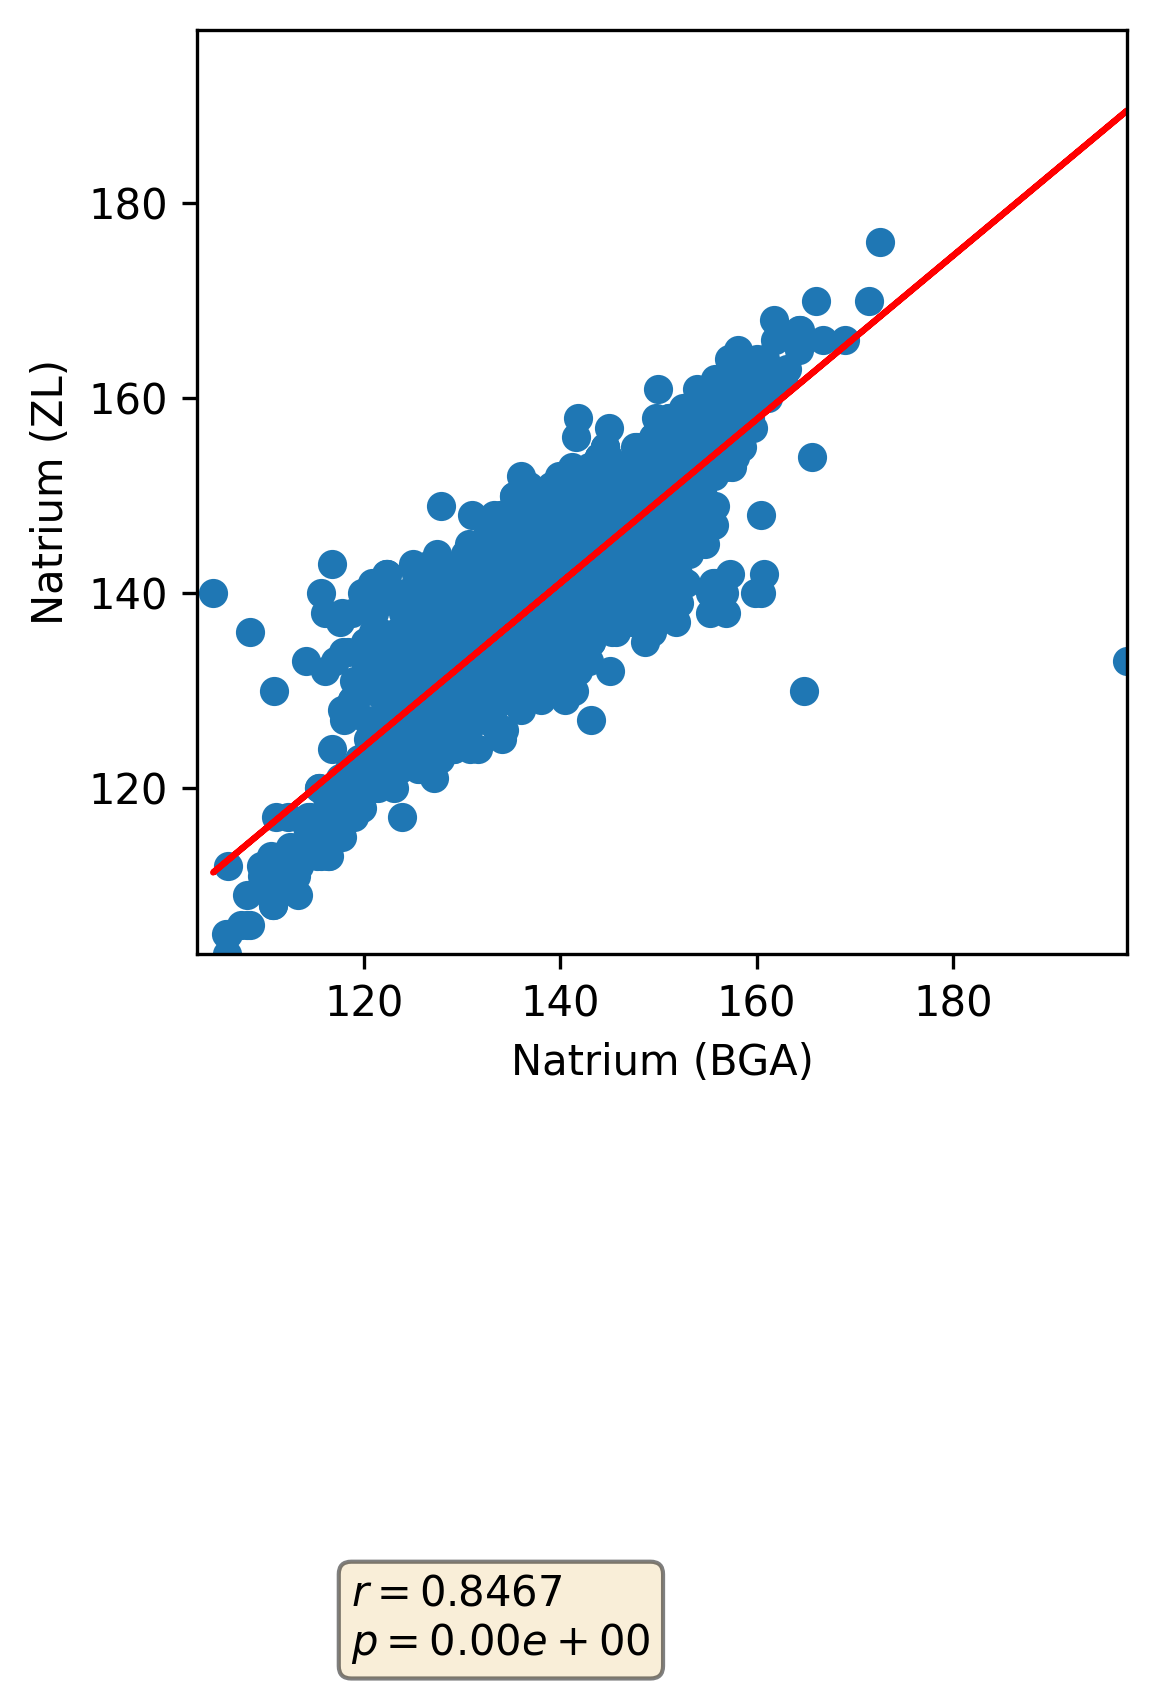

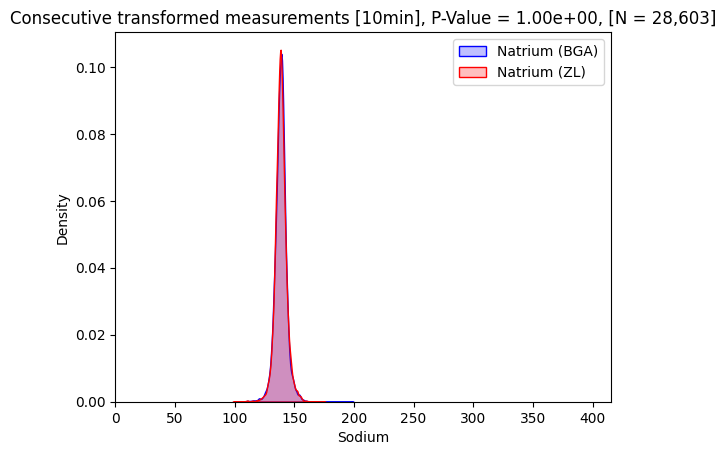

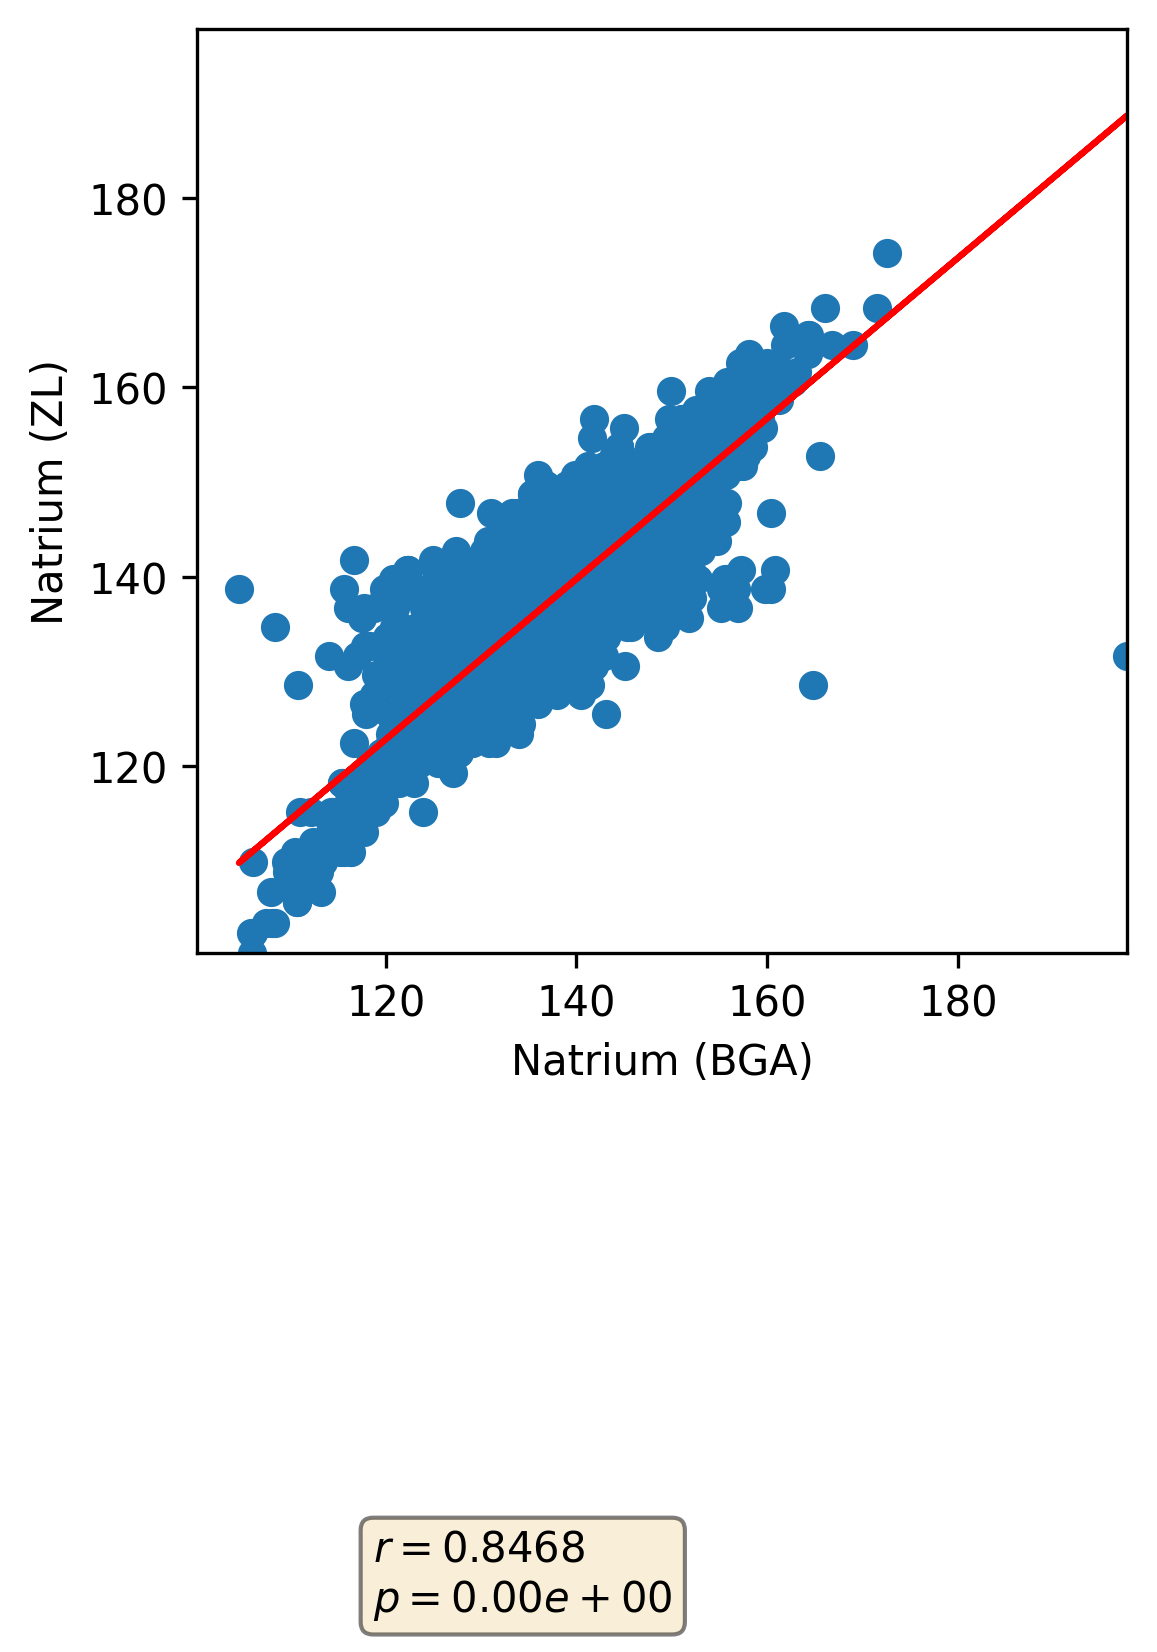

In [40]:
df_res = pd.DataFrame(columns=['Feature','Time','P_val_t','R_t','P_val_nt','R_nt'])

#t_lab_name = 'Hemoglobin'

for t_lab_name in LAB_MAPPING.keys():
    #Extract most common and 2nd common ids per lab name from the full cohort
    counts_per_id = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[t_lab_name])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()
    top_id = counts_per_id.index[0]
    next_id = counts_per_id.index[1]


    all_measurements_plot(df,COLNAMES_DICT, t_lab_name,'first',top_id,next_id)
    all_measurements_plot(df,COLNAMES_DICT, t_lab_name,'all',top_id,next_id)
    #all_measurements_plot(df,COLNAMES_DICT, FEATURE_NAME,is_first=True)

    # load conssecutive measurements
    df_lab = pd.read_csv(f'sicdb_{t_lab_name}_consecutive.csv', index_col=[0])

    # remove last rows per patient
    df_lab = df_lab[(df_lab['next_VALUENUM'] != 'END') & (df_lab[COLNAMES_DICT['VALUE_COL']] != 'END')]

    # covnvert values to numeric values
    df_lab['next_VALUENUM'] = pd.to_numeric(df_lab['next_VALUENUM'])
    df_lab[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df_lab[COLNAMES_DICT['VALUE_COL']])

    #exclude inhuman values
    df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] >0) & (df_lab['next_VALUENUM'] >0)]
    df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] <1000) & (df_lab['next_VALUENUM'] <1000)]


    #max_int = 2 #minutes
    for max_int in [5,10]:
        print(f'Feature:{t_lab_name}, T={max_int}')
        # Take only subset with consecutive measurements lower than max-int
        df_lab_t = df_lab[df_lab.delta_time < max_int]
        # Exlude nan values
        df_lab_t = df_lab_t[(~df_lab_t[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_t.next_VALUENUM.isna())]

        next_values = df_lab_t[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
        current_values =  df_lab_t[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

        total_data = pd.concat([current_values,next_values],axis =0)
        total_data[COLNAMES_DICT['ITEM_ID_COL']] = pd.to_numeric(total_data[COLNAMES_DICT['ITEM_ID_COL']])

        p_val_non_trasnformed = all_measurements_plot(total_data,COLNAMES_DICT, t_lab_name,'consecutive',top_id,next_id, max_int)
        p_corr_non_trasnformed, corr_non_trasnformed = correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,'non_trasnformed')

        top_box_lambda,mu_top,sig_top, total_data_boxcox = box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT)

        p_val_trasnformed = all_measurements_plot(total_data_boxcox,COLNAMES_DICT, t_lab_name,'consecutive_transformed',top_id,next_id, max_int)
        p_corr_trasnformed, corr_trasnformed = correlation_plot(lab_metadata,total_data_boxcox,COLNAMES_DICT,top_id,next_id,'trasnformed')

        tempRow = [t_lab_name, max_int,p_corr_trasnformed, corr_trasnformed,p_val_non_trasnformed,corr_non_trasnformed]
        df_res = df_res.append(pd.Series(tempRow, index=df_res.columns), ignore_index=True)

In [44]:
df_res['per'] = round(100*((df_res['R_t'] - df_res['R_nt'])/df_res['R_nt']),4)
df_res

Feature Time        P_val_t       R_t       P_val_nt      R_nt     per
0   Hemoglobin    5   0.000000e+00  0.984398   3.509645e-42  0.984185  0.0216
1   Hemoglobin   10   0.000000e+00  0.982504   5.506211e-83  0.982401  0.0105
2   Hematocrit    5   0.000000e+00  0.972689   1.808466e-22  0.972630  0.0061
3   Hematocrit   10   0.000000e+00  0.970677   1.697431e-48  0.970608  0.0072
4      Glucose    5   0.000000e+00  0.943255   8.739975e-05  0.943233  0.0024
5      Glucose   10   0.000000e+00  0.950120   3.518924e-17  0.969028 -1.9512
6      Lactate    5   2.663173e-56  0.965779   6.606388e-01  0.965424  0.0368
7      Lactate   10  9.104688e-184  0.985266   7.912016e-01  0.985819 -0.0562
8      Chlorid    5   0.000000e+00  0.903498   3.032630e-21  0.863646  4.6143
9      Chlorid   10   0.000000e+00  0.913160   6.164826e-50  0.904381  0.9708
10   Potassium    5   0.000000e+00  0.935825   6.617621e-18  0.935829 -0.0005
11   Potassium   10   0.000000e+00  0.943698   1.330617e-62  0.943703 -0.0004
12      Sodium    5   0.000000e+00  0.847893   1.776635e-95  0.847610  0.0334
13      Sodium   10   0.000000e+00  0.846786  2.535178e-211  0.846655  0.0155

In [32]:
(~top_sorted_values.isna()) & (~next_sorted_values.isna())

3250        True
3503        True
7374        True
7453        True
9468        True
            ... 
17480761    True
17489892    True
17490622    True
17495657    True
17499689    True
Name: LaboratoryValue, Length: 2360, dtype: bool

In [25]:
total_data[total_data.index == 213]

LaboratoryID  LaboratoryValue
213           658             14.0
213           289             14.1

In [63]:
#df[df.LaboratoryID.isin([658,289])]['LaboratoryID'].value_counts()
lab_metadata[lab_metadata.ReferenceValue.str.contains('mato')]


ReferenceGlobalID        ReferenceValue  ReferenceName  \
31                  183  Hämatokrit (BG) (ZL)     Laboratory   
65                  217       Hämatokrit (ZL)     Laboratory   
530                 682      Hämatokrit (BGA)     Laboratory   
605                 757          Dermatologie  ReferringUnit   
1179               1952          Somatostatin           Drug   
1465               2244          Dermatologie  DischargeUnit   

     ReferenceDescription ReferenceUnit  ReferenceOrder  ReferenceType  Data  
31                    NaN             %               0            0.0   NaN  
65                    NaN             %               0            0.0   NaN  
530                   NaN             %               0            0.0   NaN  
605                   NaN           NaN               0            0.0   NaN  
1179                  NaN             g               0            NaN   NaN  
1465                  NaN           NaN               0            NaN   NaN

In [244]:
t_subject_id = 996302    
t_ids = LAB_MAPPING['Hemoglobin']
df_pat = df[(df[COLNAMES_DICT['SUBJECT_ID']] == t_subject_id) & df[COLNAMES_DICT['ITEM_ID_COL']].isin(t_ids)]

df_pat['Offset'] = df_pat['Offset']/60

# sort patient data in ascending order and filter shifted rows
asc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)
asc_sorted = asc_sorted.loc[asc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != asc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

dsc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=False)
dsc_sorted = dsc_sorted.loc[dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

# take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
df_pat_sum = df_pat[df_pat[COLNAMES_DICT['ROW_ID']].isin(dsc_sorted[COLNAMES_DICT['ROW_ID']].to_list()+asc_sorted[COLNAMES_DICT['ROW_ID']].to_list())].drop_duplicates()
df_pat_sum = df_pat_sum.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)

x = df_pat_sum[COLNAMES_DICT['TIME_SINCE_AD']].diff()
df_pat_sum['delta_time'] =  x.iloc[np.arange(-len(x)+1,1)]
#df_pat_sum['delta_time'] = df_pat_sum[COLNAMES_DICT['TIME_SINCE_AD']].diff()

# create col for the next value and item id
df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['VALUE_COL']].shift(1, fill_value='END')
df_pat_sum['next_ITEMID'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['ITEM_ID_COL']].shift(1, fill_value='END')

#detect rows with the different ITEMIDs on the next row 
df_pat_sum['diff_ids'] = df_pat_sum[COLNAMES_DICT['ITEM_ID_COL']].diff() 
df_pat_sum = df_pat_sum[~df_pat_sum.diff_ids.isna()]
df_pat_sum['diff_ids'] = (df_pat_sum['diff_ids'] != 0)


#filter only rows with different ITEMIS
df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]

C:\Users\danco\AppData\Local\Temp\ipykernel_30932\4073657872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pat['Offset'] = df_pat['Offset']/60


In [ ]:
def extract_consecutive_measurement(df,COLNAMES_DICT, FEATURE_NAME, t_subject_id,t_ids):
    
    #extract patient data
    df_pat = df[(df[COLNAMES_DICT['SUBJECT_ID']] == t_subject_id) & df[COLNAMES_DICT['ITEM_ID_COL']].isin(t_ids)]
    
    # sort patient data in ascending order and filter shifted rows
    asc_sorted = df_pat.sort_values(by='CHARTTIME', ascending=True)
    asc_sorted = asc_sorted.loc[asc_sorted['ITEMID'].shift(-1) != asc_sorted['ITEMID']]

    # sort patient data in descending order and filter shifted rows
    dsc_sorted = df_pat.sort_values(by='CHARTTIME', ascending=False)
    dsc_sorted = dsc_sorted.loc[dsc_sorted['ITEMID'].shift(-1) != dsc_sorted['ITEMID']]

    # take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
    df_pat_sum = df_pat[df_pat.ROW_ID.isin(dsc_sorted.ROW_ID.to_list()+asc_sorted.ROW_ID.to_list())].drop_duplicates()
    df_pat_sum = df_pat_sum.sort_values(by='CHARTTIME', ascending=True)

    # calculate time difference between each consecutive rows
    df_pat_sum['CHARTTIME'] = pd.to_datetime(df_pat_sum['CHARTTIME'])
    df_pat_sum['delta_time'] = df_pat_sum['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')
    
    # create col for the next value and item id
    df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby('SUBJECT_ID')['VALUENUM'].shift(1, fill_value='END')
    df_pat_sum['next_ITEMID'] = df_pat_sum.groupby('SUBJECT_ID')['ITEMID'].shift(1, fill_value='END')
    
    #detect rows with the different ITEMIDs on the next row 
    df_pat_sum['diff_ids'] = df_pat_sum['ITEMID'].diff() 
    df_pat_sum = df_pat_sum[~df_pat_sum.diff_ids.isna()]
    df_pat_sum['diff_ids'] = (df_pat_sum['diff_ids'] != 0)
    
    #filter only rows with different ITEMISa
    
    df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]
    
    return(df_pat_sum)
    #df_pat_sum[df_pat_sum.diff_ids == True]
    #df_pat_sum.sort_values(by='CHARTTIME', ascending=True)
    #xdd2['CHARTTIME'] = pd.to_datetime(xdd2['CHARTTIME'])
    #xdd2['delta_time'] = xdd2['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')
    #xdd2.loc[::2, 'delta_time'] ='bla'
    ##pd.to_datetime(xdd2.reset_index().loc[0,'CHARTTIME']) - pd.to_datetime(xdd2.reset_index().loc[1,'CHARTTIME'])
    #xdd2
    #xdd.ITEMID.value_counts()
    #dd['SUBJECT_ID'].value_counts().sort_values()


In [ ]:


art_vein_mapping = pd.DataFrame({'lab_name':       ['Hemoglobin', 'Glucose', 'Chloride', 'Hematocrit','Potassium', 'Sodium', 'Bicarbonate'],
                                 'vein_itemid':    [ 51222,        50931,     50902,      51221,       50971,       50983,    50882],
                                 'artery_itemid':  [ 50811,        50809,     50806,      50810,       50822,       50824,    50803]})

In [43]:
#lab_metadata[(lab_metadata.CATEGORY == 'Blood Gas') |(lab_metadata.CATEGORY == 'BLOOD GAS')]
lab_metadata.CATEGORY.value_counts()
#lab_metadata[((lab_metadata.CATEGORY == 'Chemistry') | (lab_metadata.CATEGORY == 'CHEMISTRY')) & (lab_metadata.LABEL.str.lower().str.contains('specimen'))]
#lab_metadata[((lab_metadata.CATEGORY == 'Blood Gas') | (lab_metadata.CATEGORY == 'BLOOD GAS')) & (lab_metadata.LABEL.str.lower().str.contains('specimen'))]
#lab_metadata[((lab_metadata.CATEGORY == 'Hematology') | (lab_metadata.CATEGORY == 'HEMATOLOGY')) & (lab_metadata.LABEL.str.lower().str.contains('specimen'))]
lab_metadata[((lab_metadata.CATEGORY == 'Hematology') | (lab_metadata.CATEGORY == 'HEMATOLOGY')) & (lab_metadata.LABEL.str.lower().str.contains('blood'))]
lab_metadata.FLUID.value_counts()

#lab_metadata[(lab_metadata.ITEMID == 50882)]

Blood                        359
Urine                        103
Other Body Fluid              82
Bone Marrow                   40
Ascites                       37
Pleural                       35
Cerebrospinal Fluid (CSF)     30
Joint Fluid                   26
BLOOD                         15
OTHER BODY FLUID               9
Stool                          6
URINE                          6
JOINT FLUID                    2
CSF                            1
ASCITES                        1
STOOL                          1
Name: FLUID, dtype: int64

In [11]:
df_labs_mimic = pd.read_csv(os.path.join(root_path,  'LABEVENTS.csv.gz'))

In [13]:
df_labs_mimic[df_labs_mimic.ITEMID == 50800].VALUE.value_counts()

ART               358198
MIX                27294
VEN                18511
CENTRAL VENOUS       782
Name: VALUE, dtype: int64

In [51]:
df_specimen = df_labs_mimic[df_labs_mimic.ITEMID == 50800][['SUBJECT_ID','CHARTTIME','VALUE']].drop_duplicates().rename(columns={"VALUE": "SPEC_TYPE"})
df_specimen
#df_labs_mimic[(df_labs_mimic.SUBJECT_ID == 3) & (df_labs_mimic.CHARTTIME == '2101-10-22 04:31:00')]

SUBJECT_ID            CHARTTIME SPEC_TYPE
1                  3  2101-10-12 18:17:00       ART
113                3  2101-10-15 12:42:00       ART
209                3  2101-10-22 04:31:00       ART
227                3  2101-10-22 07:13:00       ART
237                3  2101-10-22 10:16:00       ART
...              ...                  ...       ...
27853997       96443  2109-12-29 18:45:00       ART
27854005       96443  2109-12-29 20:05:00       ART
27854016       96443  2109-12-29 21:17:00       ART
27854028       96443  2109-12-29 22:11:00       MIX
27854036       96443  2109-12-29 23:04:00       ART

[404733 rows x 3 columns]

In [53]:
#temp_d = df_labs_mimic[(df_labs_mimic.SUBJECT_ID == 3)]
df_pat_sum = pd.read_csv('Hematocrit.csv', index_col=[0])
df_pat_sum2 = pd.merge(df_pat_sum, df_specimen, how="left", on=['SUBJECT_ID','CHARTTIME'])


In [54]:
df_pat_sum2

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID            CHARTTIME  VALUE  \
0       24112058       70764  178319.0   50811  2160-02-22 20:21:00   11.9   
1       24112078       70764  178319.0   51222  2160-02-22 22:29:00   11.2   
2       24112642       70764  178319.0   50811  2160-02-29 08:43:00    8.6   
3       24112694       70764  178319.0   51222  2160-03-01 02:55:00    6.9   
4       24112771       70764  178319.0   50811  2160-03-01 21:31:00    7.9   
...          ...         ...       ...     ...                  ...    ...   
331462  27728903       98749  158912.0   51221  2196-05-04 01:00:00   42.4   
331463  27756750       98950  159017.0   50810  2154-02-25 22:13:00   33.0   
331464  27756752       98950  159017.0   51221  2154-02-26 00:06:00   29.1   
331465  27789704       99184  171203.0   50810  2193-12-16 20:45:00   43.0   
331466  27789735       99184  171203.0   51221  2193-12-17 01:48:00   39.8   

        VALUENUM VALUEUOM      FLAG  delta_time  next_VALUENUM  next_ITEMID  \
0           11.9     g/dL  abnormal    2.466667           13.3        51222   
1           11.2     g/dL  abnormal    2.133333           11.9        50811   
2            8.6     g/dL  abnormal    6.883333            7.2        51222   
3            6.9     g/dL  abnormal   16.483333            9.2        50811   
4            7.9     g/dL  abnormal    6.350000            8.8        51222   
...          ...      ...       ...         ...            ...          ...   
331462      42.4        %     delta    3.933333           56.0        50810   
331463      33.0        %       NaN    5.216667           35.5        51221   
331464      29.1        %  abnormal    1.883333           33.0        50810   
331465      43.0        %       NaN    0.083333           41.0        51221   
331466      39.8        %       NaN    5.050000           43.0        50810   

        diff_ids SPEC_TYPE  
0           True       NaN  
1           True       NaN  
2           True       ART  
3           True       NaN  
4           True       ART  
...          ...       ...  
331462      True       NaN  
331463      True       NaN  
331464      True       NaN  
331465      True       NaN  
331466      True       NaN  

[331467 rows x 14 columns]